In [1]:
#fetch command line argument (prepped model)
#%reset
import sys
import os
from copy import deepcopy
import pickle
import torch
import plotly.offline as py
import plotly.graph_objs as go


sys.path.insert(0, os.path.abspath('./prep_model_scripts/'))
sys.path.insert(0, os.path.abspath('./visualizer_scripts/'))
from visualizer_helper_functions import *
from contrast_helper_functions import *
from featureviz_helper_functions import *
from subgraph_helper_functions import *
from ablation_functions import *
from receptive_field import *
from dissected_Conv2d import *
from copy import deepcopy


py.init_notebook_mode(connected=True)   #jupyter notebook only

prepped_model_folder = 'alexnet_sparse'    #set this to a subfolder of prunned_models

full_prepped_model_folder = os.path.abspath('prepped_models/%s'%prepped_model_folder)

possible_models = os.listdir('prepped_models')
print('possible models to visualizer are:')
print(possible_models)

print('\nYou\'ve chosen to visualize %s'%prepped_model_folder)


sys.path.insert(0,'prepped_models/%s'%prepped_model_folder)

import prep_model_params_used as prep_model_params

params = {}
params['prepped_model'] = prepped_model_folder
params['prepped_model_path'] = full_prepped_model_folder
params['device'] = 'cuda:0'

possible models to visualizer are:
['mnist_resize', 'alexnet_old.tar.gz', 'mnist_old', '.keep', 'mnist', 'old', 'alexnet10', 'letter_mixed_not_trained', 'imagenet10_sparse', 'alexnet_sparse_test', '.DS_Store', 'alexnet_sparse_full_model_10classes', 'alexnet_sparse.tar.gz', 'imagenet10', 'alexnet_sparse', 'alexnet_lucent', 'mnist.tgz', 'alexnet', 'letter_mixed', 'googlenet10_test', '._.DS_Store', 'alexnet_corrupted', 'alexnet.tar.gz']

You've chosen to visualize alexnet_sparse


In [2]:
#Parameters

#Non-GUI parameters

#deepviz
params['deepviz_param'] = None
params['deepviz_optim'] = None
params['deepviz_transforms'] = None
params['deepviz_image_size'] = prep_model_params.deepviz_image_size

#backend
params['cuda'] = prep_model_params.cuda    #use gpu acceleration when running model forward
params['input_image_directory'] = prep_model_params.input_img_path+'/'   #path to directory of imput images you want fed through the network
params['preprocess'] = prep_model_params.preprocess     #torchvision transfrom to pass input images through
params['label_file_path'] = prep_model_params.label_file_path
params['criterion'] = prep_model_params.criterion
params['rank_img_path'] = prep_model_params.rank_img_path
params['num_workers'] = prep_model_params.num_workers
params['seed'] = prep_model_params.seed
params['batch_size'] = prep_model_params.batch_size
#params['dynamic_act_cache_num'] = 4  #max number of input image activations 'dynamic_activations' will have simultaneously

 
#aesthetic 

params['node_size'] = 12
params['edge_size'] = 1
params['max_node_inputs'] = 10    #there is a dropdown showing the top weighted edge inputs to nodes, how many maps in dropdown?
params['layer_colors'] = ['rgba(31,119,180,', 
                          'rgba(255,127,14,',
                          'rgba(44,160,44,', 
                          'rgba(214,39,40,',
                          'rgba(39, 208, 214,', 
                          'rgba(242, 250, 17,',
                          'rgba(196, 94, 255,',
                          'rgba(193, 245, 5,',
                          'rgba(245, 85, 5,',
                          'rgba(5, 165, 245,',
                          'rgba(245, 5, 105,',
                          'rgba(218, 232, 23,',
                          'rgba(148, 23, 232,',
                          'rgba(23, 232, 166,',]




#GUI parameters initialization (these parameters can be set in the GUI, but what values should they be initialized to?)
target_category = 'overall'     #category of images edges and nodes are weighted based on (which subgraph) 
rank_type = 'actxgrad'       #weighting criterion (actxgrad, act, grad, or weight)
projection = 'MDS smooth'           #how nodes within a layer are projected into the 2d plane (MDS or Grid)
edge_threshold = [.7,1]     #what range do edge ranks need to be in to be visualized
node_threshold = [.4,1]     #only relevant for hierarchical subgraph 

#### DONT EDIT BELOW initializations

figure_init = go.Figure()
figure_init.add_trace(go.Scatter(
            x=[],
            y=[]))
figure_init.update_layout(xaxis=dict(visible=False),
                  yaxis=dict(visible=False),
                  annotations = [dict(text="No Inputs",
                                      xref="paper",
                                      yref="paper",
                                      showarrow=False,
                                      font=dict(size=28))]
                 )

params['max_edge_weight'] = 1  #for the edge threshold slider, this dynamically adjusted its max value to max edge rank
                     #before there were multiple rank criterions, which made things confusing
                     #so well just fix it to 1 for now

In [3]:
#load Model

model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda'],device=params['device']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    
model_dis.to(params['device'])

print('loaded model:')
print(prep_model_params.model)
        
#del prep_model_params.model
model = prep_model_params.model
if params['cuda']:
    model.cuda()
model = model.eval()
model.to(params['device'])

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning:


Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/




loaded model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
#load misc graph data
print('loading misc graph data')
misc_data = pickle.load(open('./prepped_models/%s/misc_graph_data.pkl'%prepped_model_folder,'rb'))
params['layer_nodes'] = misc_data['layer_nodes']
params['num_layers'] = misc_data['num_layers']
params['num_nodes'] = misc_data['num_nodes']
params['categories'] = misc_data['categories']
params['num_img_chan'] = misc_data['num_img_chan']
params['imgnode_positions'] = misc_data['imgnode_positions']
params['imgnode_colors'] = misc_data['imgnode_colors']
params['imgnode_names'] = misc_data['imgnode_names']
params['prepped_model_path'] = full_prepped_model_folder
params['ranks_data_path'] = full_prepped_model_folder+'/ranks/'


print('model has categories:')
print(params['categories'])

loading misc graph data
model has categories:
['overall', 'Afghan_hound', 'African_chameleon', 'African_crocodile', 'African_elephant', 'African_grey', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'American_alligator', 'American_black_bear', 'American_chameleon', 'American_coot', 'American_egret', 'American_lobster', 'Angora', 'Appenzeller', 'Arabian_camel', 'Arctic_fox', 'Australian_terrier', 'Band_Aid', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'CD_player', 'Cardigan_corgi', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking', 'Crock_Pot', 'Dandie_Dinmont', 'Doberman', 'Dungeness_crab', 'Dutch_oven', 'Egyptian_cat', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'European_fire_salamander', 'European_gallinule', 'French_bulldog', 'French_horn', 'French_loaf', 'German_shepherd

In [5]:
#load nodes df
print('loading nodes rank data')
target_node = 'loss'

categories_nodes_df = pd.read_csv('prepped_models/%s/ranks/categories_nodes_ranks.csv'%prepped_model_folder)
target_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]

target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params,weight=False)

weight_nodes_df = pd.read_csv('prepped_models/%s/ranks/weight_nodes_ranks.csv'%prepped_model_folder)

weight_nodes_df = minmax_normalize_ranks_df(weight_nodes_df,params,weight=True)

node_colors,node_weights = gen_node_colors(target_nodes_df,rank_type,params) 

#load node positions
print('loading node position data')
all_node_positions = pickle.load(open('./prepped_models/%s/node_positions.pkl'%prepped_model_folder,'rb'))

if projection == 'Grid':
    node_positions = all_node_positions[projection]
else:
    node_positions = all_node_positions[projection][rank_type]



loading nodes rank data


/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/visualizer_scripts/visualizer_helper_functions.py:146: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



loading node position data


In [6]:
#load edges
print('loading edge data')

categories_edges_df = None
if os.path.exists('prepped_models/%s/edge_ranks.csv'%prepped_model_folder):
    categories_edges_df = pd.read_csv('prepped_models/%s/ranks/categories_edges_ranks.csv'%prepped_model_folder)   #load edges

if categories_edges_df is not None:
    #overall_edges_df = categories_edges_df.loc[categories_edges_df['category']=='overall']
    target_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
else:
    #overall_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','overall_edges_rank.pt'))
    target_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))

target_edges_df = minmax_normalize_ranks_df(target_edges_df,params,weight=False)

weight_edges_df = pd.read_csv('prepped_models/%s/ranks/weight_edges_ranks.csv'%prepped_model_folder)
  
weight_edges_df = minmax_normalize_ranks_df(weight_edges_df,params,weight=True)    
    
edges_thresholded_df = get_thresholded_ranksdf(edge_threshold,rank_type,target_edges_df)
 
    
num_edges = len(target_edges_df)
edges_df_columns = list(target_edges_df.columns)

edge_positions, edge_colors, edge_widths, edge_weights, edge_names, max_edge_width_indices = gen_edge_graphdata(edges_thresholded_df, node_positions, rank_type, target_category,params)

loading edge data


TypeError: gen_edge_graphdata() missing 1 required positional argument: 'kernel_colors'

In [7]:
#Load Edge Kernels
print('loading convolutional kernels')
kernels = torch.load('prepped_models/%s/kernels.pt'%prepped_model_folder)

loading convolutional kernels


In [8]:
#Input Image names
params['input_image_directory'] = prep_model_params.input_img_path+'/'
params['input_image_list'] = os.listdir(params['input_image_directory'])
params['input_image_list'].sort()
input_image_name = params['input_image_list'][0]

In [9]:
receptive_fields = None
if os.path.exists('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder):
    receptive_fields = pickle.load(open('prepped_models/%s/receptive_fields.pkl'%prepped_model_folder,'rb'))
    
input_image_size = 224   #got to figure out a way not to hard-code this
receptive_fields

OrderedDict([('features_-1',
              OrderedDict([('j', 1.0),
                           ('r', 1.0),
                           ('start', 0.5),
                           ('conv_stage', True),
                           ('output_shape', [-1, 3, 224, 224])])),
             ('features_0',
              OrderedDict([('j', 4.0),
                           ('r', 11.0),
                           ('start', 3.5),
                           ('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 55, 55])])),
             ('features_1',
              OrderedDict([('j', 4.0),
                           ('r', 11.0),
                           ('start', 3.5),
                           ('input_shape', [-1, 64, 55, 55]),
                           ('output_shape', [-1, 64, 55, 55])])),
             ('features_2',
              OrderedDict([('j', 8.0),
                           ('r', 19.0),
                           ('start', 7.5),
                           

In [10]:
#Format Node Feature Maps
print('loading activation maps')

all_activations = {'nodes':{},'edges_in':{},'edges_out':{}}
if os.path.exists('prepped_models/%s/input_img_activations.pt'%prepped_model_folder):
    all_activations = torch.load('prepped_models/%s/input_img_activations.pt'%prepped_model_folder)


loading activation maps


In [11]:
#hidden state, stores python values within the html itself
state = {'projection':projection,'rank_type':rank_type,'edge_positions':edge_positions,'edge_colors': edge_colors, 'edge_widths':edge_widths,'edge_names':edge_names,
         'edge_threshold':edge_threshold,'edge_weights':edge_weights,'max_edge_width_indices':max_edge_width_indices,
         'node_positions':node_positions,'node_colors':node_colors,'node_weights':node_weights,'node_threshold':node_threshold,'target_category':target_category,'target_node':'loss',
         'node_select_history':['0'],'edge_select_history':[edge_names[0][0]],'last_trigger':None,'input_image_name':input_image_name,
         'imgnode_positions':params['imgnode_positions'],'imgnode_colors':params['imgnode_colors'],'imgnode_names':params['imgnode_names']}


NameError: name 'edge_positions' is not defined

In [12]:
#App Component Layouts
axis=dict(showbackground=False,
          showspikes=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          #range=[0,0],
          title=''
          )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.00, y=-1.25, z=1.25)
)


network_graph_layout = go.Layout(
         #title="%s through Prunned Cifar10 CNN"%target_category,
         #title = target_category,
         #width=1000,
         clickmode = 'event+select',
         transition = {'duration': 20},
         height=500,
         #showlegend=False,
         margin = dict(l=20, r=20, t=20, b=20),
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
             aspectmode ="manual", 
             aspectratio = dict(x=1, y=0.5, z=0.5) #adjusting this stretches the network layer-to-layer
         ),
         scene_camera = camera,
         uirevision =  True   
         #hovermode='closest',
   )


input_image_layout = go.Layout(#width=200, 
                      #height=200,
                      uirevision = True,
                      margin=dict(
                        l=12,
                        r=1,
                        b=12,
                        t=1,
                        pad=10
                        ),
                        paper_bgcolor='rgba(0,0,0,0)',
                        plot_bgcolor='rgba(0,0,0,0)',
                        xaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False),
                        yaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False))


node_actmap_layout = go.Layout(
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


edge_inmap_layout = go.Layout(
    #title = 'edge input map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


edge_outmap_layout = go.Layout(
    #title = 'edge output map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


kernel_layout = go.Layout(
    #title='kernel'
    #autosize=False,
    #width=180,
    #height=120,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


In [13]:
#Generate Network Graph
combined_traces = gen_networkgraph_traces(state,params)
network_graph_fig=go.Figure(data=combined_traces, layout=network_graph_layout)

NameError: name 'state' is not defined

In [14]:
#Dash App Setup
print('setting up dash app')

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.exceptions import PreventUpdate
#import utils.dash_reusable_components as drc
import flask
import os

import json

from dash.dependencies import Input, Output, State

from plotly.subplots import make_subplots

from flask_caching import Cache

#external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(external_stylesheets = external_stylesheets)



if not os.path.exists(full_prepped_model_folder+'/cache/'):
    os.mkdir(full_prepped_model_folder+'/cache/')
CACHE_CONFIG = {
    # try 'filesystem' if you don't want to setup redis
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': full_prepped_model_folder+'/cache/'}
cache = Cache()
cache.init_app(app.server, config=CACHE_CONFIG)
    


styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}


theme =  {
    'dark': True,
    'detail': '#007439',
    'primary': '#00EA64',
    'secondary': '#6E6E6E',
}


app.layout = html.Div([
        html.Div(
            children = [
                
            html.Div(
                #Left side control panel
                children = [
                 html.Label('Subgraph Controls', style={'fontSize': 18,'font-weight':'bold'}),
                 html.Br(),
                 html.Label('Input'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Input(id='input-category',value=state['target_category']),
                html.Br(),
                html.Br(),
                html.Label('Output'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Dropdown(
                    id='target-node',
                    options=[
                    {'label': i, 'value': i} for i in ['loss']+[str(node) for node in list(range(params['num_nodes']))]
                    ],
                    value=state['target_node']),
                 html.Br(),
                 html.Label('Subgraph Criterion'),
                 dcc.Dropdown(
                    id='subgraph-criterion',
                    options=[
                        {'label': 'Activations*Grads', 'value': 'actxgrad'},
                        {'label': 'Activations', 'value': 'act'},
                        {'label': 'Gradients', 'value': 'grad'},
                        {'label': 'Weights', 'value': 'weight'},
                        {'label': 'Hierarchical', 'value': 'hierarchical'}
                        
                    ],
                    value='actxgrad'
                    ),
                 html.Br(),   
                 html.Label('Layer Projection'),
                 dcc.Dropdown(
                    id = 'layer-projection',
                    options=[
                        {'label': 'MDS', 'value': 'MDS'},
                        {'label': 'MDS smooth', 'value': 'MDS smooth'},
                        {'label': 'Grid', 'value': 'Grid'},
                        #{'label': 'SOM', 'value': 'SOM'}
                    ],
                    value='MDS smooth'
                    ),

                html.Br(),
                html.Label('Edge Thresholds'),
                    dcc.RangeSlider(
                        id='edge-thresh-slider',
                        min=0,
                        max=np.ceil(params['max_edge_weight']*10)/10,
                        step=0.001,
                        marks={i/10: str(i/10) for i in range(0,int(np.ceil(params['max_edge_weight']*10))+1,int(round(np.ceil(params['max_edge_weight']*10)/5)))},
                        value=edge_threshold,
                    ),
                html.Label('Node Thresholds'),
                    dcc.RangeSlider(
                        id='node-thresh-slider',
                        min=0,
                        max=1,
                        step=0.001,
                        marks={i/10: str(i/10.0) for i in range(0,11)},
                        value=node_threshold,
                    ),

                ], className="two columns",
                ),
                
            html.Div([
                dcc.Graph(
                    id='network-graph',
                    figure=network_graph_fig
                )
                ], className= 'ten columns'
                ),
            ], className="row"
        ),


                
        html.Div([
            html.Div([
            html.Label('Input Image', style={'fontSize': 18,'font-weight':'bold'}),
            dcc.Dropdown(id="dynamic-input-image-dropdown",value=params['input_image_list'][0]),
            #dcc.Dropdown(
            #    id='input-image-dropdown',
            #    options=[{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')],
            #    value=input_image_name
            #),
            html.Br(),
            dcc.Graph(
                id='img-actmap-graph',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=image2heatmap(params['input_image_directory']+input_image_name,input_image_layout),
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "two columns"),

            html.Div([
            html.Label('Node', style={'fontSize': 18,'font-weight':'bold'}),
            dcc.Dropdown(
                id='node-actmap-dropdown',
                options=[{'label': str(j), 'value': str(j)} for j in params['imgnode_names']]+[{'label': str(i), 'value': str(i)} for i in range(params['num_nodes'])],
                value='0'
            ),
            html.Br(),
            dcc.Graph(
                id='node-actmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            dcc.Checklist(
                id = 'relu-checkbox',
                options = [{'label':'relu','value':'relu'}],
                value = []
                
            ),
            html.Div(id='node-sum', style={'whiteSpace': 'pre-line'}),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='node-deepviz-image',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "three columns"),
            
            html.Div([
            html.Label('Node Inputs', style={'fontSize': 18,'font-weight':'bold'}),
            html.Br(),
            html.Div(dcc.Graph(
                id='node-inputs-graph',
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),style={'overflowY': 'scroll', 'height': 500})
            ], className = "three columns"),

            html.Div([
            html.Label('Edge', style={'fontSize': 18,'font-weight':'bold'}),    
            dcc.Input(
                id='edge-actmaps-input',value=state['edge_names'][0][0], type='text'),
            #html.Button(id='edge-kernel-button',n_clicks=0, children='Submit'),
            html.Br(),
            html.Br(),
            html.Label('Kernel'),
            dcc.Graph(
                id='edge-kernel-graph',
                style={
               'width': '14vw',
               'height':'10vw'
                },
                figure=go.Figure(data=go.Heatmap(
                                    z = edgename_2_edge_figures(state['edge_names'][0][0], input_image_name, kernels, None,params)[0]),
                                 layout=kernel_layout
                                ),
                config={
                        'displayModeBar': False
                        }
            ),
            html.Br(),
            html.Br(),
            dcc.Graph(
               id='edge-deepviz-image',
               style={
              'width': '14vw',
              'height':'14vw'
               },
               figure=figure_init,
               config={
                       'displayModeBar': False
                       }
            )
            ], className = "two columns"),


            html.Div([
            html.Label('Edge Input'),
            html.Br(),
            dcc.Graph(
                id='edge-inmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Div(id='edgein-sum', style={'whiteSpace': 'pre-line'}),
            html.Br(),
            html.Br(),
            html.Label('Edge Output'),
            html.Br(),
            dcc.Graph(
                id='edge-outmap-graph',
                style={
               'width': '18vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Div(id='edgeout-sum', style={'whiteSpace': 'pre-line'}),

            ], className = "two columns")


         ], className= 'row'
         ),
    
    
    html.Div([
            html.Div([
            html.Label('Image Manipulations', style={'fontSize': 18,'font-weight':'bold'}),
            html.Br(),
            html.Label('rotation'),
            dcc.Slider(
                id='image-rotation-slider',
                min=0,
                max=350,
                step=10,
                marks={
                        0:   '0°',
                        20:  '20°',
                        40:  '40°',
                        60:  '60°',
                        80:  '80°',
                        100: '100°',
                        120: '120°',
                        140: '140°',
                        160: '160°',
                        180: '180°',
                        200: '200°',
                        220: '220°',
                        240: '240°',
                        260: '260°',
                        280: '280°',
                        300: '300°',
                        320: '320°',
                        340: '240°',
                        },
                included=False,
                value=0,
            ),
            html.Br(),
            html.Label('scaling'),
            dcc.Slider(
                id='image-scaling-slider',
                min=-10,
                max=10,
                step=1,
                marks={
                        -8:  '.33',
                        -6:  '.4',
                        -4: '.5',
                        -2: '.67',
                         0: '1',
                         2: '1.5',
                         4: '2',
                         6: '2.5',
                         8: '3',
                        },
                included=False,
                value=0,
            ),            
            html.Br(),
            html.Label('colors'),

                    html.Label('R',style={'fontSize': 10,'font-weight':'italic'}),
                    dcc.Slider(
                        id='image-r-slider',
                        min=-1,
                        max=1,
                        step=.05,
                        marks={
                                -1:'-1',
                                -.8:'-.8',
                                -.6:'-.6',
                                -.4:'-.4',
                                 -.2:'-.2',
                                 0:'0',
                                 .2:'.2',
                                 .4:'.4',
                                 .6:'.6',
                                 .8:'.8',
                                  1:'1',
                                },
                        included=False,
                        value=0,
                    ),
 

                    html.Label('G',style={'fontSize': 10,'font-weight':'italic'}),
                    dcc.Slider(
                        id='image-g-slider',
                        min=-1,
                        max=1,
                        step=.05,
                        marks={
                                -1:'-1',
                                -.8:'-.8',
                                -.6:'-.6',
                                -.4:'-.4',
                                 -.2:'-.2',
                                 0:'0',
                                 .2:'.2',
                                 .4:'.4',
                                 .6:'.6',
                                 .8:'.8',
                                  1:'1',
                                },
                        included=False,
                        value=0,
                    ),
    

                    html.Label('B',style={'fontSize': 10,'font-weight':'italic'}),
                    dcc.Slider(
                        id='image-b-slider',
                        min=-1,
                        max=1,
                        step=.05,
                        marks={
                                -1:'-1',
                                -.8:'-.8',
                                -.6:'-.6',
                                -.4:'-.4',
                                 -.2:'-.2',
                                 0:'0',
                                 .2:'.2',
                                 .4:'.4',
                                 .6:'.6',
                                 .8:'.8',
                                  1:'1',
                                },
                        included=False,
                        value=0,
                    )
           
            ], className = "three columns"),
                
                
            html.Div([
            html.Label('Feature Visualizations', style={'fontSize': 18,'font-weight':'bold'}),
            html.Br(),
            html.Div( style=dict(display='flex'),
                children = [     
                    daq.ToggleSwitch(
                        id='featviz-nodeedge-toggle',
                        label=['node','edge    '],
                        style={'float': 'right','margin': 'auto'}
                        #labelPosition='bottom'
                    ), 
                    html.Label(''),
                    daq.ToggleSwitch(
                        id='featviz-channelneuron-toggle',
                        label=['channel','neuron    '],
                        style={'float': 'right','margin': 'auto'}
                        #labelPosition='bottom'
                    ),
                    html.Label(''),
                    daq.ToggleSwitch(
                        id='featviz-positivenegative-toggle',
                        label=['positive','negative    '],
                        style={'float': 'right','margin': 'auto'}
                        #labelPosition='bottom'
                    )
                ]),
            html.Br(),
            dcc.Graph(
               id='featviz-image',
               style={
              'width': '14vw',
              'height':'14vw'
               },
               figure=figure_init,
               config={
                       'displayModeBar': False
                       }
            ),
            html.Button('Generate', id='featviz-button')
            #html.Button('Generate', id='gen-featviz-button')
            ], className= "five columns"),
        
        
        
            html.Div([
            html.Label('Model Ablations', style={'fontSize': 18,'font-weight':'bold'}),
            dcc.Textarea(
                id='ablations-textarea',
                value='',
                style={'width': '70%', 'height': 300}),
            html.Button('Ablate', id='ablate-model-button')
            ], className= "four columns"),
        
        ], className="row"
        ),
                
#         html.Div([
#             html.Div([
#                 dcc.Markdown("""
#                     **Hover Data**

#                     Mouse over values in the graph.
#                 """),
#                 html.Pre(id='hover-data', style=styles['pre'])
#             ], className='two columns'),

#             html.Div([
#                 dcc.Markdown("""
#                     **Click Data**

#                     Click on points in the graph.
#                 """),
#                 html.Pre(id='click-data', style=styles['pre']),
#             ], className='two columns'),

#             html.Div([
#                 dcc.Markdown("""
#                     **Selection Data**

#                     Choose the lasso or rectangle tool in the graph's menu
#                     bar and then select points in the graph.

#                     Note that if `layout.clickmode = 'event+select'`, selection data also 
#                     accumulates (or un-accumulates) selected data if you hold down the shift
#                     button while clicking.
#                 """),
#                 html.Pre(id='selected-data', style=styles['pre']),
#             ], className='two columns'),

# #                 html.Div([
# #                     dcc.Markdown("""
# #                         **Zoom and Relayout Data**

# #                         Click and drag on the graph to zoom or click on the zoom
# #                         buttons in the graph's menu bar.
# #                         Clicking on legend items will also fire
# #                         this event.
# #                     """),
# #                     html.Pre(id='relayout-data', style=styles['pre']),
# #                 ], className='two columns')
                
#             html.Div([
#                 dcc.Markdown("""
#                     **Figure Data**

#                     Figure json info.
#                 """),
#                 html.Pre(id='figure-data', style=styles['pre']),
#             ], className='four columns')

#         ], className= 'row'
#         ),

    #hidden divs for storing intermediate values     
    # The memory store reverts to the default on every page refresh
    dcc.Store(id='memory',data=state),
    # The local store will take the initial data
    # only the first time the page is loaded
    # and keep it until it is cleared.
    #dcc.Store(id='local', storage_type='local'),
    # Same as the local store but will lose the data
    # when the browser/tab closes.
    #dcc.Store(id='session', storage_type='session',data=state),
    

    # hidden signal value
    html.Div(id='input-image-signal',  style={'display': 'none'}),
    html.Div(id='target-signal', style={'display': 'none'},children = [state['target_category'],state['target_node']]),
    html.Div(id='ablations-signal',  style={'display': 'none'}, children = [])
])



# perform expensive computations in this "global store"
# these computations are cached in a globally available
# 'cached' folder in the prepped_models/[model] folder
@cache.memoize()
def activations_store(image_name,ablation_list):

    print('Updating cached activations with {}'.format(image_name))
    activations = get_model_activations_from_image(get_image_path(image_name,params)[1], model_dis, params)
    
    return activations

@app.callback(Output('input-image-signal', 'children'), 
              [Input('dynamic-input-image-dropdown', 'value'),
               Input('ablations-signal', 'children')])
def update_activations_store(image_name,ablation_list):
    # compute value and send a signal when done
    activations_store(image_name,ablation_list)
    return image_name


@cache.memoize()
def ranksdf_store(target_category, target_node,ablation_list,model_dis=model_dis):
    print('Updating cached rank dfs with {}'.format(target_category))
    model_dis = clear_ranks_across_model(model_dis)
    target_type = image_category_or_contrast(target_category,params)
    target_category_nodes_df = None
    target_category_edges_df = None
    if target_type == 'category' and target_node == 'loss' and ablation_list == []:
        #edges
        if categories_edges_df is not None:
            if len(categories_edges_df.loc[categories_edges_df['category']==target_category]) > 0:
                target_category_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
        if target_category_edges_df is None:
            target_category_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))   
        #node
        if categories_nodes_df is not None:
            if len(categories_nodes_df.loc[categories_nodes_df['category']==target_category]) > 0:
                target_category_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]
        if target_category_nodes_df is None:
            target_category_nodes_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_nodes','%s_nodes_rank.pt'%target_category))
    elif target_type == 'category':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_for_category(target_category, target_node, model_dis,params))
    elif target_type == 'input_image':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_from_image(get_image_path(target_category,params)[1],target_node, model_dis, params))

    else:  #contrast
        target_category_nodes_df,target_category_edges_df = contrast_str_2_dfs(target_category,target_node,model_dis,params,ablation_list)
    #print('FROM RANKS DF STORE')
    print(target_category_edges_df)
    return target_category_nodes_df,target_category_edges_df

@app.callback(Output('target-signal', 'children'), 
              [Input('input-category', 'value'),
               Input('target-node','value'),
               Input('ablations-signal', 'children')])
def update_ranksdf_store(target_category,target_node,ablation_list):
    # compute value and send a signal when done
    print('update ranksdf_store triggered')
    ranksdf_store(target_category,target_node,ablation_list)
    return [target_category,target_node]



####Call Back Functions

#Ablations
@app.callback(Output('ablations-signal', 'children'), 
              [Input('ablate-model-button', 'n_clicks')],
              [State('ablations-textarea','value')])
def update_ablations(n_clicks,text,model_dis=model_dis):
    # compute value and send a signal when done
    ablation_list = ablation_text_2_list(text, params)
    ablate_model_with_list(ablation_list,model_dis,params)
    return ablation_list


#Hidden State
@app.callback(
    Output('memory', 'data'),
    [Input('target-signal', 'children'),
     Input('node-actmap-dropdown', 'value'),
     Input('edge-actmaps-input', 'value'),
     Input('edge-thresh-slider','value'),
     Input('node-thresh-slider','value'),
     Input('layer-projection','value'),
     Input('subgraph-criterion','value')],
    [State('memory', 'data'),
     State('ablations-signal', 'children')])
def update_store(target,node_value,edge_value,edge_threshold,node_threshold,projection,rank_type,state,ablation_list):
    print('CALLED: update_store\n')
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    state['last_trigger'] = trigger  #store the last trigger of state change in state
    print('TRIGGER %s'%trigger)
    
    hierarchical = False
    if rank_type == 'hierarchical':
        hierarchical = True
        rank_type = 'actxgrad'
        
    target_category,target_node = target[0],target[1]
    #fetch select edges DF
    if trigger in ['target-signal.children','edge-thresh-slider.value','node-thresh-slider.value','layer-projection.value','subgraph-criterion.value']:
        if rank_type == 'weight':
            target_edges_df = weight_edges_df
            target_nodes_df = weight_nodes_df
            weight=True
        else:   
            target_nodes_df,target_edges_df = ranksdf_store(target_category,target_node,ablation_list)
            weight=False   
        target_edges_df = minmax_normalize_ranks_df(target_edges_df,params,weight=weight)
        target_nodes_df = minmax_normalize_ranks_df(target_nodes_df,params,weight=weight)

        if hierarchical:
            #nodes_thresholded_df = get_thresholded_ranksdf(node_threshold,rank_type, target_nodes_df)
            #filter_edges_df = filter_edges_by_nodes(target_edges_df,nodes_thresholded_df)
            #edges_thresholded_df = get_thresholded_ranksdf(edge_threshold,rank_type,filter_edges_df)
            #edges_thresholded_df = hierarchically_threshold_edges(edge_threshold,rank_type,target_edges_df,nodes_thresholded_df)
            print('finding hierarchical subgraph')
            start = time.time()
            nodes_thresholded_df,edges_thresholded_df = hierarchical_accum_threshold(node_threshold[0],edge_threshold[0],rank_type,target_edges_df,target_nodes_df,ascending=False)
            print('time: %s'%str(time.time() - start))
            print('found %s nodes and %s edges'%(str(len(nodes_thresholded_df)),str(len(edges_thresholded_df))))
            #node_minmax = node_threshold
            node_min = {}
            for layer in target_nodes_df['layer'].unique():
                if len(nodes_thresholded_df.loc[nodes_thresholded_df['layer']==layer]) > 1:
                    node_min[layer] = nodes_thresholded_df.loc[nodes_thresholded_df['layer']==layer][rank_type+'_rank'].min()
                else:
                    node_min[layer] = None

        else: 
            nodes_thresholded_df = None
            edges_thresholded_df = get_thresholded_ranksdf(edge_threshold,rank_type,target_edges_df)
            node_min = None

    if trigger == 'target-signal.children':
        print('changing target category to %s'%target_category)
        #print(target_nodes_df)
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params,node_min=node_min)
        #state['max_edge_weight'] = get_max_edge_weight(target_category)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'node-actmap-dropdown.value' or trigger == 'edge-actmaps-input.value':
        state['last_trigger'] = 'selection_change'
        print(edge_value)
        #update node if button value different than store value
        if state['node_select_history'][-1] != node_value:
            print('changing selected node to %s'%node_value)
            state['node_select_history'].append(node_value)
            if len(state['node_select_history']) > 10:
                del state['node_select_history'][0] 
        #update edge if button value different than store value
        if state['edge_select_history'][-1] != edge_value and check_edge_validity(edge_value.strip(),params)[0]:
            print('changing selected edge to %s'%edge_value)
            state['edge_select_history'].append(edge_value)
            print(state['edge_select_history'])
            if len(state['edge_select_history']) > 10:
                del state['edge_select_history'][0]              

    elif trigger == 'edge-thresh-slider.value':
        print('changing edge thresholds to %s - %s'%(edge_threshold[0],edge_threshold[1]))
        state['edge_threshold'] == edge_threshold
        print('found %s edges'%len(edges_thresholded_df))
        state['edge_positions'], state['edge_colors'], state['edge_widths'], state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)
    
    elif trigger == 'node-thresh-slider.value':
        print('changing node thresholds to %s - %s'%(node_threshold[0],node_threshold[1]))
        state['node_threshold'] == node_threshold
        print('found %s nodes'%len(nodes_thresholded_df))
        state['edge_positions'], state['edge_colors'], state['edge_widths'], state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params,node_min=node_min)
        
        
    elif trigger == 'layer-projection.value':
        print('changing layer projection to %s\n'%projection)
        state['projection']=projection
        if projection == 'Grid':
            node_positions = all_node_positions[projection]
        else:
            node_positions = all_node_positions[projection][rank_type]
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'subgraph-criterion.value':
        print('changing weighting criterion to %s\n'%rank_type)
        state['rank_type']=rank_type
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params,node_min=node_min)
        #state['node_positions']=format_node_positions(projection=projection,rank_type=rank_type)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    else:
        raise Exception('unknown trigger: %s'%trigger)    
    return state


#Network Graph Figure
@app.callback(
    Output('network-graph', 'figure'),
    [Input('memory', 'data')],
    [State('network-graph','figure')])
def update_figure(state, fig):
    #network_graph_layout['uirevision'] = True
    print('CALLED: update_figure\n')
    print(state['edge_threshold'])
    print(state['edge_select_history'])
    print(state['node_select_history'])
    if state['last_trigger'] == 'selection_change':   #minimal updates
        #hightlight edge
        print('updating edge highlight to %s'%state['edge_select_history'][-1])
        #if len(state['edge_select_history']) >1:
        #if state['edge_select_history'][-1] != state['edge_select_history'][-2]:  #didnt click same point
        flat_edge_names = [item for sublist in state['edge_names'] for item in sublist]
        flat_edge_colors = [item for sublist in state['edge_colors'] for item in sublist]
        try:  #update current edge if it exists to black
            #print(flat_edge_names)
            fig['data'][flat_edge_names.index(state['edge_select_history'][-1])+params['num_layers']+1]['line']['color'] = 'rgba(0,0,0,1)'
        except:
            print('select edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-1])
        if len(state['edge_select_history']) > 1: #there is a previous edge to unselect
            try: #recolor previous edge if it exists from black
                fig['data'][flat_edge_names.index(state['edge_select_history'][-2])+params['num_layers']+1]['line']['color'] = flat_edge_colors[flat_edge_names.index(state['edge_select_history'][-2])]
            except:
                print('previous edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-2])
        #highlight node
        print('updating node highlight to %s'%state['node_select_history'][-1])
        #if len(state['node_select_history']) >1:
        #    if state['node_select_history'][-1] != state['node_select_history'][-2]: 
                #update current node color to black
        if str(state['node_select_history'][-1]).isnumeric():  #if normal node
            select_layer,select_position,select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-1],params)
            fig['data'][select_layer+1]['marker']['color'][select_position] = 'rgba(0,0,0,1)'
        else:   #imgnode
            fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-1])] = 'rgba(0,0,0,1)'
        #update previous node color to its usual color
        if len(state['node_select_history']) > 1: #there is a previous node to unselect
            if str(state['node_select_history'][-2]).isnumeric():  #if normal node
                prev_select_layer,prev_select_position,prev_select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-2],params)
                print(prev_select_layer,prev_select_position,prev_select_layer_name)
                fig['data'][prev_select_layer+1]['marker']['color'][prev_select_position] = state['node_colors'][prev_select_layer][prev_select_position]
            else:   #imgnode
                fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-2])] = state['imgnode_colors'][fig['data'][0]['text'].index(state['node_select_history'][-2])]
        #fig['layout']['uirevision']=True   
        return fig    
    else:   #regenerate full traces
        combined_traces = gen_networkgraph_traces(state,params)
        fig['data'] = combined_traces
        #layout = network_graph_layout
        #layout['uirevision'] = True
        return fig

#Node Actmap Dropdown
@app.callback(
    Output('node-actmap-dropdown', 'value'),
    [Input('network-graph', 'clickData')],
    [State('node-actmap-dropdown', 'value')])
def switch_node_actmap_click(clickData,current_value):
    print('CALLED: switch_node_actmap_click')
    if clickData is None:
        return current_value 
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) > params['num_layers']:
        return current_value
        #raise Exception('edge was clicked')
    return clickData['points'][0]['text']

#Edge Actmaps Input
@app.callback(
    Output('edge-actmaps-input', 'value'),
    [Input('network-graph', 'clickData')],
    [State('edge-actmaps-input', 'value'),
     State('memory', 'data')])
def switch_edge_actmaps_click(clickData,current_value,state):
    print('CALLED: switch_edge_actmaps_click')
    if clickData is None:
        return current_value
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) <= params['num_layers']:
        return current_value
        #raise Exception('node was clicked')
    return get_nth_element_from_nested_list(state['edge_names'],int(clickData['points'][0]['curveNumber'])-(params['num_layers']+1))


#Node actmap graph
@app.callback(
    Output('node-actmap-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('relu-checkbox','value'),
     Input('input-image-signal', 'children')],
    [State('ablations-signal', 'children')])
def update_node_actmap(nodeid,relu_checked,image_name,ablation_list):       #EDIT: needs support for black and white images
    print('CALLED: update_node_actmap')
    layer, within_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations  = activations_store(image_name,ablation_list)
        
    if layer == 'img': #code for returning color channel as activation map
        #np_chan_im = get_channelwise_image(image_name,state['imgnode_names'].index(nodeid),params['input_image_directory']=params['input_image_directory'])
        np_chan_im = activations['edges_in'][image_name][0][within_id]
        return go.Figure(data=go.Heatmap( z = np.flip(np_chan_im,0), name = nodeid),
                        layout=node_actmap_layout) 
    act_map = activations['nodes'][image_name][layer][within_id]
    if relu_checked != []:
        act_map = relu(act_map)
    return go.Figure(data=go.Heatmap( z = np.flip(act_map,0),
                                      #zmin=-11,
                                      #zmax=14,
                                      colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                    ),
                     layout=node_actmap_layout) 

@app.callback(
    Output('node-sum', 'children'),
    [Input('node-actmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)


#Node deepviz graph
@app.callback(
    Output('node-deepviz-image', 'figure'),
    [Input('node-actmap-dropdown', 'value')])
def update_node_deepviz(nodeid):       #EDIT: needs support for black and white images
    print('CALLED: update_node_deepviz')
    layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    if layer == 'img': 
        return figure_init
    image_name = fetch_deepviz_img(model,str(nodeid),params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
    

#Edge deepviz graph
@app.callback(
    Output('edge-deepviz-image', 'figure'),
    [Input('edge-actmaps-input', 'value')])
def update_edge_deepviz(edgename):       #EDIT: needs support for black and white images
    print('CALLED: update_edge_deepviz')
    #layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    #if layer == 'img': 
    #    return figure_init
    image_name = fetch_deepviz_img(model_dis,edgename,params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
     

#Node inputs actmap graph
@app.callback(
    Output('node-inputs-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('input-image-signal', 'children'),
     Input('target-signal', 'children'),
     Input('subgraph-criterion','value')],
     [State('ablations-signal', 'children')])
def update_node_inputs(nodeid,image_name,target,rank_type,ablation_list,model=model_dis,max_num = params['max_node_inputs']):       
    print('CALLED: update_node_inputs')
    
    hierarchical = False
    if rank_type == 'hierarchical':
        hierarchical = True
        rank_type = 'actxgrad'
    
    
    target_category,target_node = target[0],target[1]
    node_layer,node_within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations = activations_store(image_name,ablation_list)
    #fetch edges df
    if rank_type == 'weight':
        target_edges_df = weight_edges_df
    else:
        target_edges_df = ranksdf_store(target_category,target_node,ablation_list)[1]
    #return no input if on input image node 
    if node_layer == 'img':
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=[],
            y=[]))
        fig.update_layout(xaxis=dict(visible=False),
                          yaxis=dict(visible=False),
                          annotations = [dict(text="No Inputs",
                                              xref="paper",
                                              yref="paper",
                                              showarrow=False,
                                              font=dict(size=28))]
                         )
        return fig

    all_node_edges_df = target_edges_df.loc[(target_edges_df['layer']==node_layer) & (target_edges_df['out_channel'] == node_within_layer_id)]
    #if sort_images:                      
    all_node_edges_df = all_node_edges_df.sort_values(by=[rank_type+'_rank'],ascending=False)
    top_node_edges_df = all_node_edges_df.head(max_num)
    fig = make_subplots(rows=len(top_node_edges_df)+1, cols=3)
    #print(top_node_edges_df)
    i=1
    for row in top_node_edges_df.itertuples():
        if node_layer == 0:
            edge_name = str(params['imgnode_names'][row.in_channel])+'-'+str(nodeid)
        else:
            edge_name = str(params['layer_nodes'][node_layer-1][1][row.in_channel])+'-'+str(nodeid)
        #add activation map
        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          coloraxis="coloraxis"
                          #showscale = False,
                          #colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                          #                y=(i)/len(top_node_edges_df)-.01,
                          #                thicknessmode = "fraction",thickness=.1,
                          #                ypad=1
                          #               )
                          ),
               row=i, col=2),
        #add kernel
        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[0],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name+'_kernel',
                          coloraxis="coloraxis2"
                          #showscale = False,
                          #colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                          #                y=(i)/len(top_node_edges_df)-.01,
                          #                thicknessmode = "fraction",thickness=.1,
                          #                ypad=1
                          #               )
                          ),
               row=i, col=3),

        #add visualization
        viz_img_name = fetch_deepviz_img_for_node_inputs(model,edge_name,params)
        viz_img_path = params['prepped_model_path']+'/visualizations/images/'+viz_img_name
        viz_img = Image.open(viz_img_path)
        #fig.add_trace(go.Image(z=viz_img,name=viz_img_name), row=i, col=1)
        fig.add_trace(go.Scatter(x=[],y=[]),row=i,col=1)
        fig.add_layout_image(
                            source=viz_img,
                            xref="x",
                            yref="y",
                            x=0,
                            y=10,
                            sizex=10,
                            sizey=10,
                            sizing="stretch",
                            opacity=1,
                            layer="below",
                            row=i, col=1
                            )
        fig.update_xaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
        fig.update_yaxes(visible=False,range=(0,10),showline=False,showgrid=False,showticklabels=False,row=i,col=1)
   


        i+=1
    
    fig.update_layout(height=200*len(top_node_edges_df), 
                      width=340,
                      #yaxis=dict(scaleanchor="x", scaleratio=1/len(top_node_edges_df)),
                      #title_text="Inputs to Node",
                      #xaxis=dict(visible=False),
                      #yaxis=dict(visible=False),
                      coloraxis_showscale=False,
                      coloraxis2 = dict(showscale=False,
                                        colorscale='inferno',
                                        colorbar = dict(
                                                        thicknessmode = "fraction",thickness=.05, 
                                                        lenmode='fraction',len=.7)),
                      margin=dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    pad=0)
                     )
    fig.update_coloraxes(colorscale='inferno',colorbar = dict(
                                                              thicknessmode = "fraction",thickness=.05, 
                                                              lenmode='fraction',len=.7)
                        )
#     fig.update_coloraxes2(colorscale='inferno',colorbar = dict(
#                                                               thicknessmode = "fraction",thickness=.05, 
#                                                               lenmode='fraction',len=.7)
#                        )
    return fig







#image graph
@app.callback(
    Output('img-actmap-graph', 'figure'),
    [Input('dynamic-input-image-dropdown', 'value'),
     Input('node-actmap-graph','clickData'),
     Input('node-actmap-graph','figure')],
    [State('img-actmap-graph', 'figure'),
     State('node-actmap-dropdown', 'value')])
def update_inputimg_actmap(image_name,click_data,node_actmap_fig,image_fig,nodeid): 
    print('CALLED: update_inputimg_actmap')
    #if os.path.exists(params['input_image_directory']+image_name):
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    if trigger == 'dynamic-input-image-dropdown.value':
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    elif receptive_fields is None:
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    elif click_data is None:
        return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    else:
        #nodeid = node_actmap_fig['data'][0]['name']
        layer_name = nodeid_2_perlayerid(nodeid,params)[2]
        if layer_name == 'img':
            raise Exception('no receptive fields for input image actmap')
        heatmap_dim_y = len(node_actmap_fig['data'][0]['z'])
        heatmap_dim_x = len(node_actmap_fig['data'][0]['z'][0]) 
        x_click = click_data['points'][0]['x']
        y_click = heatmap_dim_y - click_data['points'][0]['y']-1
        print('x_click')
        print(x_click)
        print('y_click')
        print(y_click)
        recep_field = receptive_field_for_unit(receptive_fields, layer_name, (x_click,y_click))
        recep_field_normed = [[recep_field[0][0]*10/input_image_size,recep_field[0][1]*10/input_image_size],
                              [recep_field[1][0]*10/input_image_size,recep_field[1][1]*10/input_image_size]]
        print('normalized')
        print(recep_field_normed)
        x_points = [recep_field_normed[0][0],recep_field_normed[0][0],recep_field_normed[0][1],recep_field_normed[0][1],recep_field_normed[0][0]]
        y_points = [10 - recep_field_normed[1][0],10 - recep_field_normed[1][1],10 - recep_field_normed[1][1],10 - recep_field_normed[1][0],10 - recep_field_normed[1][0]]
        print('x points')
        print(x_points)
        print('y points')
        print(y_points)
        image_fig['data'] = [{'mode': 'lines', 'x': x_points, 'y': y_points, 'type': 'scatter'}]
        return image_fig
        



    #else:
        #return image2plot(params['prepped_model_path']+'/visualizations/'+image_name,input_image_layout)
    
# #image dropdown
# @app.callback(
#     Output('input-image-dropdown', 'options'),
#     [Input('node-deepviz-image', 'figure'),
#      Input('edge-deepviz-image', 'figure')])
# def update_inputimg_dropdown(node_fig,edge_fig): 
#     print('CALLED: update_inputimg_dropdown options')
#     return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')]

#dynamic dropdown
@app.callback(
    dash.dependencies.Output("dynamic-input-image-dropdown", "options"),
    [dash.dependencies.Input("dynamic-input-image-dropdown", "search_value")],
)
def update_options(search_value):
    if not search_value:
        raise PreventUpdate
    return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/') if search_value in i]





#kernel
@app.callback(
    Output('edge-kernel-graph', 'figure'),
    [Input('edge-actmaps-input','value')],
    [State('edge-kernel-graph','figure')])
def update_edge_kernelmap(edge_name,figure):
    print('CALLED: update_edge_kernelmap')
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, None, kernels, None,params)
    if kernel is not None:
        return go.Figure(data=go.Heatmap(z = kernel,
                                         #zmin=-.5,
                                         #zmax=.5,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)),
                         layout=kernel_layout)
    else:
        return figure
                

#edge in        
@app.callback(
    Output('edge-inmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-inmap-graph','figure'),
     State('ablations-signal', 'children')])
def update_edge_inmap(edge_name,image_name,figure,ablation_list):
    print('CALLED: update_edge_inmap')
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations = activations_store(image_name, ablation_list)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if inmap is not None:
        return go.Figure(data=go.Heatmap(z = inmap,
                                         #zmin=-2,zmax=2,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_inmap_layout)
    else:
        print('edge inmap error')
        return figure

@app.callback(
    Output('edgein-sum', 'children'),
    [Input('edge-inmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)    

#edge out
@app.callback(
    Output('edge-outmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-outmap-graph','figure'),
     State('ablations-signal', 'children')])
def update_edge_outmap(edge_name,image_name,figure, ablation_list):
    print('CALLED: update_edge_outmap')
    #fetch activations
    if image_name in all_activations['nodes'] and ablation_list == []:
        activations = all_activations
    else:
        activations = activations_store(image_name,ablation_list)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if outmap is not None:
        return go.Figure(data=go.Heatmap(z = outmap,
                                         #zmin=-11,
                                         #zmax=14,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_outmap_layout)
    else:
        print('edge outmap error')
        return figure
        
@app.callback(
    Output('edgeout-sum', 'children'),
    [Input('edge-outmap-graph', 'figure')])
def update_node_sum(fig):
    mean = np.mean(fig['data'][0]['z'])
    return 'mean: %s'%str(mean)


 
#feature viz graph
@app.callback(
    Output('featviz-image', 'figure'),
    [Input('featviz-button','n_clicks')],
    [State('featviz-nodeedge-toggle', 'value'),
     State('featviz-channelneuron-toggle', 'value'),
     State('node-actmap-dropdown','value'),
     State('edge-actmaps-input','value')],
    prevent_initial_call=True)
def update_featviz_image(n_clicks,edge,neuron,nodeid,edgeid):       #EDIT: needs support for black and white images
    print('CALLED: update_featviz')
    if edge:
        image_name = regen_visualization(model_dis,edgeid,neuron,params)
    else:
        layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
        if layer == 'img': 
            return figure_init
        image_name = regen_visualization(model_dis,nodeid,neuron,params)
        
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)


# #JSON INFO

# @app.callback(
#     Output('hover-data', 'children'),
#     [Input('node-actmap-graph', 'hoverData')])
# def display_hover_data(hoverData):
#     return json.dumps(hoverData, indent=2)




# @app.callback(
#     Output('click-data', 'children'),
#     [Input('network-graph', 'clickData')])
# def display_click_data(clickData):
#     return json.dumps(clickData, indent=2)


# @app.callback(
#     Output('selected-data', 'children'),
#     [Input('network-graph', 'selectedData')])
# def display_selected_data(selectedData):
#     return json.dumps(selectedData, indent=2)


# @app.callback(
#     Output('figure-data', 'children'),
#     [Input('input-category', 'value'),
#      Input('network-graph', 'clickData'),
#      Input('edge-thresh-slider','value'),
#      Input('memory','data')])
# def display_trigger(target_category,clickData,edge_thresh,state):
#     ctx = dash.callback_context
#     if not ctx.triggered:
#         raise Exception('no figure updates yet')
#     else:
#         trigger = ctx.triggered[0]['prop_id'].split('.')[0]
#     ctx_msg = json.dumps({
#         'states': ctx.states,
#         'triggered': ctx.triggered,
#         'inputs': ctx.inputs,
#         'full_state':state
#     }, indent=2)
#     return ctx_msg

setting up dash app


## Subgraph Sizes

In [15]:
# #Subgraph Size DF


# model_dis.to('cuda:1')
# subgraph_sizes={}
# start = time.time()
# for node in range(256,1151):
#     n_df,e_df=ranksdf_store('small_SPAN', str(node), [],model_dis=model_dis)
#     n_df = minmax_normalize_ranks_df(n_df,params)
#     threshed_n_df,threshed_e_df = hierarchical_accum_threshold(.9,.9,rank_type,e_df,n_df)
#     subgraph_sizes[node] = (len(threshed_n_df),len(threshed_e_df))
# print(time.time() - start)

In [16]:
#pickle.dump(subgraph_sizes,open('prepped_models/alexnet_sparse/subgraphs/info/subgraph_sizes_.9.9.pkl','wb'))

In [17]:
# subgraph_sizes = pickle.load(open('prepped_models/alexnet_sparse/subgraphs/info/subgraph_sizes_.9.9.pkl','rb'))

# big_list = []
# columns = ['node','layer','node_size','edge_size']
# node_sizes = []
# edge_sizes = []
# for nodes in params['layer_nodes'][2:]:
#     layer = nodes[0]
#     for node in nodes[1]:
#         try:
#             node_size= subgraph_sizes[node][0]
#             edge_size= subgraph_sizes[node][1]
#             big_list.append([node,layer,node_size,edge_size])
#         except:
#             pass

        
# subgraph_sizes_df = pd.DataFrame(big_list,columns = columns)

In [22]:
model
nodeid_2_perlayerid(1151,params)

(4, 255, 'features_10')

In [16]:
layer_sizes = {1:3*64+64,
               2:3*64+64*192+192,
               3:3*64+64*192+192*384+384,
               4:3*64+64*192+192*384+384*256+256}


subgraph_size_ratios = {
                '.99.99':{},
                '.9.9':{},
                '0.80.9':{},
                '0.60.8':{},
                '0.40.7':{}
            }
for size in subgraph_size_ratios:
    print(size)
    for node in range(64,1152):
        try:
            sub_dict_path = 'prepped_models/alexnet_sparse/subgraphs/models/%s_%s.pt'%(str(node),size)
            submodel_dict = torch.load(sub_dict_path)
            layer,within_layer_id,layer_name = nodeid_2_perlayerid(node,params)
            subgraph_size_ratios[size][node] = (len(submodel_dict['edge_df'])/layer_sizes[layer])
        except:
            pass


.99.99
.9.9
0.80.9
0.60.8
0.40.7


In [17]:
subgraph_size_ratios

{'.99.99': {64: 0.859375,
  65: 0.78125,
  66: 0.84375,
  67: 0.875,
  68: 0.71875,
  69: 0.828125,
  70: 0.40625,
  71: 0.703125,
  72: 0.796875,
  73: 0.859375,
  74: 0.75,
  75: 0.5,
  76: 0.78125,
  77: 0.5625,
  78: 0.65625,
  79: 0.796875,
  80: 0.65625,
  81: 0.78125,
  82: 0.640625,
  83: 0.84375,
  84: 0.640625,
  85: 0.765625,
  86: 0.5,
  87: 0.734375,
  88: 0.859375,
  89: 0.765625,
  90: 0.640625,
  91: 0.703125,
  92: 0.5625,
  93: 0.78125,
  94: 0.5625,
  95: 0.65625,
  96: 0.6875,
  97: 0.875,
  98: 0.796875,
  99: 0.828125,
  100: 0.546875,
  101: 0.796875,
  102: 0.640625,
  103: 0.765625,
  104: 0.671875,
  105: 0.859375,
  106: 0.65625,
  107: 0.640625,
  108: 0.890625,
  109: 0.78125,
  110: 0.765625,
  111: 0.765625,
  112: 0.84375,
  113: 0.78125,
  114: 0.765625,
  115: 0.765625,
  116: 0.765625,
  117: 0.65625,
  118: 0.671875,
  119: 0.53125,
  120: 0.71875,
  121: 0.71875,
  122: 0.875,
  123: 0.765625,
  124: 0.8125,
  125: 0.796875,
  126: 0.640625,
  127: 

In [19]:
average_size_ratios = []
for size in subgraph_size_ratios:
    average_size_ratios.append(np.mean(np.array(subgraph_size_ratios[size])))

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

In [32]:
average_size_ratios

[0.2110308423689826,
 0.14482404578884533,
 0.059269118604168274,
 0.024244886870054386,
 0.009123183812157348]

## generating sized subgraphs

In [18]:
def get_layer_sizes_from_df(df):
    '''takes a df with a "layer" column and returns a list of layerwise sizes '''
    layers = df['layer'].unique()
    layers.sort()
    output = []
    for layer in layers:
        output.append(len(df.loc[df['layer']==layer]))
    return output

#best_size_n_df,best_size_e_df = hierarchical_size_threshold(get_layer_sizes_from_df(sub_dict['node_df']),get_layer_sizes_from_df(sub_dict['edge_df']),rank_type,n_df,e_df,selection='worst')

In [20]:
#A function that runs

def make_same_sized_subgraph(sub_dict_path,model,selection='random',node=None,save=False):
    #import pdb;pdb.set_trace()
    sub_dict = torch.load(sub_dict_path)
    if 'input' in sub_dict['gen_params'].keys():
        inputs = sub_dict['gen_params']['input']
    else:
        inputs = 'small_SPAN'
    if 'output' in sub_dict['gen_params'].keys():
        output = int(sub_dict['gen_params']['output'])
    elif node is None:
        int(sub_dict_path.split('/')[-1].split('_')[0])
    else:
        output = int(node)
    n_df,e_df=ranksdf_store(inputs, output, [], model_dis=model_dis)
    n_df = minmax_normalize_ranks_df(n_df,params)
    n_sizes = get_layer_sizes_from_df(sub_dict['node_df'])
    e_sizes = get_layer_sizes_from_df(sub_dict['edge_df'])
    size_n_df,size_e_df = hierarchical_size_threshold(n_sizes,e_sizes,rank_type,n_df,e_df,selection=selection)
    size_model = extract_subgraph(model,size_n_df,size_e_df,params)
    save_object = {
                   'model':size_model,
                   'gen_params':
                        {'node_sizes':n_sizes,
                         'edge_sizes':e_sizes,
                         'input':inputs,
                         'output':output,
                         'selection':selection,
                         'from_model':sub_dict_path
                        },
                    'node_df':size_n_df,
                    'edge_df':size_e_df
                  }
    if save:
        print('saving model to %s'%save)
        torch.save(save_object,save)
    return save_object
        

In [20]:
#run through all subgraphs generating same size subgraphs

import time
start = time.time()

for node in range(825,1152):
    try:
        sub_dict_path = 'prepped_models/alexnet_sparse/subgraphs/models/%s_.9.9.pt'%str(node)
        for version in ['random','worst']:
            save_path = 'prepped_models/alexnet_sparse/subgraphs/models/%s_models/%s_.9.9.pt'%(version,str(node))
            make_same_sized_subgraph(sub_dict_path,model,selection=version,node=node,save=save_path)
    except:
        print('node %s failed'%str(node))

print(time.time()-start)

Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "825"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
185
tensor(-1.1005, device='cuda:2', grad_fn=<SelectBackward>)
target node 825 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
185
tensor(-1.3161, device='cuda:2', grad_fn=<SelectBackward>)
target node 825 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
185
tensor(-1.0966, device='cuda:2', grad_fn=<SelectBackward>)
target node 825 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
185
tensor(-1.7845, device='cuda:2', grad_fn=<SelectBackward>)
target node 825 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_8
185
tensor(-0.9672, device='cuda:2', grad_fn=<SelectBackward>)
target node 825 reached, halted forward pass
batch 5
t

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000010       0.000021  
1        0.000010       0.000

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/829_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "829"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
189
tensor(-0.5551, device='cuda:2', grad_fn=<SelectBackward>)
target node 829 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
189
tensor(-0.7831, device='cuda:2', grad_fn=<SelectBackward>)
target node 829 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
189
tensor(-1.7184, device='cuda:2', grad_fn=<SelectBackward>)
target node 829 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
189
tensor(-1.5005, device='cuda:2', grad_fn=<SelectBackward>)
target node 829 reached, halted forward pass
batch 4
target reached, breaking model forward pass in fea

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/831_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/831_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "832"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
192
tensor(-3.1957, device='cuda:2', grad_fn=<SelectBackward>)
target node 832 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
192
tensor(-2.8111, device='cuda:2', grad_fn=<SelectBackward>)
target node 832 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
192
tensor(-2.2364, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 834 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
194
tensor(-1.2327, device='cuda:2', grad_fn=<SelectBackward>)
target node 834 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
194
tensor(0.3349, device='cuda:2', grad_fn=<SelectBackward>)
target node 834 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044  

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/836_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/836_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "837"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
197
tensor(-3.0462, device='cuda:2', grad_fn=<SelectBackward>)
target node 837 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
197
tensor(-3.9751, device='cuda:2', grad_fn=<SelectBackward>)
target node 837 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
197
tensor(-2.9900, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 839 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
199
tensor(-3.7908, device='cuda:2', grad_fn=<SelectBackward>)
target node 839 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
199
tensor(-1.6728, device='cuda:2', grad_fn=<SelectBackward>)
target node 839 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/841_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/841_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "842"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
202
tensor(-1.5469, device='cuda:2', grad_fn=<SelectBackward>)
target node 842 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
202
tensor(-2.0409, device='cuda:2', grad_fn=<SelectBackward>)
target node 842 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
202
tensor(-1.8627, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 844 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
204
tensor(-1.3701, device='cuda:2', grad_fn=<SelectBackward>)
target node 844 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
204
tensor(-7.2891, device='cuda:2', grad_fn=<SelectBackward>)
target node 844 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/846_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/846_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "847"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
207
tensor(-1.2755, device='cuda:2', grad_fn=<SelectBackward>)
target node 847 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
207
tensor(-1.7499, device='cuda:2', grad_fn=<SelectBackward>)
target node 847 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
207
tensor(-1.9037, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 849 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
209
tensor(-5.5978, device='cuda:2', grad_fn=<SelectBackward>)
target node 849 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
209
tensor(-3.2382, device='cuda:2', grad_fn=<SelectBackward>)
target node 849 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/850_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "851"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
211
tensor(-2.6220, device='cuda:2', grad_fn=<SelectBackward>)
target node 851 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
211
tensor(-2.3152, device='cuda:2', grad_fn=<SelectBackward>)
target node 851 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
211
tensor(-2.7680, device='cuda:2', grad_fn=<SelectBackward>)
target node 851 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
211
tensor(-2.1468, device='cuda:2', grad_fn=<SelectBackward>)
target node 851 reached, halted forward pass
batch 4
target reached, breaking model forward pass in feat

target node 853 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
213
tensor(0.1545, device='cuda:2', grad_fn=<SelectBackward>)
target node 853 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10   

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/855_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/855_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "856"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
216
tensor(-0.0303, device='cuda:2', grad_fn=<SelectBackward>)
target node 856 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
216
tensor(-0.0672, device='cuda:2', grad_fn=<SelectBackward>)
target node 856 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
216
tensor(-0.0247, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 858 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
218
tensor(-0.8965, device='cuda:2', grad_fn=<SelectBackward>)
target node 858 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
218
tensor(-0.0197, device='cuda:2', grad_fn=<SelectBackward>)
target node 858 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/860_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/860_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "861"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
221
tensor(-0.7831, device='cuda:2', grad_fn=<SelectBackward>)
target node 861 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
221
tensor(-0.4268, device='cuda:2', grad_fn=<SelectBackward>)
target node 861 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
221
tensor(-0.7208, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 863 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
223
tensor(-1.4617, device='cuda:2', grad_fn=<SelectBackward>)
target node 863 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
223
tensor(-1.9974, device='cuda:2', grad_fn=<SelectBackward>)
target node 863 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/865_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/865_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "866"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
226
tensor(-1.3320, device='cuda:2', grad_fn=<SelectBackward>)
target node 866 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
226
tensor(-1.2804, device='cuda:2', grad_fn=<SelectBackward>)
target node 866 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
226
tensor(-0.9399, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 868 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
228
tensor(-1.1565, device='cuda:2', grad_fn=<SelectBackward>)
target node 868 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
228
tensor(0.9856, device='cuda:2', grad_fn=<SelectBackward>)
target node 868 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044  

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/870_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/870_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "871"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
231
tensor(-0.2322, device='cuda:2', grad_fn=<SelectBackward>)
target node 871 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
231
tensor(0.0260, device='cuda:2', grad_fn=<SelectBackward>)
target node 871 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
231
tensor(-0.6970, device='cuda:2', grad_fn=<SelectBackward>)
target nod

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/872_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/872_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "873"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
233
tensor(-0.1290, device='cuda:2', grad_fn=<SelectBackward>)
target node 873 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
233
tensor(-0.0172, device='cuda:2', grad_fn=<SelectBackward>)
target node 873 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
233
tensor(-0.6995, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 875 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
235
tensor(0.0918, device='cuda:2', grad_fn=<SelectBackward>)
target node 875 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
235
tensor(-0.2394, device='cuda:2', grad_fn=<SelectBackward>)
target node 875 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044  

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/877_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/877_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "878"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
238
tensor(-0.8574, device='cuda:2', grad_fn=<SelectBackward>)
target node 878 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
238
tensor(-0.9336, device='cuda:2', grad_fn=<SelectBackward>)
target node 878 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
238
tensor(-0.2655, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 880 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
240
tensor(-0.4267, device='cuda:2', grad_fn=<SelectBackward>)
target node 880 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
240
tensor(-1.1380, device='cuda:2', grad_fn=<SelectBackward>)
target node 880 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/882_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/882_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "883"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
243
tensor(-0.2996, device='cuda:2', grad_fn=<SelectBackward>)
target node 883 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
243
tensor(-0.0956, device='cuda:2', grad_fn=<SelectBackward>)
target node 883 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
243
tensor(-0.7051, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 885 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
245
tensor(-0.7840, device='cuda:2', grad_fn=<SelectBackward>)
target node 885 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
245
tensor(-0.5351, device='cuda:2', grad_fn=<SelectBackward>)
target node 885 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/887_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/887_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "888"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
248
tensor(-1.1561, device='cuda:2', grad_fn=<SelectBackward>)
target node 888 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
248
tensor(-1.2884, device='cuda:2', grad_fn=<SelectBackward>)
target node 888 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
248
tensor(-0.6206, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 890 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_8
250
tensor(-2.0579, device='cuda:2', grad_fn=<SelectBackward>)
target node 890 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_8
250
tensor(-2.7641, device='cuda:2', grad_fn=<SelectBackward>)
target node 890 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044 

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/892_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "892"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
252
tensor(-1.0334, device='cuda:2', grad_fn=<SelectBackward>)
target node 892 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
252
tensor(-1.2926, device='cuda:2', grad_fn=<SelectBackward>)
target node 892 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
252
tensor(-1.5437, device='cuda:2', grad_fn=<SelectBackward>)
target node 892 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
252
tensor(-1.7185, device='cuda:2', grad_fn=<SelectBackward>)
target node 892 reached, halted forward pass
batch 4
target reached, breaking model forward pass in fea

layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/894_.9.9.pt
maximum value 0 for rank type act and layer 4
maximum value 0 for rank type grad and layer 4
maximum value 0 for rank type actxgrad and layer 4
layer: 0
layer: 1
layer: 2
layer: 3
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/894_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "895"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_8
255
tensor(-1.2747, device='cuda:2', grad_fn=<SelectBackward>)
target node 895 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
255
tensor(-0.7127, device='cuda:2', grad_fn=<SelectBackward>)
target node 895 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
255
tensor(-1.7561, device='cuda:2', grad_fn=<SelectBackward>)
target no

target node 897 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_10
1
tensor(-2.7801, device='cuda:2', grad_fn=<SelectBackward>)
target node 897 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10   

batch 0
target reached, breaking model forward pass in features_10
4
tensor(-1.5566, device='cuda:2', grad_fn=<SelectBackward>)
target node 900 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
4
tensor(-1.0931, device='cuda:2', grad_fn=<SelectBackward>)
target node 900 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
4
tensor(-1.3347, device='cuda:2', grad_fn=<SelectBackward>)
target node 900 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
4
tensor(-1.5470, device='cuda:2', grad_fn=<SelectBackward>)
target node 900 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_10
4
tensor(-1.2470, device='cuda:2', grad_fn=<SelectBackward>)
target node 900 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_10
4
tensor(-1.0003, device='cuda:2', grad_fn=<SelectBackward>)
target 

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/902_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/902_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "903"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
7
tensor(-1.9002, device='cuda:2', grad_fn=<SelectBackward>)
target node 903 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
7
tensor(-2.1835, device='cuda:2', grad_fn=<SelectBackward>)
target node 903 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
7
tensor(-2.7289, device='cuda:2', grad_fn=<SelectBackward>)
target node 903 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
7
tensor(-2.2447, device='

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/905_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/905_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "906"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
10
tensor(-1.8479, device='cuda:2', grad_fn=<SelectBackward>)
target node 906 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
10
tensor(-2.2227, device='cuda:2', grad_fn=<SelectBackward>)
target node 906 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
10
tensor(-1.4471, device='cuda:2', grad_fn=<SelectBackward>)
target node 906 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
10
tensor(-1.4969, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/908_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/908_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "909"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
13
tensor(-2.5522, device='cuda:2', grad_fn=<SelectBackward>)
target node 909 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
13
tensor(-2.0721, device='cuda:2', grad_fn=<SelectBackward>)
target node 909 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
13
tensor(-2.8150, device='cuda:2', grad_fn=<SelectBackward>)
target node 909 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
13
tensor(-2.0178, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/911_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/911_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "912"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
16
tensor(-1.6634, device='cuda:2', grad_fn=<SelectBackward>)
target node 912 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
16
tensor(-1.2330, device='cuda:2', grad_fn=<SelectBackward>)
target node 912 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
16
tensor(-1.0346, device='cuda:2', grad_fn=<SelectBackward>)
target node 912 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
16
tensor(-1.6272, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/914_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/914_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "915"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
19
tensor(-1.2719, device='cuda:2', grad_fn=<SelectBackward>)
target node 915 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
19
tensor(-1.1017, device='cuda:2', grad_fn=<SelectBackward>)
target node 915 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
19
tensor(-1.0423, device='cuda:2', grad_fn=<SelectBackward>)
target node 915 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
19
tensor(-1.9456, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/917_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/917_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "918"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
22
tensor(-0.8753, device='cuda:2', grad_fn=<SelectBackward>)
target node 918 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
22
tensor(-0.7394, device='cuda:2', grad_fn=<SelectBackward>)
target node 918 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
22
tensor(-0.5178, device='cuda:2', grad_fn=<SelectBackward>)
target node 918 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
22
tensor(-0.8583, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/920_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/920_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "921"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
25
tensor(-0.8757, device='cuda:2', grad_fn=<SelectBackward>)
target node 921 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
25
tensor(-1.3393, device='cuda:2', grad_fn=<SelectBackward>)
target node 921 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
25
tensor(-1.6563, device='cuda:2', grad_fn=<SelectBackward>)
target node 921 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
25
tensor(-1.5811, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/923_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/923_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "924"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
28
tensor(-2.0539, device='cuda:2', grad_fn=<SelectBackward>)
target node 924 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
28
tensor(-2.5542, device='cuda:2', grad_fn=<SelectBackward>)
target node 924 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
28
tensor(-2.7055, device='cuda:2', grad_fn=<SelectBackward>)
target node 924 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
28
tensor(-2.7187, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/926_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/926_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "927"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
31
tensor(-0.6429, device='cuda:2', grad_fn=<SelectBackward>)
target node 927 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
31
tensor(-1.6399, device='cuda:2', grad_fn=<SelectBackward>)
target node 927 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
31
tensor(-1.0283, device='cuda:2', grad_fn=<SelectBackward>)
target node 927 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
31
tensor(-0.8941, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/929_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/929_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "930"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
34
tensor(-1.7102, device='cuda:2', grad_fn=<SelectBackward>)
target node 930 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
34
tensor(-1.5473, device='cuda:2', grad_fn=<SelectBackward>)
target node 930 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
34
tensor(-1.8503, device='cuda:2', grad_fn=<SelectBackward>)
target node 930 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
34
tensor(-2.0936, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/932_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/932_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "933"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
37
tensor(-1.3458, device='cuda:2', grad_fn=<SelectBackward>)
target node 933 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
37
tensor(-1.1202, device='cuda:2', grad_fn=<SelectBackward>)
target node 933 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
37
tensor(-1.3444, device='cuda:2', grad_fn=<SelectBackward>)
target node 933 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
37
tensor(-1.3085, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/935_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/935_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "936"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
40
tensor(-0.8265, device='cuda:2', grad_fn=<SelectBackward>)
target node 936 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
40
tensor(-0.9099, device='cuda:2', grad_fn=<SelectBackward>)
target node 936 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
40
tensor(-0.9173, device='cuda:2', grad_fn=<SelectBackward>)
target node 936 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
40
tensor(-0.3429, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/937_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "938"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
42
tensor(-1.0629, device='cuda:2', grad_fn=<SelectBackward>)
target node 938 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
42
tensor(-1.6095, device='cuda:2', grad_fn=<SelectBackward>)
target node 938 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
42
tensor(-1.4898, device='cuda:2', grad_fn=<SelectBackward>)
target node 938 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
42
tensor(-0.6171, device='cuda:2', grad_fn=<SelectBackward>)
target node 938 reached, halted forward pass
batch 4
target reached, breaking model forward pas

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/940_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/940_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "941"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
45
tensor(-1.2966, device='cuda:2', grad_fn=<SelectBackward>)
target node 941 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
45
tensor(-1.5857, device='cuda:2', grad_fn=<SelectBackward>)
target node 941 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
45
tensor(-1.2330, device='cuda:2', grad_fn=<SelectBackward>)
target node 941 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
45
tensor(-1.3286, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/943_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/943_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "944"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
48
tensor(-0.8507, device='cuda:2', grad_fn=<SelectBackward>)
target node 944 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
48
tensor(-1.0568, device='cuda:2', grad_fn=<SelectBackward>)
target node 944 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
48
tensor(-0.4985, device='cuda:2', grad_fn=<SelectBackward>)
target node 944 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
48
tensor(-0.6914, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/946_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/946_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "947"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
51
tensor(-1.7629, device='cuda:2', grad_fn=<SelectBackward>)
target node 947 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
51
tensor(-1.9696, device='cuda:2', grad_fn=<SelectBackward>)
target node 947 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
51
tensor(-1.7888, device='cuda:2', grad_fn=<SelectBackward>)
target node 947 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
51
tensor(-1.9788, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/949_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/949_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "950"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
54
tensor(-1.3510, device='cuda:2', grad_fn=<SelectBackward>)
target node 950 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
54
tensor(-0.7802, device='cuda:2', grad_fn=<SelectBackward>)
target node 950 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
54
tensor(-0.1911, device='cuda:2', grad_fn=<SelectBackward>)
target node 950 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
54
tensor(-0.5500, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/952_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/952_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "953"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
57
tensor(-1.2919, device='cuda:2', grad_fn=<SelectBackward>)
target node 953 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
57
tensor(-1.9011, device='cuda:2', grad_fn=<SelectBackward>)
target node 953 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
57
tensor(-1.2325, device='cuda:2', grad_fn=<SelectBackward>)
target node 953 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
57
tensor(-1.6264, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/955_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/955_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "956"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
60
tensor(-1.1213, device='cuda:2', grad_fn=<SelectBackward>)
target node 956 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
60
tensor(-1.5936, device='cuda:2', grad_fn=<SelectBackward>)
target node 956 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
60
tensor(-1.2891, device='cuda:2', grad_fn=<SelectBackward>)
target node 956 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
60
tensor(-1.0454, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/958_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/958_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "959"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
63
tensor(-1.7287, device='cuda:2', grad_fn=<SelectBackward>)
target node 959 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
63
tensor(-2.7653, device='cuda:2', grad_fn=<SelectBackward>)
target node 959 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
63
tensor(-2.2243, device='cuda:2', grad_fn=<SelectBackward>)
target node 959 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
63
tensor(-2.1361, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/961_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/961_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "962"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
66
tensor(-2.6695, device='cuda:2', grad_fn=<SelectBackward>)
target node 962 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
66
tensor(-3.3656, device='cuda:2', grad_fn=<SelectBackward>)
target node 962 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
66
tensor(-2.3813, device='cuda:2', grad_fn=<SelectBackward>)
target node 962 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
66
tensor(-1.3067, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/964_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/964_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "965"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
69
tensor(-1.2917, device='cuda:2', grad_fn=<SelectBackward>)
target node 965 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
69
tensor(-1.5586, device='cuda:2', grad_fn=<SelectBackward>)
target node 965 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
69
tensor(-0.7147, device='cuda:2', grad_fn=<SelectBackward>)
target node 965 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
69
tensor(-1.7211, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/966_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "967"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
71
tensor(-1.5869, device='cuda:2', grad_fn=<SelectBackward>)
target node 967 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
71
tensor(-1.3859, device='cuda:2', grad_fn=<SelectBackward>)
target node 967 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
71
tensor(-1.8727, device='cuda:2', grad_fn=<SelectBackward>)
target node 967 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
71
tensor(-1.3220, device='cuda:2', grad_fn=<SelectBackward>)
target node 967 reached, halted forward pass
batch 4
target reached, breaking model forward pas

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/969_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/969_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "970"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
74
tensor(-1.8559, device='cuda:2', grad_fn=<SelectBackward>)
target node 970 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
74
tensor(-1.9181, device='cuda:2', grad_fn=<SelectBackward>)
target node 970 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
74
tensor(-2.0848, device='cuda:2', grad_fn=<SelectBackward>)
target node 970 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
74
tensor(-1.3977, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/972_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/972_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "973"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
77
tensor(-1.9029, device='cuda:2', grad_fn=<SelectBackward>)
target node 973 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
77
tensor(-1.7202, device='cuda:2', grad_fn=<SelectBackward>)
target node 973 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
77
tensor(-2.2297, device='cuda:2', grad_fn=<SelectBackward>)
target node 973 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
77
tensor(-1.3249, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/975_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/975_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "976"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
80
tensor(-1.3051, device='cuda:2', grad_fn=<SelectBackward>)
target node 976 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
80
tensor(-2.0838, device='cuda:2', grad_fn=<SelectBackward>)
target node 976 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
80
tensor(-1.6085, device='cuda:2', grad_fn=<SelectBackward>)
target node 976 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
80
tensor(-1.6513, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/978_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/978_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "979"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
83
tensor(-1.1974, device='cuda:2', grad_fn=<SelectBackward>)
target node 979 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
83
tensor(-1.8177, device='cuda:2', grad_fn=<SelectBackward>)
target node 979 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
83
tensor(-1.9813, device='cuda:2', grad_fn=<SelectBackward>)
target node 979 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
83
tensor(-1.2326, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/981_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/981_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "982"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
86
tensor(-1.7416, device='cuda:2', grad_fn=<SelectBackward>)
target node 982 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
86
tensor(-2.4202, device='cuda:2', grad_fn=<SelectBackward>)
target node 982 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
86
tensor(-1.5921, device='cuda:2', grad_fn=<SelectBackward>)
target node 982 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
86
tensor(-2.1655, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/984_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/984_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "985"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
89
tensor(-1.7255, device='cuda:2', grad_fn=<SelectBackward>)
target node 985 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
89
tensor(-1.3710, device='cuda:2', grad_fn=<SelectBackward>)
target node 985 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
89
tensor(-1.9151, device='cuda:2', grad_fn=<SelectBackward>)
target node 985 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
89
tensor(-1.9016, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/987_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/987_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "988"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
92
tensor(-1.5131, device='cuda:2', grad_fn=<SelectBackward>)
target node 988 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
92
tensor(-1.4472, device='cuda:2', grad_fn=<SelectBackward>)
target node 988 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
92
tensor(-1.0069, device='cuda:2', grad_fn=<SelectBackward>)
target node 988 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
92
tensor(-1.2693, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/990_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/990_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "991"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
95
tensor(-1.9865, device='cuda:2', grad_fn=<SelectBackward>)
target node 991 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
95
tensor(-2.0173, device='cuda:2', grad_fn=<SelectBackward>)
target node 991 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
95
tensor(-0.2537, device='cuda:2', grad_fn=<SelectBackward>)
target node 991 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
95
tensor(-1.6168, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/993_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/993_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "994"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
98
tensor(-2.5757, device='cuda:2', grad_fn=<SelectBackward>)
target node 994 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
98
tensor(-2.5949, device='cuda:2', grad_fn=<SelectBackward>)
target node 994 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
98
tensor(-2.7343, device='cuda:2', grad_fn=<SelectBackward>)
target node 994 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
98
tensor(-2.3402, devi

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/995_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "996"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
100
tensor(-1.2005, device='cuda:2', grad_fn=<SelectBackward>)
target node 996 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
100
tensor(-1.8364, device='cuda:2', grad_fn=<SelectBackward>)
target node 996 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
100
tensor(-1.0057, device='cuda:2', grad_fn=<SelectBackward>)
target node 996 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
100
tensor(-0.9938, device='cuda:2', grad_fn=<SelectBackward>)
target node 996 reached, halted forward pass
batch 4
target reached, breaking model forward

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/998_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/998_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "999"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
103
tensor(-1.6199, device='cuda:2', grad_fn=<SelectBackward>)
target node 999 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
103
tensor(-2.4716, device='cuda:2', grad_fn=<SelectBackward>)
target node 999 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
103
tensor(-0.7330, device='cuda:2', grad_fn=<SelectBackward>)
target node 999 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
103
tensor(-0.8940, 

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1001_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1001_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1002"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
106
tensor(-1.4968, device='cuda:2', grad_fn=<SelectBackward>)
target node 1002 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
106
tensor(-1.0925, device='cuda:2', grad_fn=<SelectBackward>)
target node 1002 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
106
tensor(-1.1455, device='cuda:2', grad_fn=<SelectBackward>)
target node 1002 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
106
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1004_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1004_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1005"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
109
tensor(-1.8796, device='cuda:2', grad_fn=<SelectBackward>)
target node 1005 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
109
tensor(-3.0908, device='cuda:2', grad_fn=<SelectBackward>)
target node 1005 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
109
tensor(-2.6128, device='cuda:2', grad_fn=<SelectBackward>)
target node 1005 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
109
tensor(-3.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1007_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1007_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1008"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
112
tensor(-1.0221, device='cuda:2', grad_fn=<SelectBackward>)
target node 1008 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
112
tensor(-1.2236, device='cuda:2', grad_fn=<SelectBackward>)
target node 1008 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
112
tensor(-2.2851, device='cuda:2', grad_fn=<SelectBackward>)
target node 1008 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
112
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1010_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1010_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1011"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
115
tensor(-2.7938, device='cuda:2', grad_fn=<SelectBackward>)
target node 1011 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
115
tensor(-2.4746, device='cuda:2', grad_fn=<SelectBackward>)
target node 1011 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
115
tensor(-3.3188, device='cuda:2', grad_fn=<SelectBackward>)
target node 1011 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
115
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1013_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1013_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1014"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
118
tensor(-2.4432, device='cuda:2', grad_fn=<SelectBackward>)
target node 1014 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
118
tensor(-2.3873, device='cuda:2', grad_fn=<SelectBackward>)
target node 1014 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
118
tensor(-2.5040, device='cuda:2', grad_fn=<SelectBackward>)
target node 1014 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
118
tensor(-3.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1016_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1016_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1017"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
121
tensor(-2.1392, device='cuda:2', grad_fn=<SelectBackward>)
target node 1017 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
121
tensor(-2.2908, device='cuda:2', grad_fn=<SelectBackward>)
target node 1017 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
121
tensor(-1.6059, device='cuda:2', grad_fn=<SelectBackward>)
target node 1017 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
121
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1019_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1019_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1020"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
124
tensor(-2.3074, device='cuda:2', grad_fn=<SelectBackward>)
target node 1020 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
124
tensor(-3.0649, device='cuda:2', grad_fn=<SelectBackward>)
target node 1020 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
124
tensor(-1.7472, device='cuda:2', grad_fn=<SelectBackward>)
target node 1020 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
124
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1022_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1022_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1023"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
127
tensor(-1.8187, device='cuda:2', grad_fn=<SelectBackward>)
target node 1023 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
127
tensor(-2.3892, device='cuda:2', grad_fn=<SelectBackward>)
target node 1023 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
127
tensor(-2.3072, device='cuda:2', grad_fn=<SelectBackward>)
target node 1023 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
127
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1025_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1025_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1026"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
130
tensor(-3.0171, device='cuda:2', grad_fn=<SelectBackward>)
target node 1026 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
130
tensor(-2.8974, device='cuda:2', grad_fn=<SelectBackward>)
target node 1026 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
130
tensor(-2.1746, device='cuda:2', grad_fn=<SelectBackward>)
target node 1026 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
130
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1028_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1028_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1029"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
133
tensor(-1.5374, device='cuda:2', grad_fn=<SelectBackward>)
target node 1029 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
133
tensor(-1.6092, device='cuda:2', grad_fn=<SelectBackward>)
target node 1029 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
133
tensor(-1.6173, device='cuda:2', grad_fn=<SelectBackward>)
target node 1029 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
133
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1031_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1031_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1032"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
136
tensor(-1.6201, device='cuda:2', grad_fn=<SelectBackward>)
target node 1032 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
136
tensor(-1.9114, device='cuda:2', grad_fn=<SelectBackward>)
target node 1032 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
136
tensor(-1.6708, device='cuda:2', grad_fn=<SelectBackward>)
target node 1032 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
136
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1034_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1034_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1035"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
139
tensor(-2.8275, device='cuda:2', grad_fn=<SelectBackward>)
target node 1035 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
139
tensor(-1.2415, device='cuda:2', grad_fn=<SelectBackward>)
target node 1035 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
139
tensor(-2.2403, device='cuda:2', grad_fn=<SelectBackward>)
target node 1035 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
139
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1037_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1037_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1038"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
142
tensor(-1.4033, device='cuda:2', grad_fn=<SelectBackward>)
target node 1038 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
142
tensor(-1.5889, device='cuda:2', grad_fn=<SelectBackward>)
target node 1038 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
142
tensor(-1.0360, device='cuda:2', grad_fn=<SelectBackward>)
target node 1038 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
142
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1039_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1040"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
144
tensor(-0.9878, device='cuda:2', grad_fn=<SelectBackward>)
target node 1040 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
144
tensor(-1.3094, device='cuda:2', grad_fn=<SelectBackward>)
target node 1040 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
144
tensor(-1.1798, device='cuda:2', grad_fn=<SelectBackward>)
target node 1040 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
144
tensor(-1.0678, device='cuda:2', grad_fn=<SelectBackward>)
target node 1040 reached, halted forward pass
batch 4
target reached, breaking model f

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1042_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1042_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1043"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
147
tensor(-2.7510, device='cuda:2', grad_fn=<SelectBackward>)
target node 1043 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
147
tensor(-1.9147, device='cuda:2', grad_fn=<SelectBackward>)
target node 1043 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
147
tensor(-3.0352, device='cuda:2', grad_fn=<SelectBackward>)
target node 1043 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
147
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1045_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1045_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1046"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
150
tensor(-1.7372, device='cuda:2', grad_fn=<SelectBackward>)
target node 1046 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
150
tensor(-1.8032, device='cuda:2', grad_fn=<SelectBackward>)
target node 1046 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
150
tensor(-1.8796, device='cuda:2', grad_fn=<SelectBackward>)
target node 1046 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
150
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1048_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1048_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1049"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
153
tensor(-1.0675, device='cuda:2', grad_fn=<SelectBackward>)
target node 1049 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
153
tensor(-0.9407, device='cuda:2', grad_fn=<SelectBackward>)
target node 1049 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
153
tensor(-1.4807, device='cuda:2', grad_fn=<SelectBackward>)
target node 1049 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
153
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1051_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1051_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1052"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
156
tensor(-0.4235, device='cuda:2', grad_fn=<SelectBackward>)
target node 1052 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
156
tensor(-0.9895, device='cuda:2', grad_fn=<SelectBackward>)
target node 1052 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
156
tensor(-0.7466, device='cuda:2', grad_fn=<SelectBackward>)
target node 1052 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
156
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1053_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1054"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
158
tensor(-1.1168, device='cuda:2', grad_fn=<SelectBackward>)
target node 1054 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
158
tensor(-0.9965, device='cuda:2', grad_fn=<SelectBackward>)
target node 1054 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
158
tensor(-1.1638, device='cuda:2', grad_fn=<SelectBackward>)
target node 1054 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
158
tensor(-0.8931, device='cuda:2', grad_fn=<SelectBackward>)
target node 1054 reached, halted forward pass
batch 4
target reached, breaking model f

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1056_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1056_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1057"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
161
tensor(-2.0516, device='cuda:2', grad_fn=<SelectBackward>)
target node 1057 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
161
tensor(-1.9026, device='cuda:2', grad_fn=<SelectBackward>)
target node 1057 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
161
tensor(-2.0230, device='cuda:2', grad_fn=<SelectBackward>)
target node 1057 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
161
tensor(-0.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1059_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1059_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1060"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
164
tensor(-0.3228, device='cuda:2', grad_fn=<SelectBackward>)
target node 1060 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
164
tensor(-0.7110, device='cuda:2', grad_fn=<SelectBackward>)
target node 1060 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
164
tensor(-0.9343, device='cuda:2', grad_fn=<SelectBackward>)
target node 1060 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
164
tensor(-0.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1062_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1062_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1063"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
167
tensor(-1.3366, device='cuda:2', grad_fn=<SelectBackward>)
target node 1063 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
167
tensor(-0.4837, device='cuda:2', grad_fn=<SelectBackward>)
target node 1063 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
167
tensor(-0.5867, device='cuda:2', grad_fn=<SelectBackward>)
target node 1063 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
167
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1065_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1065_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1066"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
170
tensor(-2.0910, device='cuda:2', grad_fn=<SelectBackward>)
target node 1066 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
170
tensor(-2.3154, device='cuda:2', grad_fn=<SelectBackward>)
target node 1066 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
170
tensor(-2.8856, device='cuda:2', grad_fn=<SelectBackward>)
target node 1066 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
170
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1068_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1068_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1069"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
173
tensor(-2.2769, device='cuda:2', grad_fn=<SelectBackward>)
target node 1069 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
173
tensor(-2.9285, device='cuda:2', grad_fn=<SelectBackward>)
target node 1069 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
173
tensor(-2.6680, device='cuda:2', grad_fn=<SelectBackward>)
target node 1069 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
173
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1071_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1071_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1072"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
176
tensor(-4.1374, device='cuda:2', grad_fn=<SelectBackward>)
target node 1072 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
176
tensor(-3.1981, device='cuda:2', grad_fn=<SelectBackward>)
target node 1072 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
176
tensor(-3.3599, device='cuda:2', grad_fn=<SelectBackward>)
target node 1072 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
176
tensor(-3.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1074_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1074_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1075"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
179
tensor(-2.6595, device='cuda:2', grad_fn=<SelectBackward>)
target node 1075 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
179
tensor(-1.5202, device='cuda:2', grad_fn=<SelectBackward>)
target node 1075 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
179
tensor(-1.9228, device='cuda:2', grad_fn=<SelectBackward>)
target node 1075 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
179
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1077_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1077_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1078"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
182
tensor(-1.3156, device='cuda:2', grad_fn=<SelectBackward>)
target node 1078 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
182
tensor(-1.8065, device='cuda:2', grad_fn=<SelectBackward>)
target node 1078 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
182
tensor(-0.9057, device='cuda:2', grad_fn=<SelectBackward>)
target node 1078 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
182
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1080_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1080_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1081"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
185
tensor(-0.6326, device='cuda:2', grad_fn=<SelectBackward>)
target node 1081 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
185
tensor(-0.6351, device='cuda:2', grad_fn=<SelectBackward>)
target node 1081 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
185
tensor(-1.4174, device='cuda:2', grad_fn=<SelectBackward>)
target node 1081 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
185
tensor(0.3

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1082_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1083"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
187
tensor(-1.1069, device='cuda:2', grad_fn=<SelectBackward>)
target node 1083 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
187
tensor(-2.4859, device='cuda:2', grad_fn=<SelectBackward>)
target node 1083 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
187
tensor(-2.0630, device='cuda:2', grad_fn=<SelectBackward>)
target node 1083 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
187
tensor(-1.7870, device='cuda:2', grad_fn=<SelectBackward>)
target node 1083 reached, halted forward pass
batch 4
target reached, breaking model f

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1085_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1085_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1086"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
190
tensor(-1.3731, device='cuda:2', grad_fn=<SelectBackward>)
target node 1086 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
190
tensor(-2.8524, device='cuda:2', grad_fn=<SelectBackward>)
target node 1086 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
190
tensor(-1.4097, device='cuda:2', grad_fn=<SelectBackward>)
target node 1086 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
190
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1088_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1088_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1089"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
193
tensor(-3.1051, device='cuda:2', grad_fn=<SelectBackward>)
target node 1089 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
193
tensor(-1.6089, device='cuda:2', grad_fn=<SelectBackward>)
target node 1089 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
193
tensor(-2.7960, device='cuda:2', grad_fn=<SelectBackward>)
target node 1089 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
193
tensor(-3.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1091_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1091_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1092"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
196
tensor(-3.1481, device='cuda:2', grad_fn=<SelectBackward>)
target node 1092 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
196
tensor(-2.2980, device='cuda:2', grad_fn=<SelectBackward>)
target node 1092 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
196
tensor(-2.7786, device='cuda:2', grad_fn=<SelectBackward>)
target node 1092 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
196
tensor(-3.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1094_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1094_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1095"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
199
tensor(-0.8590, device='cuda:2', grad_fn=<SelectBackward>)
target node 1095 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
199
tensor(-0.9541, device='cuda:2', grad_fn=<SelectBackward>)
target node 1095 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
199
tensor(-1.1428, device='cuda:2', grad_fn=<SelectBackward>)
target node 1095 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
199
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1097_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1097_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1098"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
202
tensor(-0.9275, device='cuda:2', grad_fn=<SelectBackward>)
target node 1098 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
202
tensor(-1.1737, device='cuda:2', grad_fn=<SelectBackward>)
target node 1098 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
202
tensor(-1.0041, device='cuda:2', grad_fn=<SelectBackward>)
target node 1098 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
202
tensor(-0.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1100_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1100_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1101"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
205
tensor(-0.8188, device='cuda:2', grad_fn=<SelectBackward>)
target node 1101 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
205
tensor(-1.9940, device='cuda:2', grad_fn=<SelectBackward>)
target node 1101 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
205
tensor(-2.3155, device='cuda:2', grad_fn=<SelectBackward>)
target node 1101 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
205
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1103_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1103_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1104"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
208
tensor(-2.0836, device='cuda:2', grad_fn=<SelectBackward>)
target node 1104 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
208
tensor(-2.1806, device='cuda:2', grad_fn=<SelectBackward>)
target node 1104 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
208
tensor(-2.4827, device='cuda:2', grad_fn=<SelectBackward>)
target node 1104 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
208
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1106_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1106_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1107"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
211
tensor(-1.3410, device='cuda:2', grad_fn=<SelectBackward>)
target node 1107 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
211
tensor(-1.0650, device='cuda:2', grad_fn=<SelectBackward>)
target node 1107 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
211
tensor(-1.2312, device='cuda:2', grad_fn=<SelectBackward>)
target node 1107 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
211
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1109_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1109_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1110"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
214
tensor(-1.0581, device='cuda:2', grad_fn=<SelectBackward>)
target node 1110 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
214
tensor(-0.4022, device='cuda:2', grad_fn=<SelectBackward>)
target node 1110 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
214
tensor(-0.4870, device='cuda:2', grad_fn=<SelectBackward>)
target node 1110 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
214
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1111_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1112"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
216
tensor(-1.8117, device='cuda:2', grad_fn=<SelectBackward>)
target node 1112 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
216
tensor(-1.6613, device='cuda:2', grad_fn=<SelectBackward>)
target node 1112 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
216
tensor(-0.7541, device='cuda:2', grad_fn=<SelectBackward>)
target node 1112 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
216
tensor(-1.7697, device='cuda:2', grad_fn=<SelectBackward>)
target node 1112 reached, halted forward pass
batch 4
target reached, breaking model f

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1114_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1114_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1115"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
219
tensor(-1.3497, device='cuda:2', grad_fn=<SelectBackward>)
target node 1115 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
219
tensor(-2.1531, device='cuda:2', grad_fn=<SelectBackward>)
target node 1115 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
219
tensor(-1.3407, device='cuda:2', grad_fn=<SelectBackward>)
target node 1115 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
219
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1117_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1117_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1118"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
222
tensor(-1.7043, device='cuda:2', grad_fn=<SelectBackward>)
target node 1118 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
222
tensor(-2.0785, device='cuda:2', grad_fn=<SelectBackward>)
target node 1118 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
222
tensor(-1.4669, device='cuda:2', grad_fn=<SelectBackward>)
target node 1118 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
222
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1120_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1120_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1121"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
225
tensor(-0.6441, device='cuda:2', grad_fn=<SelectBackward>)
target node 1121 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
225
tensor(-1.7256, device='cuda:2', grad_fn=<SelectBackward>)
target node 1121 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
225
tensor(-1.5381, device='cuda:2', grad_fn=<SelectBackward>)
target node 1121 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
225
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1123_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1123_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1124"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
228
tensor(-0.7518, device='cuda:2', grad_fn=<SelectBackward>)
target node 1124 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
228
tensor(-2.0240, device='cuda:2', grad_fn=<SelectBackward>)
target node 1124 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
228
tensor(-1.5002, device='cuda:2', grad_fn=<SelectBackward>)
target node 1124 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
228
tensor(-0.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1125_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1126"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
230
tensor(-0.8160, device='cuda:2', grad_fn=<SelectBackward>)
target node 1126 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
230
tensor(-1.1675, device='cuda:2', grad_fn=<SelectBackward>)
target node 1126 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
230
tensor(-1.2142, device='cuda:2', grad_fn=<SelectBackward>)
target node 1126 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
230
tensor(-1.8461, device='cuda:2', grad_fn=<SelectBackward>)
target node 1126 reached, halted forward pass
batch 4
target reached, breaking model f

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1128_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1128_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1129"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
233
tensor(-1.4966, device='cuda:2', grad_fn=<SelectBackward>)
target node 1129 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
233
tensor(-1.8885, device='cuda:2', grad_fn=<SelectBackward>)
target node 1129 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
233
tensor(-1.1749, device='cuda:2', grad_fn=<SelectBackward>)
target node 1129 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
233
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1131_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1131_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1132"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
236
tensor(-1.4908, device='cuda:2', grad_fn=<SelectBackward>)
target node 1132 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
236
tensor(-0.8304, device='cuda:2', grad_fn=<SelectBackward>)
target node 1132 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
236
tensor(-1.0598, device='cuda:2', grad_fn=<SelectBackward>)
target node 1132 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
236
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1134_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1134_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1135"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
239
tensor(-1.9098, device='cuda:2', grad_fn=<SelectBackward>)
target node 1135 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
239
tensor(-2.1845, device='cuda:2', grad_fn=<SelectBackward>)
target node 1135 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
239
tensor(-1.6927, device='cuda:2', grad_fn=<SelectBackward>)
target node 1135 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
239
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1137_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1137_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1138"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
242
tensor(-1.8199, device='cuda:2', grad_fn=<SelectBackward>)
target node 1138 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
242
tensor(-1.5913, device='cuda:2', grad_fn=<SelectBackward>)
target node 1138 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
242
tensor(-1.4935, device='cuda:2', grad_fn=<SelectBackward>)
target node 1138 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
242
tensor(-2.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1139_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1140"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
244
tensor(-1.9361, device='cuda:2', grad_fn=<SelectBackward>)
target node 1140 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
244
tensor(-1.4075, device='cuda:2', grad_fn=<SelectBackward>)
target node 1140 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
244
tensor(-1.2946, device='cuda:2', grad_fn=<SelectBackward>)
target node 1140 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
244
tensor(-1.0182, device='cuda:2', grad_fn=<SelectBackward>)
target node 1140 reached, halted forward pass
batch 4
target reached, breaking model f

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1142_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1142_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1143"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
247
tensor(-2.9114, device='cuda:2', grad_fn=<SelectBackward>)
target node 1143 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
247
tensor(-2.8883, device='cuda:2', grad_fn=<SelectBackward>)
target node 1143 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
247
tensor(-4.0019, device='cuda:2', grad_fn=<SelectBackward>)
target node 1143 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
247
tensor(-3.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1145_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1145_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1146"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
250
tensor(-1.2364, device='cuda:2', grad_fn=<SelectBackward>)
target node 1146 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
250
tensor(-1.3931, device='cuda:2', grad_fn=<SelectBackward>)
target node 1146 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
250
tensor(-0.5175, device='cuda:2', grad_fn=<SelectBackward>)
target node 1146 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
250
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1148_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1148_.9.9.pt
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1149"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_10
253
tensor(-1.5446, device='cuda:2', grad_fn=<SelectBackward>)
target node 1149 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_10
253
tensor(-1.3482, device='cuda:2', grad_fn=<SelectBackward>)
target node 1149 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_10
253
tensor(-1.4077, device='cuda:2', grad_fn=<SelectBackward>)
target node 1149 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_10
253
tensor(-1.

layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/random_models/1151_.9.9.pt
layer: 0
layer: 1
layer: 2
layer: 3
layer: 4
saving model to prepped_models/alexnet_sparse/subgraphs/models/worst_models/1151_.9.9.pt
6439.322687625885


## Model comparison

scripts for generating plots that compare the difference in neural responses to different images across models

In [21]:
def same_node_subgraph_responses(node,model,submodel, category, params,batch_size = params['batch_size']):
    '''model is model from which subgraph was extracted, terminating in "node" (use unique node id)'''
    device = params['device']
    node_layer,node_within_layer_id,node_layer_name = nodeid_2_perlayerid(node,params)
    model.to(device)
    submodel.to(device)
    
    ###Hook model
    model_activations = []
    def get_activation(node_within_layer_id=node_within_layer_id):
        def hook(model, input, output):
            model_activations.append(output[:,node_within_layer_id,:,:].detach())
            #if model_activations is None:
            #    model_activations = output[:,node,:,:].detach()
            #else:
            #    model_activations = torch.cat((model_activations,output[:,node,:,:].detach()), 0)
        return hook
    
    ##### THIS IS NOT MODEL GENERAL, ASSUMING 'FEATURES', basically alexnet only right now
    handle = model.features[int(node_layer_name.split('_')[-1])].register_forward_hook(get_activation())
    
    submodel_activations = None
    
    ####SET UP DATALOADER
    kwargs = {'num_workers': params['num_workers'], 'pin_memory': True} if ('cuda' in params['device']) else {}
    
    if category =='overall':
        categories = os.listdir(params['rank_img_path'])
    else:
        categories = [category]
    for cat in categories:

        image_loader = torch.utils.data.DataLoader(
                rank_image_data(params['rank_img_path']+'/'+cat,params['preprocess'],params['label_file_path']),
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
        ###run images through
        for i, (batch, target) in enumerate(image_loader):
            #print('batch %s'%i)
            batch, target = batch.to(device), target.to(device)
            model_output = model(batch)    #running forward pass sets up hooks and stores activations in each dissected_Conv2d module
            submodel_output = submodel(batch)
            if submodel_activations is None:
                submodel_activations = submodel_output.detach()
            else:
                submodel_activations = torch.cat((submodel_activations,submodel_output.detach()), 0)
    relu = nn.ReLU(inplace=True)          
    model_activations = relu(torch.cat(model_activations, 0))
    submodel_activations = relu(torch.squeeze(submodel_activations,1))
    #print(model_activations.shape)
    #print(submodel_activations.shape)
    handle.remove()
    return torch.flatten(model_activations),torch.flatten(submodel_activations)
            


        

In [19]:
from scipy.stats.stats import pearsonr

'''
responses = {
                '.9.9':{'best':{},'random':{},'worst':{}},
                '0.80.9':{'best':{},'random':{},'worst':{}},
                '0.60.8':{'best':{},'random':{},'worst':{}},
                '0.40.7':{'best':{},'random':{},'worst':{}},
                '0.20.6':{'best':{},'random':{},'worst':{}}
            }
'''

for size in responses:
    if size == '.9.9':
        rang = range(778,1152)
    else:
        rang = range(64,1152)
    for node in rang:
        print(node)
        for v in ['best','random','worst']:
            try:
                if v == 'best':
                    submodel_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/%s_%s.pt'%(str(node),size))
                else:
                    submodel_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/%s_models/%s_%s.pt'%(v,str(node),size))
                submodel = submodel_dict['model']
                model_act,submodel_act = same_node_subgraph_responses(node,model,submodel, 'small_SPAN', params,batch_size = 18)

                #print(v)

                diffs = torch.abs(model_act-submodel_act)
                av,sd = round(float(torch.mean(diffs)),4),round(float(torch.std(diffs)),4)

                model_act,submodel_act = model_act.cpu().numpy(),submodel_act.cpu().numpy()
                corr = pearsonr(submodel_act,model_act)[0] 

                print(str(corr)+'  ,  '+str(av)+ '  ,  '+str(sd))
                responses[size][v][node] = (corr,av,sd)
            except:
                pass


778
0.7745696660048859  ,  0.5116  ,  0.7652
0.13940580799706243  ,  0.7978  ,  1.0169
0.19354182284293464  ,  0.7515  ,  1.0987
779
0.806221110504077  ,  0.4545  ,  0.6532
0.29132016007305794  ,  0.9409  ,  0.8724
0.06219288175060243  ,  0.9074  ,  1.1058
780
0.860918179185226  ,  0.6756  ,  0.8713
0.41384233491230316  ,  0.7715  ,  0.9377
nan  ,  0.7059  ,  1.3333
781
0.7826688953639427  ,  0.4977  ,  0.6873
0.15808855253604095  ,  0.8612  ,  1.2801
-0.13888289048990415  ,  0.8888  ,  1.1705
782
0.8080083964659365  ,  0.4836  ,  0.8277
0.16659495393149842  ,  0.8738  ,  1.5586
0.04293929789584785  ,  0.8845  ,  1.5739
783
0.8342742972534697  ,  0.4751  ,  0.88
0.16307719851268304  ,  0.8639  ,  1.679
-0.0287325324723664  ,  0.9457  ,  1.5815
784
0.8183514755503213  ,  0.4999  ,  0.7163
-0.0069905626832210445  ,  1.0062  ,  1.3648
0.4012826766232229  ,  1.0404  ,  1.166
785
0.7087562345056948  ,  0.3569  ,  0.7949
0.3242167397725074  ,  0.4997  ,  1.0838
0.28418274473516425  ,  0.68  

0.2888667084003023  ,  0.978  ,  1.265
nan  ,  0.6834  ,  1.6465
846
0.8102136690513437  ,  0.3387  ,  0.6211
0.29220400488617576  ,  0.5776  ,  1.1426
-0.013164140786358164  ,  0.6358  ,  1.0945
847
0.8599663091406242  ,  0.1971  ,  0.5112
0.004599782830023859  ,  0.3995  ,  0.986
nan  ,  0.3444  ,  1.0146
848
0.8721450908408872  ,  0.2114  ,  0.608
0.24682812284095634  ,  0.3718  ,  1.2982
nan  ,  0.3713  ,  1.3116
849
0.8268125374860223  ,  0.1566  ,  0.5499
0.0694728629267908  ,  1.3811  ,  1.0566
0.03831083087786079  ,  0.2927  ,  0.9255
850
0.7581710197817373  ,  0.466  ,  0.6887
0.00715820284378593  ,  0.5799  ,  1.0905
0.001310820187532792  ,  0.5854  ,  1.0741
851
0.8759220070556203  ,  0.2469  ,  0.5951
0.039034039974787875  ,  0.512  ,  1.2352
-0.05466223269508644  ,  0.4832  ,  1.2471
852
0.7337337406100306  ,  0.3451  ,  0.8229
0.3253254416994815  ,  0.6224  ,  1.011
0.016538935878056098  ,  0.6542  ,  1.0674
853
0.80723358782689  ,  0.4933  ,  0.8507
0.30964075634681604  

nan  ,  0.3275  ,  1.0499
912
0.6620495924874641  ,  0.2983  ,  0.6322
0.13135805552089824  ,  0.4495  ,  0.786
0.015319248406018381  ,  0.7106  ,  0.6008
913
0.8053247415757177  ,  0.1591  ,  0.5573
0.04281058184005139  ,  0.2142  ,  0.8992
0.034657856558911126  ,  0.2354  ,  0.8896
914
0.7959149323935295  ,  0.1467  ,  0.4646
0.16506304960026508  ,  0.2204  ,  0.7768
nan  ,  0.2208  ,  0.779
915
0.48119249778016093  ,  0.2595  ,  0.5927
0.04078811910781729  ,  0.4274  ,  0.5951
0.04713102649257808  ,  0.3852  ,  0.6002
916
0.4840845250597694  ,  0.2972  ,  0.7096
0.06784225258659118  ,  0.2361  ,  0.7146
-0.032526296128342  ,  0.3046  ,  0.666
917
0.8239569178854556  ,  0.1746  ,  0.4712
-0.01927538085378559  ,  0.3196  ,  0.8403
-0.0359118457098837  ,  0.4852  ,  0.7044
918
0.5465600658490842  ,  0.1893  ,  0.4216
-0.009182820603163316  ,  0.9804  ,  0.3025
0.005877578251859592  ,  0.9103  ,  0.2781
919
0.6571976587380403  ,  0.2082  ,  0.5126
0.011829229580117402  ,  0.5693  ,  0.5

-0.003813834843631318  ,  0.2413  ,  0.7455
nan  ,  0.2412  ,  0.7456
977
0.7513528144640182  ,  0.237  ,  0.4846
0.05131837994105312  ,  0.5013  ,  0.6086
-0.02132398155866287  ,  0.6506  ,  0.4768
978
0.6046537731225083  ,  0.1797  ,  0.4974
0.062446708459775305  ,  0.2112  ,  0.6235
nan  ,  0.2112  ,  0.6239
979
0.7701936369531646  ,  0.2242  ,  0.4911
0.28953171131095634  ,  0.419  ,  0.6998
-0.16457680517398876  ,  0.6664  ,  0.5406
980
0.5652514013997835  ,  0.2503  ,  0.7812
0.06908586477591543  ,  0.2629  ,  0.3164
0.025862239310551243  ,  0.1659  ,  0.3513
981
0.7378551175419392  ,  0.1889  ,  0.5759
-0.024059247419170253  ,  0.2495  ,  0.8828
nan  ,  0.2243  ,  0.8933
982
0.6877247395704267  ,  0.2418  ,  0.5594
-0.05686627318477787  ,  0.4591  ,  0.6661
-0.032584093655949706  ,  0.5507  ,  0.5664
983
0.6528648326772765  ,  0.4769  ,  0.7596
0.07459320956833727  ,  0.7534  ,  0.4814
0.005416204947894434  ,  0.6555  ,  0.4918
984
0.7161872402503584  ,  0.2188  ,  0.6087
0.0435

0.0917554534459913  ,  0.6756  ,  0.4981
-0.11974828397873323  ,  0.7586  ,  0.4323
1042
0.6305261214591823  ,  0.3003  ,  0.5832
0.04322912865405094  ,  0.3795  ,  0.5608
0.020619130115812682  ,  0.4772  ,  0.4634
1043
0.6619649841296089  ,  0.1558  ,  0.4955
-0.028939919869113064  ,  0.1647  ,  0.6641
0.07695667871359957  ,  0.1717  ,  0.6549
1044
0.37027895792164167  ,  0.2442  ,  0.6871
-0.00489258338473559  ,  0.2575  ,  0.7464
-0.007406675060150737  ,  0.3553  ,  0.6666
1045
0.764218371552041  ,  0.2107  ,  0.4681
0.2766828477830463  ,  0.6236  ,  0.4888
-0.06849999821752692  ,  0.8408  ,  0.3934
1046
0.5753692934359091  ,  0.2373  ,  0.6561
-0.02390598305798699  ,  0.2518  ,  0.8408
0.07411977677949971  ,  0.3381  ,  0.7799
1047
0.7925507322600804  ,  0.2472  ,  0.6709
0.0195443589570164  ,  0.2896  ,  0.7305
-0.028821943062436753  ,  0.4511  ,  0.6275
1048
0.7948513288235486  ,  0.2968  ,  0.5605
0.2651029529659757  ,  0.4259  ,  0.6716
-0.025971410024236787  ,  0.6957  ,  0.52

0.005985473240630302  ,  0.5891  ,  0.4752
1106
0.6271079902981846  ,  0.218  ,  0.4879
-0.019290182225686375  ,  1.0198  ,  0.5402
-0.10900640847432638  ,  0.5519  ,  0.4348
1107
0.829863091098689  ,  0.1652  ,  0.4599
-0.001753116075861154  ,  0.4048  ,  0.7118
0.045022000649323435  ,  0.5227  ,  0.6391
1108
0.6953938188308703  ,  0.1916  ,  0.4581
0.210678266449431  ,  0.3623  ,  0.5537
0.016710938660603844  ,  0.5476  ,  0.4453
1109
0.8560328639097124  ,  0.207  ,  0.5805
-0.08015514873298782  ,  0.6946  ,  0.6383
-0.041969875963822505  ,  0.4773  ,  0.7019
1110
0.7669749378033996  ,  0.282  ,  0.6019
0.1544553262417626  ,  0.6729  ,  0.7112
-0.011249794812554233  ,  0.6626  ,  0.7324
1111
0.74681246828045  ,  0.2085  ,  0.4531
0.15364214240303803  ,  0.6894  ,  0.4417
-0.13407547902589095  ,  0.5625  ,  0.4933
1112
0.7096705504283385  ,  0.2392  ,  0.5944
0.20750074991673131  ,  0.5304  ,  0.6347
-0.006825322324566925  ,  0.4271  ,  0.736
1113
0.5841213586295243  ,  0.2068  ,  0.5

0.9002343671863619  ,  0.089  ,  0.4535
0.0761696217260024  ,  0.3961  ,  0.5768
83
0.853178604804777  ,  0.4121  ,  1.0066
0.4397133366216281  ,  0.7195  ,  1.5651
0.3628463869399144  ,  0.9544  ,  1.478
84
0.9028358771340617  ,  0.8562  ,  1.0998
0.6026782155859298  ,  1.2352  ,  1.5804
-0.1955819385024561  ,  1.8901  ,  2.1556
85
0.9512228222559294  ,  0.3848  ,  0.7883
0.8851355138113233  ,  0.6605  ,  1.357
-0.12680430407480506  ,  1.3988  ,  2.7749
86
0.9324159143188702  ,  0.3269  ,  0.719
0.2775428448673363  ,  0.8352  ,  1.9732
nan  ,  0.6588  ,  2.1379
87
0.7496139287264036  ,  0.3337  ,  0.989
0.021388285938276064  ,  0.4689  ,  1.4154
0.07087012226320369  ,  0.5437  ,  1.3507
88
0.9703266771057553  ,  0.4416  ,  0.9291
0.9406345977884791  ,  0.5972  ,  1.3154
0.8391029037412083  ,  0.7373  ,  1.5958
89
0.8600946097741897  ,  0.5104  ,  0.9485
0.3106409998832353  ,  0.9307  ,  1.7745
0.11298580735873921  ,  1.0311  ,  1.8402
90
0.8176777978225837  ,  0.1393  ,  0.7044
0.6461

0.23481513594421788  ,  0.9909  ,  1.4166
148
0.8255842705237312  ,  0.448  ,  1.0932
0.6507707794562722  ,  1.4665  ,  1.8883
0.08008149840767055  ,  0.785  ,  2.0302
149
0.8733628898533046  ,  0.6419  ,  1.7798
-0.014363171475354763  ,  0.9683  ,  2.6364
0.009512516601128342  ,  0.9103  ,  2.6677
150
0.8630025752251873  ,  0.2228  ,  0.6762
0.6529100514077826  ,  0.3623  ,  1.0082
0.1775240780124582  ,  0.7736  ,  1.3243
151
0.9195172900561946  ,  0.3074  ,  0.7078
0.5656369151581633  ,  0.699  ,  1.4586
0.07897015990579397  ,  0.8331  ,  1.8436
152
0.9413426653808155  ,  0.2597  ,  0.6438
0.524658597481603  ,  0.8945  ,  1.4189
0.38467110908336144  ,  0.879  ,  1.524
153
0.9446277496160523  ,  0.3397  ,  0.8095
0.7499604520481903  ,  0.7498  ,  1.2131
0.45807923301033976  ,  0.9103  ,  1.6492
154
0.9326124359961581  ,  0.5416  ,  1.4489
0.6639302309707537  ,  1.4321  ,  1.9117
-0.016889182160981373  ,  1.0159  ,  2.9239
155
0.7666856744885009  ,  0.3759  ,  1.0188
0.3245122097147573

0.930254627586883  ,  0.6582  ,  1.0481
0.6953187212681161  ,  1.5996  ,  2.2743
0.02733674712753818  ,  1.9673  ,  2.656
214
0.9549297080144656  ,  0.2852  ,  0.5409
0.25341480818621576  ,  0.8389  ,  1.826
0.043487327189592556  ,  0.8797  ,  1.8985
215
0.7520959312327828  ,  0.4925  ,  1.1167
0.5521446682882071  ,  1.0713  ,  1.3689
0.12573457797781606  ,  0.8762  ,  1.3537
216
0.9161007376720853  ,  0.3016  ,  0.8328
0.8308538111020186  ,  0.5165  ,  1.1379
0.22208784967682946  ,  0.5593  ,  2.0939
217
0.8916835425789287  ,  0.2725  ,  0.8608
0.588554569895728  ,  0.4462  ,  1.5077
0.2138350429712541  ,  1.6858  ,  1.9648
218
0.8672383242503792  ,  1.2  ,  1.6669
0.4876254591573205  ,  1.8378  ,  2.5882
0.24900723508312286  ,  2.0198  ,  2.0783
219
0.9134162164034327  ,  0.2869  ,  0.7579
0.6665200909079437  ,  0.5021  ,  1.4946
0.3650416332359784  ,  0.669  ,  1.6948
220
0.8725342035146427  ,  0.5107  ,  0.8318
0.04271177213970455  ,  0.985  ,  1.5631
0.1163533674913019  ,  0.9989 

0.8787383120482994  ,  0.4243  ,  0.6713
0.3442154038367409  ,  0.8894  ,  1.1121
nan  ,  0.7536  ,  1.5149
281
0.727471762657644  ,  0.7238  ,  1.5519
0.19382913428997856  ,  1.4933  ,  1.7046
-0.0495703656997821  ,  1.0592  ,  2.2316
282
0.6993429135576151  ,  0.5609  ,  0.9937
0.30788611770764257  ,  0.8398  ,  1.0735
0.05253508068713102  ,  0.7543  ,  1.2493
283
0.7290416184733933  ,  0.406  ,  1.2256
nan  ,  0.5204  ,  1.7121
-0.028606449296968893  ,  0.5205  ,  1.712
284
0.61194313470388  ,  0.4891  ,  0.9638
0.0642942836846564  ,  0.5638  ,  1.1384
0.05393954714738105  ,  0.5908  ,  1.1017
285
0.7956716848584696  ,  0.5204  ,  0.783
0.3543584928218941  ,  0.9238  ,  1.1412
-0.07085634294516413  ,  0.9914  ,  1.3827
286
0.8373033255977997  ,  0.6041  ,  0.9016
-0.010590239765752631  ,  1.2811  ,  1.8753
0.006886833407319621  ,  1.2788  ,  1.8391
287
0.7374863573467798  ,  0.7537  ,  1.638
0.19700475176448695  ,  1.3948  ,  1.4504
nan  ,  0.8943  ,  2.0395
288
0.9228930864329489  

0.17630833311126537  ,  0.9691  ,  1.7654
348
0.8189384914775046  ,  0.6605  ,  1.0408
0.5907261416519982  ,  1.0006  ,  1.4643
nan  ,  1.1876  ,  2.0974
349
0.7016762229952661  ,  0.6117  ,  1.081
0.3317690723227187  ,  0.8635  ,  1.5303
nan  ,  0.8818  ,  1.5942
350
0.8780408218545362  ,  0.4732  ,  0.9857
0.5441341498981453  ,  0.8273  ,  1.6612
0.07797499177400145  ,  0.8929  ,  1.959
351
0.7800510065628032  ,  0.8089  ,  1.3335
0.07917797489247173  ,  1.2319  ,  2.0541
nan  ,  1.2285  ,  2.1302
352
0.8244631311042577  ,  0.5186  ,  0.9951
0.312482047991795  ,  0.8709  ,  1.6804
nan  ,  0.888  ,  1.7709
353
0.9274917924357033  ,  0.2025  ,  0.6487
0.025739476158039294  ,  0.5567  ,  1.3597
nan  ,  0.4044  ,  1.446
354
0.7617016167895626  ,  0.5725  ,  0.9459
0.0837831491782262  ,  0.9674  ,  1.595
0.1903418946171941  ,  1.0029  ,  1.5084
355
0.5422128207819911  ,  0.679  ,  1.2224
0.18118595330586823  ,  0.7623  ,  1.46
0.0053906253076377985  ,  0.78  ,  1.4625
356
0.82020916211834

0.00021874768840234428  ,  0.904  ,  1.753
417
0.7672484437484394  ,  0.395  ,  0.9409
0.31676281005876095  ,  0.6334  ,  1.2313
nan  ,  0.5942  ,  1.4205
418
0.7227949598146369  ,  0.5476  ,  1.5128
0.1327014850194666  ,  0.7117  ,  2.1677
nan  ,  0.7009  ,  2.2035
419
0.8251242187377348  ,  0.576  ,  0.8932
0.29949009332656235  ,  0.9978  ,  1.4694
nan  ,  0.9621  ,  1.7865
420
0.47128851811913297  ,  0.4167  ,  1.1283
0.0951941834017382  ,  0.4561  ,  1.2336
-0.02000654392418523  ,  0.4727  ,  1.2195
421
0.6842502134577153  ,  0.5704  ,  1.0104
0.13914761530001432  ,  0.5158  ,  1.0774
-0.12370070588588948  ,  0.459  ,  1.1263
422
0.26246765612088174  ,  0.9167  ,  1.2658
0.2563090638143324  ,  0.9614  ,  0.839
0.05830885592003794  ,  0.9405  ,  1.2267
423
0.8097939246909189  ,  0.479  ,  1.0257
0.24261700420302004  ,  0.7727  ,  1.5719
-0.0754533896552485  ,  0.8013  ,  1.6114
424
0.8582174438272778  ,  0.5181  ,  0.924
-0.02697078552976667  ,  0.6244  ,  1.5298
-0.1754945278868677

-0.07429690862676325  ,  0.7145  ,  1.7914
485
0.7653084018871018  ,  0.8787  ,  1.28
0.05398745597445288  ,  1.1423  ,  1.533
0.005348857827074529  ,  1.1221  ,  1.6541
486
0.8071415870798726  ,  0.5154  ,  0.9944
0.31567239210484044  ,  0.9013  ,  1.3447
nan  ,  0.815  ,  1.6781
487
0.8803169982374659  ,  0.2552  ,  0.8367
0.21181497617638353  ,  0.4826  ,  1.718
nan  ,  0.4539  ,  1.7793
488
0.5428895587608195  ,  0.6918  ,  1.4811
0.08557950510757928  ,  1.3599  ,  1.4758
0.1518486368362706  ,  0.8964  ,  1.5035
489
0.7065577024191236  ,  1.1643  ,  1.6544
0.2606614038593585  ,  2.7572  ,  2.1534
nan  ,  1.7928  ,  2.5835
490
0.7094562338532004  ,  0.4967  ,  0.96
0.389288842886053  ,  0.8808  ,  1.09
-0.050268332494211684  ,  0.6999  ,  1.4808
491
0.8159672813540709  ,  0.7566  ,  0.9902
0.3981316612722317  ,  1.3105  ,  1.8266
0.1965735113782468  ,  1.441  ,  2.0163
492
0.8580150563183001  ,  0.2932  ,  0.7558
0.3524067831789755  ,  0.5174  ,  1.5133
nan  ,  0.5235  ,  1.5411
493

0.9316627317705349  ,  0.2393  ,  0.5398
-0.0012005445939469186  ,  0.5836  ,  1.5087
nan  ,  0.5836  ,  1.509
553
0.7078631869853154  ,  1.1405  ,  1.8224
0.20005466946998335  ,  2.0511  ,  1.666
nan  ,  0.778  ,  1.6827
554
0.648835024852682  ,  0.4349  ,  0.8435
0.44658364050635946  ,  0.6018  ,  0.8758
-0.32691514939223565  ,  0.6497  ,  1.0402
555
0.737263897959489  ,  0.2432  ,  0.7475
0.05767915581925605  ,  0.3258  ,  1.0619
-0.04142596022091169  ,  0.4215  ,  0.9992
556
0.8280419861558762  ,  0.5591  ,  1.096
0.3812074799542825  ,  1.2637  ,  1.528
nan  ,  0.9815  ,  2.095
557
0.9077339095235293  ,  0.207  ,  0.7434
0.04670915904104366  ,  0.402  ,  1.4223
nan  ,  0.3652  ,  1.4453
558
0.8780326934266542  ,  0.5465  ,  0.9759
0.4505329312896544  ,  1.0107  ,  1.8852
nan  ,  1.0988  ,  2.2739
559
0.7650325153219254  ,  0.6548  ,  1.2101
0.2996647942770645  ,  0.8951  ,  1.8192
nan  ,  0.8602  ,  2.0446
560
0.8187066464545674  ,  0.3695  ,  0.9937
0.24097276696001554  ,  0.627  

0.5018692923598184  ,  0.9395  ,  1.5641
-0.17252981777498438  ,  1.0208  ,  1.7174
620
0.8758706917060104  ,  0.4556  ,  0.9252
0.12474567587396126  ,  0.8207  ,  1.7635
nan  ,  0.8192  ,  1.7778
621
0.8385596719041594  ,  0.4946  ,  0.9072
0.16968934955028517  ,  0.91  ,  1.7178
nan  ,  0.8865  ,  1.8439
622
0.8857914538514663  ,  0.4796  ,  0.991
0.48433682790372007  ,  1.0239  ,  1.4627
nan  ,  0.8699  ,  2.0202
623
0.5704153165843083  ,  0.612  ,  1.3135
0.2632788475361896  ,  0.8208  ,  1.2846
nan  ,  0.705  ,  1.5479
624
0.6975641147622427  ,  0.6144  ,  1.0079
0.3741215467961986  ,  0.9952  ,  1.1071
0.030427711089801336  ,  0.8776  ,  1.5159
625
0.9165889259684974  ,  0.2769  ,  0.8056
nan  ,  0.5148  ,  1.7248
nan  ,  0.5148  ,  1.7248
626
0.6308347664572299  ,  0.3867  ,  1.0281
0.2534184774254414  ,  0.7352  ,  1.2983
nan  ,  0.4256  ,  1.3574
627
0.8986924321753064  ,  0.4153  ,  0.7232
0.21304995202026178  ,  0.8583  ,  1.8609
0.1096518514278734  ,  0.8753  ,  1.89
628
0.

0.5474276835724317  ,  0.9354  ,  1.1351
0.29027769100610756  ,  0.7338  ,  1.2089
-0.05285414656505049  ,  0.8521  ,  1.0721
687
0.7167924435484821  ,  0.9164  ,  1.0787
0.4062161701632406  ,  1.4527  ,  1.5638
-0.26177853278600205  ,  1.505  ,  1.5571
688
0.5846994507857434  ,  0.8441  ,  1.0252
0.22089324226123921  ,  0.8698  ,  1.2815
0.09059665494035637  ,  0.9806  ,  1.0188
689
0.6176082704285405  ,  0.4428  ,  0.8332
0.04101258658155609  ,  0.5266  ,  1.1452
nan  ,  0.526  ,  1.1493
690
0.4021785234639879  ,  0.5869  ,  1.2786
0.12023843761973758  ,  0.573  ,  1.1448
nan  ,  0.4915  ,  1.2401
691
0.5657336825043506  ,  0.5161  ,  1.0067
0.06381798141270406  ,  0.4879  ,  1.2085
0.003453234268397551  ,  0.6023  ,  1.0824
692
0.6590501019080707  ,  0.5373  ,  0.9361
0.022001689910718363  ,  0.8101  ,  1.204
0.27619093904867864  ,  0.7696  ,  1.2861
693
0.5957416731027769  ,  0.2968  ,  0.7799
0.011816644258536756  ,  0.324  ,  0.9572
nan  ,  0.3157  ,  0.9632
694
0.561051897864471

0.47391836694665435  ,  0.9649  ,  0.9469
0.0031185218087157428  ,  0.9585  ,  1.2553
-0.15616604182402752  ,  0.9423  ,  1.193
754
0.6231860365835968  ,  0.5725  ,  0.8465
-0.10406825551141244  ,  0.8848  ,  1.0731
nan  ,  0.8034  ,  1.2534
755
0.5628821470676219  ,  0.5313  ,  1.018
0.19788236123627087  ,  0.6904  ,  1.0808
nan  ,  0.6401  ,  1.2414
756
0.6190753020739785  ,  0.6202  ,  1.2342
0.06428659395845761  ,  0.6985  ,  1.3302
nan  ,  0.6142  ,  1.4292
757
0.6087552520512984  ,  0.8549  ,  1.2105
0.0934846814008809  ,  1.1351  ,  1.6413
nan  ,  1.1373  ,  1.6481
758
0.44876711701551636  ,  0.706  ,  1.007
-0.01876784918284237  ,  0.8269  ,  1.1753
0.05039713157111156  ,  0.9122  ,  0.8801
759
0.6330108299519115  ,  1.1558  ,  1.3814
0.08085748043353658  ,  1.1751  ,  1.3044
0.2736548010684844  ,  1.1433  ,  1.6337
760
0.7486886347711258  ,  0.3664  ,  0.8239
0.023847532620174174  ,  0.6029  ,  1.2457
0.01111919171080957  ,  0.5374  ,  1.2975
761
0.5901353116073143  ,  0.5723 

-0.052115143926439296  ,  0.6194  ,  1.5578
861
862
0.631946716751532  ,  0.7336  ,  1.2087
0.11704417525905357  ,  0.5302  ,  1.2032
nan  ,  0.5273  ,  1.2161
863
864
0.7036507802579834  ,  0.5787  ,  0.9809
0.16459410346054454  ,  0.8463  ,  1.5252
-0.017774483917627995  ,  0.8937  ,  1.4442
865
866
0.4183821931677114  ,  0.3958  ,  0.92
0.17999350647481627  ,  0.4932  ,  0.9104
0.24445770909875414  ,  0.4439  ,  1.0043
867
868
0.7626850132269059  ,  0.7582  ,  0.9886
0.6148563093023505  ,  0.8871  ,  1.4929
0.44729170307868293  ,  1.1259  ,  1.343
869
870
0.7431714171772533  ,  0.6215  ,  0.8345
0.1414154607771559  ,  1.0311  ,  1.4876
0.4050661381712871  ,  1.0587  ,  1.2688
871
872
0.6470200215007205  ,  0.9424  ,  1.1752
0.13781135460778476  ,  1.0458  ,  1.6604
-0.32577680368704437  ,  1.061  ,  1.6437
873
874
0.7557280629519268  ,  0.3991  ,  0.7487
-0.005334281294946622  ,  0.5861  ,  1.2259
nan  ,  0.586  ,  1.2262
875
876
0.5010675691264139  ,  0.4396  ,  1.0663
0.2621280693

0.6573536505616588  ,  0.3929  ,  0.7926
0.1283041281367335  ,  0.4038  ,  0.9515
-0.11558112324834345  ,  0.3527  ,  1.0067
989
990
0.5624900911827371  ,  0.2091  ,  0.6204
0.07038147246178963  ,  0.3002  ,  0.7017
-0.03972890940597493  ,  0.2578  ,  0.7388
991
992
0.5614507971974312  ,  0.43  ,  0.8373
0.020582666815015173  ,  0.5439  ,  0.7054
-0.08970319699272163  ,  0.446  ,  0.7819
993
994
0.20823099425436686  ,  0.2203  ,  0.7909
nan  ,  0.2211  ,  0.7955
0.053459617786352547  ,  0.223  ,  0.7942
995
996
0.47707279620188264  ,  0.2972  ,  0.7345
-0.09531343297753533  ,  0.5756  ,  0.6729
0.02267144271115496  ,  0.5231  ,  0.69
997
998
0.47233759057572516  ,  0.1866  ,  0.637
0.04669678084666302  ,  0.1737  ,  0.7107
nan  ,  0.1738  ,  0.7109
999
1000
0.388950754359652  ,  0.4703  ,  0.9453
0.15270322503933334  ,  0.312  ,  0.5954
-0.05587522207270419  ,  0.1994  ,  0.6706
1001
1002
0.5071479771954399  ,  0.3189  ,  0.4992
0.24325782633483628  ,  0.5954  ,  0.2982
0.2210764552606

-0.006041678359557561  ,  0.6625  ,  0.7325
1111
1112
0.36079399793167716  ,  0.3065  ,  0.7882
0.1695337090302594  ,  0.6913  ,  0.5401
-0.034594276459554346  ,  0.4267  ,  0.7364
1113
1114
0.4046342339815998  ,  0.3876  ,  0.6864
0.09065711865734546  ,  0.6129  ,  0.445
-0.005162832959099136  ,  0.5805  ,  0.4392
1115
1116
0.5220686318139335  ,  0.3479  ,  0.8705
-0.03345953634212148  ,  0.4288  ,  0.966
0.02859603316310003  ,  0.3859  ,  1.0015
1117
1118
0.18994434068168964  ,  0.2491  ,  0.7217
0.07130165468953059  ,  0.343  ,  0.6535
0.019768703263834897  ,  0.2597  ,  0.7005
1119
1120
0.3839486425322583  ,  0.4779  ,  1.0644
0.1325512309752532  ,  0.4513  ,  0.8185
0.03007222630566928  ,  0.4435  ,  0.8338
1121
1122
0.20914530336963427  ,  0.412  ,  0.734
0.08687072668274524  ,  0.6903  ,  0.4636
0.0977888717213446  ,  0.6351  ,  0.4912
1123
1124
0.23924114551970802  ,  0.2867  ,  0.7705
-0.008169948496205294  ,  0.6966  ,  0.5674
0.030400540989554917  ,  0.6262  ,  0.572
1125
11

0.014028377284953993  ,  1.1232  ,  2.6002
108
0.3615183058215877  ,  0.4219  ,  1.4415
0.26583701459103154  ,  0.4263  ,  1.4688
0.24676490796013348  ,  0.5883  ,  1.3287
109
0.6561559220477462  ,  0.6152  ,  1.5527
0.6502534040767617  ,  0.6311  ,  1.5626
0.13213933174057255  ,  0.7885  ,  1.6818
110
0.8719558297220917  ,  0.4033  ,  1.2937
0.5675516394781986  ,  0.5209  ,  1.9156
-0.004143357795694475  ,  0.5457  ,  2.0529
111
0.6785819374788753  ,  0.5602  ,  1.1612
0.21484555675288722  ,  1.0975  ,  1.3745
-0.02770009074925061  ,  0.8927  ,  1.5374
112
0.8618510091760568  ,  0.48  ,  1.4073
0.691634525837201  ,  0.5934  ,  1.6192
0.1663247791925139  ,  0.7027  ,  2.1601
113
0.6807416463037794  ,  0.5713  ,  1.8447
0.7100525485683794  ,  0.556  ,  1.6461
nan  ,  0.6344  ,  2.1141
114
0.6418591027831597  ,  0.6442  ,  1.8454
0.66656777550415  ,  0.611  ,  1.6961
0.10040403706635531  ,  0.7431  ,  2.0469
115
0.7301471105156127  ,  0.2508  ,  0.8647
0.05349811869219761  ,  0.3373  ,  

0.3284511634356175  ,  1.0573  ,  1.7775
173
0.8152999020272436  ,  1.1597  ,  1.594
0.053175028449309596  ,  1.1301  ,  2.0094
0.07331570653638164  ,  1.1854  ,  1.8426
174
0.4821233808894235  ,  0.717  ,  1.8684
0.38487135126088784  ,  0.785  ,  1.7823
0.1745458311304901  ,  0.7666  ,  2.0309
175
0.7840975380578674  ,  0.6405  ,  1.391
0.4167281812784952  ,  0.764  ,  2.144
0.14060029109543964  ,  0.8161  ,  2.2085
176
0.800506540267208  ,  0.662  ,  1.5141
0.05551448818264675  ,  0.9714  ,  2.3657
nan  ,  0.9643  ,  2.3843
177
0.5589781356794536  ,  0.4444  ,  1.3324
0.3563088593345429  ,  0.5315  ,  1.4412
0.22253234956770368  ,  0.5876  ,  1.5055
178
0.655671552304553  ,  0.8711  ,  1.7258
nan  ,  0.8999  ,  2.5554
nan  ,  0.8999  ,  2.5554
179
0.6046202979381069  ,  0.3931  ,  1.0466
0.511601979518415  ,  0.4096  ,  1.032
-0.006898643886181624  ,  0.5141  ,  1.1666
180
0.9197033916919204  ,  0.4428  ,  0.9899
0.3090062960575075  ,  0.7723  ,  2.6396
0.08003973232551306  ,  0.8568

0.044318984041843985  ,  0.3944  ,  1.4473
nan  ,  0.3944  ,  1.4473
239
0.2089558523756762  ,  0.4555  ,  1.3355
0.207696552095161  ,  0.6072  ,  1.2693
0.04330550967500592  ,  0.5408  ,  1.274
240
0.1940505064749671  ,  0.5596  ,  1.9271
0.21003689843215229  ,  0.5578  ,  1.9576
-0.01652993027594321  ,  0.5882  ,  1.9672
241
0.6831449311248056  ,  0.4824  ,  1.1925
0.6008884305975047  ,  0.5002  ,  1.3467
0.38609874139041034  ,  0.5811  ,  1.6768
242
0.8086779286523819  ,  0.357  ,  0.8414
0.0725202392133954  ,  0.5789  ,  1.4964
nan  ,  0.5249  ,  1.5302
243
0.7973119346521824  ,  0.18  ,  0.948
0.49850325293100933  ,  0.2231  ,  1.068
nan  ,  0.2065  ,  1.1515
244
0.9563492842548509  ,  0.3433  ,  0.73
0.021212750723272333  ,  0.93  ,  2.7127
nan  ,  0.9269  ,  2.7168
245
0.5026446890179019  ,  1.2298  ,  2.0431
0.4216360487036347  ,  1.2391  ,  2.0838
-0.01750144484702911  ,  1.3011  ,  2.2047
246
0.8830686517328848  ,  0.5856  ,  1.3419
0.6039710037454754  ,  0.8149  ,  1.7498
0.

nan  ,  0.761  ,  1.907
306
0.9330555939862859  ,  0.2832  ,  0.8053
nan  ,  0.5332  ,  2.3629
nan  ,  0.5332  ,  2.3629
307
0.5879892167763598  ,  0.4936  ,  0.9836
nan  ,  0.563  ,  1.1967
nan  ,  0.563  ,  1.1967
308
0.6424689642675097  ,  0.4175  ,  1.3585
0.08177010159061375  ,  0.5131  ,  1.6993
nan  ,  0.4949  ,  1.7215
309
0.6382404994540232  ,  1.1136  ,  1.2179
0.2115909263091092  ,  1.1699  ,  1.5658
0.12401332930253123  ,  1.1772  ,  1.7819
310
0.7446101432305727  ,  0.5957  ,  1.2202
0.009674793707244916  ,  0.8173  ,  1.9265
nan  ,  0.8173  ,  1.9267
311
0.4499058183698967  ,  0.7005  ,  1.564
0.06072568752558723  ,  0.8045  ,  1.644
nan  ,  0.763  ,  1.7097
312
0.9430358310064025  ,  0.264  ,  0.8111
0.10579418362136886  ,  0.5086  ,  2.3381
nan  ,  0.5086  ,  2.3385
313
0.5608374704481217  ,  0.4589  ,  1.12
0.0797325513580623  ,  0.5107  ,  1.3116
nan  ,  0.5113  ,  1.3129
314
0.5315408641762787  ,  0.6206  ,  1.6918
0.16921774984732899  ,  1.554  ,  1.6364
nan  ,  0.7

0.32725603803470593  ,  1.5763  ,  2.2821
nan  ,  1.624  ,  2.7311
375
0.7239263018682576  ,  0.7538  ,  1.3285
0.32935941770372146  ,  1.2047  ,  1.7096
nan  ,  0.9041  ,  2.2136
376
0.278178453192643  ,  0.9019  ,  1.8911
0.04806428349264554  ,  0.9522  ,  1.9331
nan  ,  0.9349  ,  1.9727
377
0.28731686060139683  ,  0.7268  ,  1.4005
-0.018306073425127155  ,  0.8249  ,  1.4251
0.02854158832781939  ,  0.8169  ,  1.3891
378
0.5515588237176083  ,  0.9234  ,  1.2063
0.48287604890232205  ,  1.178  ,  1.5001
-0.34558285453750553  ,  1.2694  ,  1.2731
379
0.4062329626559287  ,  0.7967  ,  1.4375
0.14493303842491334  ,  0.8571  ,  1.5167
nan  ,  0.856  ,  1.5604
380
0.6295976313679778  ,  1.1329  ,  1.7283
0.07008149183429142  ,  1.3213  ,  2.4205
nan  ,  1.2932  ,  2.507
381
0.16817817643940886  ,  0.4833  ,  1.2399
0.015822346157732113  ,  0.4878  ,  1.2576
-0.03570596242599758  ,  0.5341  ,  1.2061
382
0.6867411708591336  ,  1.185  ,  2.1398
0.46552378333994393  ,  1.5002  ,  1.8593
nan  

0.1861735909408541  ,  0.7056  ,  2.0758
nan  ,  0.6747  ,  2.143
443
0.526131806338556  ,  0.9334  ,  1.6108
0.25407014619011437  ,  1.0323  ,  1.9643
nan  ,  1.0097  ,  2.1361
444
0.6891603246723035  ,  1.2786  ,  1.558
0.0798278148174287  ,  0.7696  ,  1.6857
nan  ,  0.7703  ,  1.6875
445
0.49440303045914447  ,  0.3233  ,  1.0974
0.18718197715628213  ,  0.3184  ,  1.2494
nan  ,  0.2958  ,  1.2878
446
0.5314667465348475  ,  0.5917  ,  1.8871
0.2667774587998508  ,  0.9409  ,  1.918
nan  ,  0.6548  ,  2.2088
447
0.4753178752202224  ,  1.1021  ,  2.3512
-0.03800889102333172  ,  1.153  ,  2.4833
-0.14609260308575056  ,  1.1646  ,  2.4585
448
0.18464322692238444  ,  0.3318  ,  1.022
0.19041345643187269  ,  0.4854  ,  0.926
-0.08874769466111558  ,  0.415  ,  0.9699
449
0.6022707519635471  ,  0.5106  ,  1.1162
nan  ,  0.5997  ,  1.5091
nan  ,  0.5997  ,  1.5091
450
0.02327719069326532  ,  0.8616  ,  2.409
-0.004813275835191132  ,  0.8619  ,  2.4096
nan  ,  0.8619  ,  2.4096
451
0.2123615011

0.7589041489329418  ,  0.5888  ,  1.2972
0.007652404806955826  ,  0.8526  ,  1.73
0.016596172520264754  ,  0.7955  ,  1.8053
511
0.29041263066419826  ,  0.8291  ,  1.734
0.025057811586777088  ,  2.3673  ,  1.6655
nan  ,  0.1237  ,  0.7853
512
0.5414609912850725  ,  0.4175  ,  1.0652
0.12851301798747364  ,  0.6938  ,  1.0697
0.12041152224858893  ,  0.6094  ,  1.1478
513
0.08329732730337235  ,  0.8747  ,  1.5586
-0.016031030321444706  ,  0.8909  ,  1.5363
nan  ,  0.8779  ,  1.5636
514
0.592705506277813  ,  0.5146  ,  1.0802
0.0548949142656988  ,  0.7161  ,  1.3446
-0.03487157808010346  ,  0.614  ,  1.4339
515
0.4300085120050199  ,  1.401  ,  2.0776
0.31854478349717685  ,  1.4336  ,  1.9776
-0.007592642322518207  ,  1.5039  ,  2.2546
516
0.723024804928222  ,  0.7965  ,  1.2814
0.3231204407931152  ,  0.9644  ,  2.0549
nan  ,  0.9795  ,  2.1574
517
0.750039484911501  ,  1.0295  ,  1.7167
0.2264251134057052  ,  1.4029  ,  2.3574
nan  ,  1.3938  ,  2.5139
518
0.48091975500921275  ,  0.6686  ,

0.4896486318804688  ,  1.3915  ,  0.9675
-0.029246827477903675  ,  1.4156  ,  1.2804
-0.21502647439326555  ,  1.3981  ,  1.4996
579
0.7038952957240543  ,  0.469  ,  1.3349
0.16751135704328451  ,  0.675  ,  1.7524
nan  ,  0.6545  ,  1.8015
580
0.8555422015947143  ,  0.6211  ,  1.1774
0.07478343625983173  ,  1.0963  ,  2.354
nan  ,  1.0957  ,  2.3638
581
0.4736401837638312  ,  0.5873  ,  1.0408
0.01564567566105809  ,  0.7617  ,  1.0463
0.02244200927730807  ,  0.6806  ,  1.2065
582
0.7521883298198657  ,  0.4538  ,  1.3508
0.17136644457760913  ,  1.9876  ,  1.6276
nan  ,  0.556  ,  1.9375
583
0.4814651217127651  ,  1.0091  ,  1.9539
0.45373619342364035  ,  1.0023  ,  1.916
nan  ,  1.0532  ,  2.0879
584
0.42029859711026796  ,  0.4948  ,  1.0444
0.15049933030055307  ,  0.4318  ,  0.8502
-0.08690840819149878  ,  0.519  ,  0.7938
585
0.3666580691890427  ,  2.1467  ,  2.0392
0.007790738722070404  ,  0.4697  ,  1.1966
-0.047835073923379434  ,  0.5119  ,  1.149
586
0.5628158922148403  ,  1.4997  

-0.0768950609112748  ,  0.8383  ,  1.324
645
0.6452026588805174  ,  0.6536  ,  0.9991
0.03876992885067837  ,  0.8373  ,  1.4695
-0.09040195558882522  ,  0.8534  ,  1.4035
646
0.41048996284365025  ,  0.9005  ,  1.1637
0.051935766499373634  ,  1.0059  ,  1.4684
-0.24880765329485816  ,  1.0165  ,  1.4488
647
0.18415430950654785  ,  0.5513  ,  1.2563
0.007095073441961799  ,  0.5577  ,  1.2736
nan  ,  0.556  ,  1.2765
648
0.35649025541983  ,  0.9077  ,  1.1667
0.07030584413945332  ,  1.0208  ,  1.013
0.2515398035494798  ,  1.0232  ,  1.071
649
0.34780623080980855  ,  0.8687  ,  0.9145
0.0022262587495821343  ,  0.7434  ,  1.0339
0.170868724580373  ,  0.7445  ,  1.0157
650
0.20811715439325293  ,  0.4497  ,  1.3157
0.16222029259489032  ,  0.4611  ,  1.3257
nan  ,  0.4569  ,  1.3377
651
0.4732134555156793  ,  0.9307  ,  1.2814
0.012691488351458969  ,  1.0137  ,  1.7047
nan  ,  1.0137  ,  1.7047
652
0.37568886258140266  ,  1.1898  ,  1.3633
0.19559529398033632  ,  0.7021  ,  1.3986
0.24255354603

0.0020302267185464667  ,  0.9033  ,  1.5336
nan  ,  0.9033  ,  1.5336
712
0.39734400761598576  ,  1.0191  ,  0.9184
0.11235412812658194  ,  1.2838  ,  1.4462
nan  ,  1.2859  ,  1.4483
713
0.5116350049698817  ,  0.8664  ,  0.9992
-0.047107325970967215  ,  1.1122  ,  1.0564
-0.40758766277447467  ,  1.115  ,  1.0356
714
0.29498097253574346  ,  1.0409  ,  1.5635
0.08031760149012704  ,  1.1036  ,  1.6773
nan  ,  1.1045  ,  1.679
715
0.09222466162029425  ,  0.8988  ,  1.587
0.31238366216605423  ,  0.9286  ,  1.3779
0.05175361336560537  ,  1.0453  ,  1.2748
716
0.5652567682885472  ,  0.7243  ,  1.1333
0.0805375635194431  ,  0.8357  ,  1.5687
-0.12959360209374998  ,  0.895  ,  1.4419
717
0.132896187731511  ,  0.6106  ,  1.0476
0.0722047958752643  ,  0.5877  ,  1.0686
-0.010719817235162101  ,  0.6311  ,  0.9963
718
0.2647574362077057  ,  0.5313  ,  1.0886
-0.063901203626879  ,  0.5506  ,  1.1248
0.015821406648435753  ,  0.5778  ,  1.0896
719
-0.08814169440805411  ,  1.2067  ,  1.4259
nan  ,  1.

0.19701135850077006  ,  0.7045  ,  1.326
nan  ,  0.7059  ,  1.3333
781
782
0.5699627939566679  ,  1.1293  ,  1.1863
-0.0840812315533807  ,  0.885  ,  1.5775
-0.04981235261493247  ,  0.8869  ,  1.5668
783
784
0.21903953275181473  ,  1.1676  ,  1.2357
0.16199504265403264  ,  0.9452  ,  1.4319
-0.3732685992394567  ,  1.0424  ,  1.1642
785
786
0.4215197146420424  ,  0.7065  ,  1.1803
-0.050425484257852246  ,  0.9207  ,  0.9541
-0.21922033639159721  ,  0.8203  ,  1.0985
787
788
0.10585611453384382  ,  0.6068  ,  1.4315
-0.12889543784395813  ,  0.643  ,  1.4131
0.03182290734952746  ,  0.6753  ,  1.3564
789
790
0.02413649083897746  ,  8.3139  ,  5.6892
nan  ,  0.2319  ,  0.8848
nan  ,  0.2319  ,  0.8848
791
792
0.4591182486647226  ,  0.5676  ,  1.0556
0.20388094347322838  ,  0.6802  ,  1.1743
-0.029688672919887655  ,  0.684  ,  1.2125
793
794
0.20841461393290406  ,  0.8938  ,  1.3943
-0.03597028663416074  ,  0.6474  ,  1.0331
-0.10175284368618935  ,  0.5752  ,  1.0788
795
796
0.46606398937052

0.006743850139800772  ,  0.319  ,  0.4671
909
910
0.08794834769844784  ,  0.1808  ,  0.5833
0.013719099095109403  ,  0.1529  ,  0.5381
nan  ,  0.1114  ,  0.5477
911
912
-0.03984754341537079  ,  0.3852  ,  0.8914
0.03315952102100653  ,  0.9117  ,  0.5208
-0.049892817337663986  ,  0.7093  ,  0.6015
913
914
nan  ,  0.2208  ,  0.779
nan  ,  0.2208  ,  0.779
nan  ,  0.2208  ,  0.779
915
916
0.12662788121268523  ,  0.3087  ,  0.7274
0.05796635961046702  ,  0.2469  ,  0.7064
-0.04229483819209338  ,  0.3055  ,  0.6652
917
918
0.07368020444406993  ,  0.2532  ,  0.4955
0.030368814085380502  ,  0.8946  ,  0.2747
-0.026424189898289183  ,  0.9102  ,  0.2781
919
920
0.06795460035027011  ,  0.6775  ,  0.9181
-0.057635349969489824  ,  0.6306  ,  0.7784
0.02050900767997188  ,  0.6547  ,  0.7484
921
922
0.18783332087493687  ,  0.3053  ,  0.8831
0.03576403220973163  ,  0.5597  ,  0.7041
0.054969373701424906  ,  0.3424  ,  0.8624
923
924
0.36682278841335736  ,  0.4135  ,  0.8275
0.008210846184787372  ,  0

-0.04499683918982305  ,  0.3356  ,  0.8969
-0.0010420088788802347  ,  0.4357  ,  0.7912
0.11274480764984757  ,  0.4715  ,  0.7619
1037
1038
0.6223661652565461  ,  0.3914  ,  0.9055
-0.01738061195246566  ,  0.3108  ,  1.0872
-0.05168714770101275  ,  0.3132  ,  1.0854
1039
1040
0.27519685411969663  ,  0.9487  ,  0.8943
-0.10838965247051116  ,  0.4336  ,  0.6998
0.087831418429368  ,  0.4347  ,  0.6914
1041
1042
0.11744271283773189  ,  0.7552  ,  0.7609
0.09916897588746812  ,  0.4937  ,  0.4512
0.009744313044029614  ,  0.4773  ,  0.4634
1043
1044
-0.0032980538302610166  ,  0.2858  ,  0.8224
0.1491961726113758  ,  0.2969  ,  0.705
0.010389098994365527  ,  0.3556  ,  0.6664
1045
1046
0.1829054429329624  ,  0.6602  ,  0.9414
0.00563721567979863  ,  0.4722  ,  0.7016
0.01026876272814559  ,  0.338  ,  0.78
1047
1048
0.2152744251188815  ,  0.3475  ,  0.7638
0.022839219217804147  ,  0.6677  ,  0.5396
-0.1357755977044257  ,  0.695  ,  0.525
1049
1050
0.3009713210392916  ,  0.37  ,  0.8845
-0.01185

0.016717508631028166  ,  3.0062  ,  3.7468
0.4950364177836577  ,  2.9447  ,  3.663
68
0.4679021727629486  ,  0.3075  ,  1.1623
0.0065624200042458  ,  0.3359  ,  1.2555
nan  ,  0.3359  ,  1.2555
69
0.5510922360467183  ,  0.9484  ,  1.2111
0.17251952808898616  ,  1.6657  ,  0.9973
-0.04951531868538387  ,  0.7668  ,  1.506
70
0.1968284051401003  ,  0.3967  ,  1.5345
0.1080614480302832  ,  0.3985  ,  1.544
nan  ,  0.3984  ,  1.546
71
0.10892956022426319  ,  0.7346  ,  1.7631
-0.19332418765873624  ,  1.7026  ,  1.6987
-0.11317808139083085  ,  0.785  ,  1.7064
72
0.6733978587469069  ,  0.525  ,  1.2411
0.4309602695165521  ,  0.7746  ,  1.4077
0.05385455001103072  ,  0.6788  ,  1.7465
73
0.174724859755753  ,  0.7934  ,  1.7315
0.04978328589835275  ,  0.6978  ,  1.6932
0.10441689277134089  ,  0.6783  ,  1.7081
74
0.6994416461556832  ,  0.665  ,  1.6664
0.2469246436293694  ,  0.8819  ,  1.7666
0.08606784968929344  ,  0.821  ,  1.9115
75
0.9559819023335752  ,  0.3564  ,  0.9698
0.134920860442191

0.190835780181111  ,  1.1521  ,  2.3501
134
0.3459026002619362  ,  0.4896  ,  1.3167
0.4252671083377344  ,  0.7099  ,  1.1667
0.03945115957799961  ,  0.573  ,  1.3529
135
0.709453029005764  ,  0.7658  ,  1.9456
0.28111288765128967  ,  0.8608  ,  2.2287
nan  ,  0.8774  ,  2.2806
136
0.5205734861170361  ,  1.1605  ,  1.4923
0.018428766787445816  ,  0.3512  ,  1.184
nan  ,  0.3371  ,  1.1911
137
0.5745165158755767  ,  0.548  ,  1.0421
-0.016053761643717475  ,  0.7045  ,  1.1881
nan  ,  0.3905  ,  1.3252
138
0.013379475525329332  ,  1.2004  ,  2.7136
0.4402961045609602  ,  1.1914  ,  2.4051
0.08517845893220484  ,  1.2003  ,  2.7134
139
0.6563237841248024  ,  0.4144  ,  1.2034
0.2930915215337746  ,  0.5689  ,  1.3845
0.17016966771951217  ,  0.5275  ,  1.4954
140
0.5311240450312547  ,  0.5351  ,  1.5254
0.06992009556235426  ,  0.6167  ,  1.7623
0.2414183388011363  ,  0.6123  ,  1.7089
141
0.22861888153901158  ,  0.73  ,  1.5425
0.18498137099987252  ,  0.7375  ,  1.5612
-0.007866388522683948 

nan  ,  1.0263  ,  2.4059
nan  ,  1.0263  ,  2.4059
201
0.6685500057925232  ,  0.6802  ,  1.8555
0.6140094664211729  ,  0.7523  ,  1.9351
0.11199361879688421  ,  0.807  ,  2.314
202
0.07660835817225568  ,  1.0464  ,  2.1732
0.11403844163089576  ,  1.9263  ,  1.7886
0.01554065291762156  ,  1.0849  ,  2.0936
203
0.3614776392138799  ,  0.7605  ,  1.5987
0.4658510967662355  ,  0.7367  ,  1.4666
0.22082149131417186  ,  0.9242  ,  1.4203
204
0.3154659676990577  ,  8.1581  ,  6.2106
-0.02048999469295954  ,  0.6129  ,  1.7694
nan  ,  0.5855  ,  1.7826
205
0.3199579470457084  ,  0.3637  ,  1.3659
0.17944112979403543  ,  0.4951  ,  1.3157
0.11544398036074192  ,  0.4492  ,  1.3502
206
0.3777728060188875  ,  0.6247  ,  1.5067
0.7200675406857371  ,  0.5837  ,  1.3327
0.0994082881472216  ,  0.8202  ,  1.4592
207
0.883455015736534  ,  0.447  ,  0.985
0.4046025050196415  ,  0.8068  ,  2.0495
nan  ,  0.7919  ,  2.1901
208
0.5756610165917566  ,  0.4762  ,  1.253
0.33260999503262406  ,  0.5901  ,  1.4841

0.09518457660427115  ,  0.7622  ,  1.7442
0.11221529801737293  ,  0.8488  ,  1.5991
0.0500871723925533  ,  0.7932  ,  1.7017
268
0.6932121471547055  ,  0.9674  ,  1.4945
-0.0005593820762474309  ,  1.2651  ,  2.1455
nan  ,  1.2628  ,  2.1513
269
0.5672885874684102  ,  0.8494  ,  1.5342
-0.06320282950133009  ,  0.9859  ,  1.8085
0.09521125938536404  ,  0.9779  ,  1.8102
270
0.6596514482745477  ,  1.4563  ,  1.4992
0.11396418014660552  ,  1.9569  ,  2.666
nan  ,  1.9837  ,  2.7294
271
0.3142122725725659  ,  0.5607  ,  1.441
-0.0014054492855510928  ,  0.5597  ,  1.5547
nan  ,  0.5583  ,  1.556
272
0.294966389871971  ,  0.7219  ,  1.4353
0.011178712785038021  ,  0.5528  ,  1.6118
nan  ,  0.5416  ,  1.6211
273
0.32727074358123776  ,  0.875  ,  1.8107
0.054513425917259564  ,  0.8568  ,  2.0643
nan  ,  0.8526  ,  2.0736
274
0.22454437981916667  ,  0.7989  ,  1.9911
0.06063132541894302  ,  0.9739  ,  1.8966
nan  ,  0.8095  ,  2.077
275
0.17456405372502265  ,  0.6052  ,  1.134
0.1418938691595678

0.1323540344188291  ,  0.5517  ,  0.9609
-0.0671166048854394  ,  0.5586  ,  0.9695
336
nan  ,  0.8807  ,  1.6685
0.03401406495323046  ,  0.8809  ,  1.6672
nan  ,  0.8807  ,  1.6685
337
0.4172949634393246  ,  0.7321  ,  0.8569
0.053043001054481606  ,  0.5966  ,  1.2009
-0.081662452093939  ,  0.6233  ,  1.1584
338
0.4045583168303065  ,  1.134  ,  1.3235
-0.005707431593495996  ,  1.1222  ,  1.8404
nan  ,  1.1207  ,  1.8448
339
0.3579995261697103  ,  0.2877  ,  0.871
-0.014996473905824422  ,  0.2979  ,  0.9529
nan  ,  0.2825  ,  0.9596
340
0.1970607441811965  ,  0.9226  ,  1.5805
0.11615232282569324  ,  0.947  ,  1.6125
0.10427846624404453  ,  0.9588  ,  1.5529
341
0.09191464802533991  ,  0.3951  ,  1.0647
0.11985248588704805  ,  0.5058  ,  0.9507
0.058321534494216495  ,  0.5782  ,  0.9023
342
0.32545643558803344  ,  1.6137  ,  1.3965
-0.07825623515802613  ,  1.2604  ,  2.0234
-0.025209714217436924  ,  1.2478  ,  1.9973
343
0.9331318052824504  ,  0.8503  ,  2.0622
0.5699658129217566  ,  1.

0.3111691877616097  ,  0.9201  ,  1.5509
nan  ,  0.9597  ,  1.7002
nan  ,  0.9597  ,  1.7002
405
0.2515808077564439  ,  0.9399  ,  1.9666
nan  ,  0.9517  ,  2.0183
nan  ,  0.9517  ,  2.0183
406
0.3813890237891748  ,  0.912  ,  2.0416
0.18696874381484313  ,  0.9649  ,  2.1981
0.11108214072812517  ,  0.962  ,  2.2364
407
0.4961296236456927  ,  1.2241  ,  2.5544
0.026942542745643453  ,  1.2705  ,  2.6992
nan  ,  1.2703  ,  2.6999
408
0.2761949753641139  ,  0.8138  ,  1.7024
0.057312601718929476  ,  0.8391  ,  1.7597
nan  ,  0.8393  ,  1.7605
409
nan  ,  1.3061  ,  2.0397
0.08730092427747818  ,  1.3113  ,  1.997
0.08443978066015403  ,  1.3064  ,  2.0378
410
0.005798487522498847  ,  0.3323  ,  1.3692
0.07304172048515832  ,  0.3755  ,  1.347
nan  ,  0.3307  ,  1.3698
411
0.5656301971254616  ,  0.7192  ,  1.3183
-0.08311578220954347  ,  0.9205  ,  1.492
0.0662314665464852  ,  0.8589  ,  1.5774
412
0.08873397312235934  ,  0.7538  ,  1.4869
0.1387979860638104  ,  0.7528  ,  1.4839
-0.1561847174

0.482592163724619  ,  0.5356  ,  1.1504
-0.02038186976759626  ,  0.5462  ,  1.3788
0.10321750147032488  ,  0.5525  ,  1.3702
473
0.3669942349919112  ,  0.7999  ,  1.6388
0.0012961535160816114  ,  0.8223  ,  1.6997
nan  ,  0.8222  ,  1.7002
474
0.34041403386208646  ,  1.5602  ,  1.8039
0.040545826942400935  ,  1.466  ,  2.4186
nan  ,  1.4654  ,  2.4262
475
0.4644596772519759  ,  1.1283  ,  1.3399
0.12720509509948946  ,  1.1583  ,  1.8622
0.001257785089617546  ,  1.1558  ,  1.9032
476
0.5809784938617393  ,  0.95  ,  1.8315
-0.040390549829209955  ,  1.0785  ,  2.1894
nan  ,  1.0756  ,  2.1925
477
0.05179909077155863  ,  0.5333  ,  1.4004
0.08567911653842829  ,  0.5337  ,  1.3991
nan  ,  0.5335  ,  1.4008
478
0.11539276592173264  ,  1.5803  ,  1.5657
0.3112295200024459  ,  1.2087  ,  2.0148
-0.10143017260759617  ,  1.2308  ,  2.085
479
0.42008185723132196  ,  0.753  ,  1.6699
nan  ,  0.7886  ,  1.8062
nan  ,  0.7886  ,  1.8062
480
0.747375184505766  ,  1.2337  ,  1.2284
0.31076890184161426

-0.019945777145374974  ,  0.4963  ,  1.4834
540
0.4818522494686222  ,  0.7719  ,  1.5365
0.35059360840509013  ,  0.8183  ,  1.6311
-0.03674290902061122  ,  0.8596  ,  1.5751
541
0.6803448140326063  ,  0.4783  ,  1.2433
nan  ,  0.6115  ,  1.6651
nan  ,  0.6115  ,  1.6651
542
0.47029411297750673  ,  1.0538  ,  1.2521
0.13889065873808548  ,  1.2965  ,  1.6804
0.01573876292821853  ,  1.2922  ,  1.6423
543
nan  ,  0.7713  ,  1.5901
0.09394137820693134  ,  0.7808  ,  1.5546
0.02549764235111733  ,  0.8461  ,  1.465
544
0.2091027389415009  ,  1.3298  ,  1.2324
0.08027570888654825  ,  0.7301  ,  1.0837
-0.18442547974475068  ,  0.7558  ,  1.0625
545
0.37174728573779414  ,  0.9146  ,  1.4342
-0.052629477199693575  ,  0.9837  ,  1.6187
-0.11855760947238206  ,  0.97  ,  1.6376
546
0.1458731927133454  ,  0.6485  ,  1.4268
0.03518352319000934  ,  0.5261  ,  1.441
nan  ,  0.4942  ,  1.4661
547
0.46638427033305385  ,  0.7838  ,  1.2644
0.28106974650234534  ,  0.6417  ,  1.6582
nan  ,  0.6447  ,  1.6726

0.07499577025690572  ,  0.8478  ,  1.4266
nan  ,  0.8378  ,  1.4816
609
0.04243371228445918  ,  0.6486  ,  1.3592
0.06936370411159584  ,  0.6823  ,  1.312
0.02677274291002219  ,  0.6784  ,  1.3206
610
0.4451260133933527  ,  1.019  ,  1.0822
-0.035485199147711  ,  0.4153  ,  1.29
-0.013103114999034942  ,  0.4407  ,  1.2684
611
0.06628849689533242  ,  1.1205  ,  1.8288
-0.028988353162159024  ,  1.1255  ,  1.8271
-0.019337958118448476  ,  1.1286  ,  1.7929
612
0.016907019731987712  ,  1.5083  ,  1.9817
-0.10660607975370301  ,  1.4891  ,  1.8744
0.011619399894322048  ,  1.5014  ,  1.9597
613
0.3651507302826773  ,  0.7697  ,  1.8738
0.043116050511758416  ,  0.8087  ,  1.9877
0.0056596141626456846  ,  0.8217  ,  1.9744
614
0.7299234477015146  ,  0.5773  ,  1.1115
-0.03117872012044834  ,  0.5558  ,  1.5529
nan  ,  0.5544  ,  1.5537
615
0.14670219550513627  ,  0.083  ,  0.4767
0.27165782374037095  ,  0.0865  ,  0.4697
-0.00286051257657661  ,  0.1952  ,  0.4373
616
-0.01269098756549828  ,  1.00

0.2643854921156092  ,  0.579  ,  1.3199
0.004992986208059321  ,  0.585  ,  1.3947
nan  ,  0.5835  ,  1.397
677
0.006005053016537855  ,  1.232  ,  1.5408
0.14702359238429463  ,  1.192  ,  1.4541
-0.016699528538586035  ,  1.2027  ,  1.4727
678
-0.011527504551414207  ,  0.984  ,  1.4073
0.10345641017296837  ,  0.9657  ,  1.2375
0.05135333658080953  ,  0.9681  ,  1.2435
679
0.14807160553796753  ,  1.1352  ,  1.1625
nan  ,  1.0945  ,  1.5329
nan  ,  1.0945  ,  1.5329
680
0.21274655899089778  ,  0.6279  ,  1.2349
0.19538912533236266  ,  0.6814  ,  1.1262
-0.23329088319726543  ,  0.7467  ,  1.0485
681
0.17037744792745854  ,  1.3382  ,  1.6305
0.0994643909291637  ,  1.3185  ,  1.5274
0.3298278052651416  ,  1.3183  ,  1.5182
682
0.2114404743413021  ,  1.0366  ,  1.3133
0.018148756542264294  ,  0.9699  ,  1.5258
0.09516263023025173  ,  0.9665  ,  1.5334
683
0.36774154525478203  ,  1.0033  ,  1.2556
-0.18707690791875622  ,  1.1205  ,  1.379
-0.1437795726745642  ,  1.1217  ,  1.2982
684
0.09963869

0.04947512213668587  ,  0.9499  ,  1.3961
744
0.2636988967857514  ,  0.9314  ,  1.2239
0.0603984626130206  ,  0.9641  ,  1.1066
-0.04315937467363763  ,  0.9655  ,  1.1425
745
0.28743456822623337  ,  0.4982  ,  1.1613
-0.1006350140914144  ,  0.6005  ,  1.1343
-0.05530750511604169  ,  0.5666  ,  1.1571
746
-0.010532802090489332  ,  0.9241  ,  1.3958
-0.007198008019062044  ,  0.9238  ,  1.3964
nan  ,  0.9238  ,  1.3964
747
0.034015087171371194  ,  0.4355  ,  1.0856
-0.024109484036579868  ,  0.4768  ,  1.0426
-0.028556570206180867  ,  0.4847  ,  1.0336
748
-0.04125949472883166  ,  0.8383  ,  0.8771
0.0015306645832980428  ,  0.6409  ,  1.051
0.08626925924485274  ,  0.6348  ,  1.0698
749
0.18320033646701558  ,  0.9415  ,  1.053
0.08501294655596692  ,  0.9127  ,  1.2586
-0.15308882743386126  ,  0.9166  ,  1.2603
750
0.5890631977432914  ,  1.0977  ,  1.4449
nan  ,  1.2599  ,  1.7359
nan  ,  1.2599  ,  1.7359
751
0.18532208286912993  ,  1.6049  ,  1.3292
0.013230776158581991  ,  0.4876  ,  0.79

0.07181334426873306  ,  0.6389  ,  1.0869
-0.0217984700383929  ,  0.6374  ,  1.0918
847
848
0.2604492650517052  ,  0.429  ,  1.2118
-0.00572244520536957  ,  0.3714  ,  1.3116
nan  ,  0.3713  ,  1.3116
849
850
-0.03329450329410796  ,  0.6265  ,  1.0605
-0.03195005226822101  ,  0.5802  ,  1.0904
0.0286585311626782  ,  0.5896  ,  1.0623
851
852
0.13272894568345603  ,  0.6841  ,  1.0972
-0.05851901592410131  ,  0.6049  ,  1.1082
-0.012943557339128678  ,  0.6643  ,  1.0605
853
854
0.5283998291914382  ,  0.6186  ,  1.6058
nan  ,  0.6565  ,  1.7691
nan  ,  0.6565  ,  1.7691
855
856
0.3496442919766116  ,  0.7711  ,  1.0941
0.06457149859037462  ,  0.8099  ,  1.1936
0.14856318026992124  ,  0.8063  ,  1.1619
857
858
0.18075373074992282  ,  0.7545  ,  1.4868
0.07446035822024644  ,  0.774  ,  1.4458
0.11648499797668446  ,  0.7738  ,  1.4496
859
860
0.49800960963061897  ,  0.582  ,  1.505
-0.006899299762771255  ,  0.6122  ,  1.5665
0.05838895486398485  ,  0.6193  ,  1.5578
861
862
0.2243872219266449

0.08669936213376503  ,  0.3601  ,  0.8042
975
976
0.19693029856172156  ,  1.0911  ,  0.7386
nan  ,  0.2412  ,  0.7456
nan  ,  0.2412  ,  0.7456
977
978
0.27840674328872356  ,  0.3853  ,  0.5284
-0.04152739876665724  ,  0.2118  ,  0.6235
nan  ,  0.2112  ,  0.6239
979
980
0.10134159432475659  ,  0.1079  ,  0.3833
0.008687655279837891  ,  0.1395  ,  0.3669
-0.020111551079092144  ,  0.1659  ,  0.3513
981
982
-0.012541276228042703  ,  0.2837  ,  0.7794
-0.10528099779941644  ,  0.6444  ,  0.5139
-0.034084583610139586  ,  0.5588  ,  0.561
983
984
-0.00477458281691138  ,  0.3409  ,  0.8786
nan  ,  0.288  ,  0.8972
nan  ,  0.288  ,  0.8972
985
986
0.0368091536436542  ,  0.284  ,  0.7167
-0.016908071017531563  ,  0.2035  ,  0.7327
0.049077451727625745  ,  0.2114  ,  0.7275
987
988
nan  ,  0.3431  ,  1.0153
-0.05852063806537862  ,  0.3581  ,  1.0023
0.004527209838928558  ,  0.3529  ,  1.0065
989
990
0.018303751341755985  ,  0.2489  ,  0.7461
nan  ,  0.2487  ,  0.7466
-0.06528621506665874  ,  0.25

0.046440063766043455  ,  0.4532  ,  0.8026
1099
1100
0.04911129469253348  ,  1.7662  ,  1.0877
nan  ,  0.4486  ,  0.9842
nan  ,  0.4486  ,  0.9842
1101
1102
0.2464211021344235  ,  2.2133  ,  1.1246
0.15459996235253953  ,  0.4198  ,  0.7574
-0.05299770198936781  ,  0.3892  ,  0.7882
1103
1104
0.018024356601354048  ,  0.4248  ,  1.0879
0.02362098618673423  ,  0.5177  ,  0.9923
nan  ,  0.4248  ,  1.0879
1105
1106
0.1439538663606464  ,  0.2824  ,  0.632
0.09094834063034049  ,  0.4984  ,  0.4629
-0.027803462248960915  ,  0.5501  ,  0.4356
1107
1108
0.11987207905950846  ,  0.3522  ,  0.6128
0.14025296620210184  ,  0.521  ,  0.4572
0.140452829429592  ,  0.5475  ,  0.4453
1109
1110
0.23788047446513078  ,  0.4902  ,  0.8553
-0.04496427941034957  ,  0.6792  ,  0.72
0.015325523348022913  ,  0.6624  ,  0.7325
1111
1112
0.10811907106204457  ,  0.354  ,  0.7972
0.003915749011328306  ,  0.344  ,  0.8165
-0.022770632591290974  ,  0.4265  ,  0.7366
1113
1114
0.13791548190006575  ,  0.8466  ,  0.5652
0.

nan  ,  1.5312  ,  2.5708
104
0.05635807155358015  ,  1.1434  ,  2.6949
0.11461204112700993  ,  1.1571  ,  2.6629
-0.04456691284852704  ,  1.1483  ,  2.689
105
0.38942039912590404  ,  0.3325  ,  0.9805
0.03761584300221633  ,  0.8626  ,  1.2306
-0.001322189241683072  ,  0.3807  ,  1.0575
106
0.010630010680949395  ,  0.7328  ,  2.0006
nan  ,  0.7328  ,  2.0006
nan  ,  0.7328  ,  2.0006
107
0.0400778470825683  ,  1.113  ,  2.6158
0.19342566367242975  ,  1.1448  ,  2.518
0.009416327372612844  ,  1.1232  ,  2.6001
108
0.013346116736056022  ,  0.4307  ,  1.4883
0.13786677016147209  ,  0.6375  ,  1.3462
nan  ,  0.4307  ,  1.4883
109
0.0617863324730847  ,  0.6953  ,  1.7908
0.41652107021078727  ,  0.6938  ,  1.7317
0.07117858424654423  ,  0.7378  ,  1.7446
110
0.08474294197727618  ,  0.5443  ,  2.0505
0.14456448988098114  ,  0.7453  ,  1.9067
nan  ,  0.5453  ,  2.0531
111
0.19677826816696864  ,  0.7596  ,  1.6443
0.07062159387960981  ,  2.0126  ,  1.6474
-0.04276769477474153  ,  0.8178  ,  1.6

0.09064226194122098  ,  1.5285  ,  2.2231
172
0.05145536123880001  ,  1.0818  ,  1.9441
0.07889228388478395  ,  1.0834  ,  1.925
0.1368010096385263  ,  1.0828  ,  1.944
173
0.6170580180197699  ,  1.0665  ,  1.3051
0.006220957306260531  ,  1.1396  ,  2.0006
0.13351233073604338  ,  1.1456  ,  1.9709
174
nan  ,  0.7701  ,  2.0416
0.4955105223408057  ,  0.8367  ,  1.6294
nan  ,  0.7701  ,  2.0416
175
0.6763169481688673  ,  0.7244  ,  1.5054
0.14060870051290889  ,  0.7957  ,  2.2416
0.00936788124789524  ,  0.7931  ,  2.2629
176
0.7541388176151443  ,  0.7297  ,  1.4094
0.06411200339033055  ,  0.9693  ,  2.3712
nan  ,  0.9643  ,  2.3843
177
0.09063057963611958  ,  0.5246  ,  1.5973
0.18908103107336394  ,  0.5255  ,  1.5684
nan  ,  0.5183  ,  1.6143
178
nan  ,  0.8999  ,  2.5554
0.03267143102885694  ,  0.9313  ,  2.518
nan  ,  0.8999  ,  2.5554
179
0.07681720414399607  ,  0.4341  ,  1.2347
-0.14629557496812293  ,  0.693  ,  1.0889
-0.04333570519613255  ,  0.4904  ,  1.184
180
0.709393500951085

0.10763500352507738  ,  0.5401  ,  1.2736
0.03593387157670897  ,  0.5445  ,  1.2714
240
0.0030028748954999264  ,  0.5601  ,  1.9897
0.10501806561806767  ,  0.6156  ,  1.9343
0.032411648481983635  ,  0.5877  ,  1.9676
241
0.18470810973999013  ,  0.7196  ,  1.6373
0.09400958001531003  ,  0.7265  ,  1.6345
0.03339777449461724  ,  0.5768  ,  1.7557
242
0.32108403020661347  ,  0.5635  ,  1.3817
0.12621920637923514  ,  0.5248  ,  1.5263
nan  ,  0.5249  ,  1.5302
243
0.28977759339904446  ,  0.2056  ,  1.122
nan  ,  0.2065  ,  1.1515
nan  ,  0.2065  ,  1.1515
244
0.39411104907160854  ,  2.5497  ,  4.1626
-0.023456832564319748  ,  0.9453  ,  2.7035
nan  ,  0.9269  ,  2.7168
245
nan  ,  1.2999  ,  2.2069
0.2640013653998463  ,  1.317  ,  1.9142
nan  ,  1.2999  ,  2.2069
246
0.7206626823559006  ,  0.811  ,  1.95
-0.03616245584742692  ,  0.9367  ,  2.2398
0.00024191426438093896  ,  0.9089  ,  2.2605
247
0.26571036243463  ,  0.7386  ,  1.6958
-0.0284779614393548  ,  0.7593  ,  1.7697
-0.028541526668

nan  ,  0.563  ,  1.1967
308
0.00402970222203908  ,  0.4952  ,  1.7212
-0.0031275705421386947  ,  0.4949  ,  1.7215
nan  ,  0.4949  ,  1.7215
309
0.10044755752450493  ,  1.1739  ,  1.8079
0.031229043075313108  ,  1.1766  ,  1.7858
-0.07532148882551755  ,  1.1772  ,  1.7819
310
0.3456507178009241  ,  0.8127  ,  1.9053
0.14760851417737902  ,  0.8172  ,  1.926
nan  ,  0.8173  ,  1.9267
311
nan  ,  0.763  ,  1.7097
0.059647307999655695  ,  0.7636  ,  1.7061
nan  ,  0.763  ,  1.7097
312
0.8748270500453034  ,  0.3679  ,  1.0886
nan  ,  0.5086  ,  2.3385
nan  ,  0.5086  ,  2.3385
313
0.32607137991780977  ,  0.6808  ,  1.0725
nan  ,  0.5113  ,  1.3129
nan  ,  0.5113  ,  1.3129
314
nan  ,  0.7027  ,  1.9405
-0.007292658013563748  ,  0.7028  ,  1.9404
nan  ,  0.7027  ,  1.9405
315
-0.016952980448651917  ,  0.4114  ,  1.0865
0.08702623754822336  ,  0.4291  ,  1.0673
0.15068231966016998  ,  0.4278  ,  1.0695
316
-0.007407627082213597  ,  0.6581  ,  1.6988
0.062437599573447175  ,  0.6622  ,  1.6913

0.42560813400362085  ,  1.1282  ,  1.3699
-0.4596507542591217  ,  1.2844  ,  1.2374
0.055175196214823315  ,  1.2694  ,  1.2732
379
nan  ,  0.856  ,  1.5604
nan  ,  0.856  ,  1.5604
nan  ,  0.856  ,  1.5604
380
0.3717427959274182  ,  1.2567  ,  2.1128
0.06230985880290245  ,  1.294  ,  2.5032
nan  ,  1.2932  ,  2.507
381
-0.02875459362677397  ,  0.5148  ,  1.2403
0.051595609143304424  ,  0.5371  ,  1.2009
-0.007232768104085919  ,  0.5342  ,  1.206
382
0.12724797881850128  ,  1.3553  ,  2.5953
0.010714460128081173  ,  1.3688  ,  2.5946
nan  ,  1.3618  ,  2.6171
383
nan  ,  0.6506  ,  1.4881
nan  ,  0.6506  ,  1.4881
nan  ,  0.6506  ,  1.4881
384
0.20709710826374267  ,  0.7968  ,  1.2545
0.0007575627602540453  ,  0.6497  ,  1.4568
-0.026846661333030163  ,  0.6681  ,  1.4309
385
0.2887950452787166  ,  1.4447  ,  1.2171
0.141481806006422  ,  0.9859  ,  1.7105
-0.0169636305620661  ,  0.9789  ,  1.7543
386
0.2172829969996866  ,  0.5094  ,  1.3113
-0.20315318244841726  ,  0.8459  ,  1.0239
0.05

-0.027296796066472506  ,  0.415  ,  0.9699
449
nan  ,  0.5997  ,  1.5091
-0.006207686233725475  ,  0.5997  ,  1.5091
nan  ,  0.5997  ,  1.5091
450
nan  ,  0.8619  ,  2.4096
-0.11874150151156956  ,  0.8718  ,  2.4038
nan  ,  0.8619  ,  2.4096
451
0.2759777899037144  ,  0.7452  ,  2.0169
-0.006058061137183339  ,  0.753  ,  2.0771
nan  ,  0.753  ,  2.0771
452
0.010040479904676184  ,  1.1734  ,  1.6495
0.003747877513601382  ,  1.1717  ,  1.6423
nan  ,  1.1735  ,  1.6495
453
0.412895602805217  ,  0.7628  ,  1.7836
0.12805752966488446  ,  0.8191  ,  1.7892
-0.08080757955691387  ,  0.819  ,  1.7894
454
0.24056307070703184  ,  0.6396  ,  1.8016
-0.00047991617463583763  ,  0.5765  ,  1.9288
nan  ,  0.5747  ,  1.9301
455
0.028000485853461436  ,  0.8737  ,  1.4293
-0.0004263335924371125  ,  0.8751  ,  1.4052
-0.07352367755687338  ,  0.891  ,  1.3562
456
-0.05220952730417377  ,  1.0301  ,  1.4759
0.06111343670569902  ,  1.0164  ,  1.3482
0.05798048766929192  ,  1.0172  ,  1.3791
457
0.134822095773

nan  ,  0.9795  ,  2.1574
nan  ,  0.9795  ,  2.1574
517
0.27184296674257485  ,  1.4461  ,  2.1145
0.02344514237868157  ,  1.394  ,  2.5135
nan  ,  1.3938  ,  2.5139
518
0.06512364804403742  ,  0.7258  ,  1.6482
-0.06230615631194752  ,  0.7832  ,  1.566
-0.04036046650031648  ,  0.7752  ,  1.5761
519
0.11422815584863732  ,  0.4532  ,  1.0932
0.14809055461181508  ,  0.4355  ,  1.0996
0.03221675154133975  ,  0.4405  ,  1.1066
520
0.3096212712918488  ,  0.7954  ,  1.1155
nan  ,  0.6501  ,  1.4329
nan  ,  0.6501  ,  1.4329
521
0.10589852977043268  ,  0.8307  ,  1.2481
0.027547680858945288  ,  0.7765  ,  1.2789
0.022482489529065366  ,  0.7401  ,  1.3261
522
nan  ,  0.5151  ,  1.664
0.327450732483569  ,  0.516  ,  1.6539
nan  ,  0.5151  ,  1.664
523
0.30907585640961055  ,  0.6406  ,  1.7981
0.017791090270985806  ,  0.6358  ,  1.9073
-0.005145994145047776  ,  0.6566  ,  1.889
524
-0.009827259853223122  ,  0.7339  ,  1.927
0.051474897305358105  ,  0.7365  ,  1.9208
0.010291162212225915  ,  0.742

-0.12158921972475503  ,  1.3747  ,  2.0446
0.040211785067090326  ,  1.3709  ,  2.0222
587
0.13272416844998575  ,  0.2837  ,  0.8121
0.06942726537641622  ,  0.3491  ,  0.7466
0.0492753706794032  ,  0.2322  ,  0.8008
588
0.30031895290934363  ,  0.9706  ,  1.3671
0.022064769454729252  ,  0.9987  ,  1.5934
0.15888714095604078  ,  0.9986  ,  1.5965
589
0.1786166175340586  ,  0.8571  ,  2.155
0.23381776208516172  ,  0.8678  ,  2.1429
0.012010980577565184  ,  0.8706  ,  2.1615
590
0.03701196490412444  ,  0.5692  ,  1.639
-0.08423571311682994  ,  0.6684  ,  1.5442
0.05701326211380936  ,  0.6653  ,  1.5467
591
0.02123077013652082  ,  0.5552  ,  1.1949
-0.08775769287145359  ,  0.5769  ,  1.1536
-0.08367167082665411  ,  0.5344  ,  1.1852
592
nan  ,  0.654  ,  1.2922
nan  ,  0.654  ,  1.2922
nan  ,  0.654  ,  1.2922
593
0.120561784854735  ,  0.9034  ,  1.7941
0.1322102536320422  ,  0.92  ,  1.7448
nan  ,  0.9043  ,  1.7954
594
0.18792478416204025  ,  0.648  ,  1.4284
0.029590999329192454  ,  0.808

-0.009146948719744523  ,  0.8113  ,  1.4526
654
0.1860339720727261  ,  0.8129  ,  1.3575
0.08361860803993369  ,  0.7818  ,  1.4313
0.020958070739997323  ,  0.7764  ,  1.4392
655
0.07480390968982673  ,  0.589  ,  1.3014
0.018585585352919824  ,  0.5956  ,  1.2938
-0.03688874796652585  ,  0.5857  ,  1.3006
656
0.027527665166441142  ,  0.53  ,  1.1944
0.005168816924472015  ,  0.531  ,  1.1882
0.04567731258617822  ,  0.5311  ,  1.1881
657
0.11752862952266604  ,  0.3541  ,  1.3251
nan  ,  0.3225  ,  1.3507
nan  ,  0.3225  ,  1.3507
658
0.15401789893362505  ,  0.5658  ,  1.1233
0.06706454234497827  ,  0.7824  ,  0.8895
0.21648004352477124  ,  0.7954  ,  0.8783
659
-0.015181391303149949  ,  0.5391  ,  1.4776
0.128440327234144  ,  0.5742  ,  1.4274
0.05386254687573414  ,  0.5801  ,  1.4338
660
0.13286469160485542  ,  0.3589  ,  1.0247
0.06455449695038486  ,  0.3984  ,  1.0082
0.046378923876586736  ,  0.377  ,  1.0247
661
0.06775260468650485  ,  1.0758  ,  1.101
-0.12949202283921968  ,  0.9447  

-0.12207902035929018  ,  0.7727  ,  1.3232
0.017285147627839628  ,  0.7774  ,  1.3058
724
-0.015691739344083924  ,  0.7831  ,  1.2912
0.18016928937236903  ,  0.822  ,  1.1564
0.0020449607079489063  ,  0.827  ,  1.1489
725
0.04280047900954198  ,  0.7502  ,  1.0938
0.10834340296949724  ,  0.6998  ,  1.0857
-0.09906412047849  ,  0.6997  ,  1.0877
726
nan  ,  0.4647  ,  1.5586
nan  ,  0.4647  ,  1.5586
nan  ,  0.4647  ,  1.5586
727
nan  ,  0.5337  ,  1.277
nan  ,  0.5337  ,  1.277
nan  ,  0.5337  ,  1.277
728
0.03197283737568707  ,  0.7649  ,  1.3442
0.06371159912623023  ,  0.8231  ,  1.2397
-0.026703568829901353  ,  0.8183  ,  1.2493
729
-0.0021030586837172435  ,  0.6409  ,  1.059
nan  ,  0.6408  ,  1.0592
nan  ,  0.6408  ,  1.0592
730
0.08513313076989891  ,  0.5807  ,  1.2706
-0.05581791212434881  ,  0.5069  ,  1.3485
0.023186456370465132  ,  0.5159  ,  1.3387
731
0.0970398343274335  ,  0.8491  ,  1.2772
0.043460515765933815  ,  0.8865  ,  1.2323
0.07030075459598219  ,  0.8783  ,  1.2515

0.025429193875135068  ,  0.8414  ,  1.5427
nan  ,  0.8413  ,  1.5434
809
810
nan  ,  0.5776  ,  1.1209
nan  ,  0.5776  ,  1.1209
nan  ,  0.5776  ,  1.1209
811
812
0.0651766945819487  ,  0.5066  ,  1.0163
0.04729850346412669  ,  0.5937  ,  0.8835
0.05680528559561954  ,  0.5934  ,  0.8845
813
814
nan  ,  0.9308  ,  1.6174
nan  ,  0.9308  ,  1.6174
nan  ,  0.9308  ,  1.6174
815
816
0.008920991337225577  ,  0.9189  ,  1.2167
0.008376143265834435  ,  0.6269  ,  1.422
-0.023009457751998405  ,  0.6165  ,  1.4348
817
818
0.03846016948077734  ,  0.7442  ,  0.7114
0.03168884830126236  ,  0.4854  ,  0.8947
-0.009299601222332995  ,  0.5168  ,  0.8615
819
820
0.08703085896495023  ,  0.4435  ,  1.1322
0.15802633593376786  ,  0.5975  ,  0.9761
-0.04331200960907744  ,  0.5956  ,  0.9809
821
822
nan  ,  0.7652  ,  1.4901
nan  ,  0.7652  ,  1.4901
nan  ,  0.7652  ,  1.4901
823
824
0.03455004534704808  ,  0.8082  ,  1.4011
0.04184848651962626  ,  0.8154  ,  1.3949
0.06415411736435814  ,  0.8176  ,  1.387

0.0445216447825654  ,  0.8531  ,  0.6323
0.01754920601613564  ,  0.536  ,  0.7629
0.02769279220434867  ,  0.4971  ,  0.7862
941
942
-0.0940910536524566  ,  0.3699  ,  0.9881
0.037129812707229363  ,  0.3548  ,  0.9871
nan  ,  0.3254  ,  1.012
943
944
0.03784171969342302  ,  0.6205  ,  0.5683
0.11283513668118277  ,  0.3392  ,  0.7801
0.13456101472305737  ,  0.369  ,  0.7477
945
946
0.023311401218352616  ,  0.4603  ,  0.8527
0.030087219368009968  ,  0.5366  ,  0.7781
0.007455092441155206  ,  0.4794  ,  0.8267
947
948
0.018972632077528744  ,  0.8197  ,  0.5113
-0.05160785349205383  ,  0.5821  ,  0.6591
0.20989802823722198  ,  0.5576  ,  0.6817
949
950
0.06845951920311556  ,  0.4989  ,  0.2926
-0.027625523089172644  ,  0.5245  ,  0.2728
0.02403817056925199  ,  0.5546  ,  0.263
951
952
-0.2676286313230682  ,  0.6128  ,  0.9454
-0.06050809629825232  ,  0.5342  ,  0.9825
-0.05632013073481777  ,  0.5493  ,  0.9665
953
954
0.15265658096045773  ,  0.6312  ,  1.0411
0.021318926569334012  ,  0.6897

-0.023549248408195375  ,  0.7537  ,  0.4123
0.13158502928274848  ,  0.6404  ,  0.4559
-0.11640658387226756  ,  0.6728  ,  0.4391
1069
1070
0.0871262746147324  ,  0.8329  ,  0.5498
-0.006926746219699333  ,  0.3209  ,  0.7151
0.053014822943482996  ,  0.3134  ,  0.7191
1071
1072
-0.00296166849246679  ,  1.1428  ,  0.5849
0.025148253825220807  ,  0.1902  ,  0.7918
nan  ,  0.1737  ,  0.7998
1073
1074
-0.007846866892623781  ,  0.2156  ,  0.6742
-0.007843845182136974  ,  0.3064  ,  0.6061
0.03244184733354863  ,  0.2575  ,  0.6413
1075
1076
0.011609979582556771  ,  0.4203  ,  0.5434
-0.05139268703009123  ,  0.2  ,  0.6719
-0.07883903134852688  ,  0.2083  ,  0.6658
1077
1078
-0.017625136835732268  ,  0.4896  ,  0.6638
-0.01751705206628768  ,  0.536  ,  0.5935
0.07526297648884725  ,  0.4814  ,  0.6321
1079
1080
0.05146353249940349  ,  0.5958  ,  0.4584
0.020360967465564282  ,  0.2013  ,  0.5392
0.0075136121559476144  ,  0.1877  ,  0.5448
1081
1082
0.18333491870054297  ,  0.3125  ,  0.7361
-0.104

In [16]:
responses = pickle.load(open('./prepped_models/alexnet_sparse/subgraphs/info/subgraph_corellations.pkl','rb'))

In [18]:
for size in responses:
    for version in responses[size]:
        for node in responses[size][version]:
            responses[size][version][node] = list(responses[size][version][node])
            for i in range(3):
                if not (-10000<responses[size][version][node][i]<10000):
                    responses[size][version][node][i] = 0.0

In [19]:
responses

{'.9.9': {'best': {64: [0.9283090556043738, 0.2697, 0.7668],
   65: [0.9651551833815508, 0.1933, 0.6383],
   66: [0.9566499014871567, 0.508, 1.0237],
   67: [0.9752091116352615, 0.5954, 0.7785],
   68: [0.9262129893790072, 0.1753, 0.5972],
   69: [0.9327725081351024, 0.2412, 0.5243],
   70: [0.9560377250325871, 0.2022, 0.5001],
   71: [0.9578868762472346, 0.1843, 0.4774],
   72: [0.9320943999634399, 0.3719, 0.8538],
   73: [0.8527044700593053, 0.3653, 0.8274],
   74: [0.9660881986514172, 0.2013, 0.5085],
   75: [0.9854003640541601, 0.2044, 0.4977],
   76: [0.942320783556988, 0.3564, 1.0042],
   77: [0.9530688571584445, 0.4387, 0.7071],
   78: [0.9100234143226235, 0.5842, 0.9745],
   79: [0.9219760231550282, 0.3806, 0.7974],
   80: [0.9208281149346853, 0.1745, 0.5899],
   81: [0.8956085921511577, 0.3382, 0.8015],
   82: [0.8879206541371925, 0.0749, 0.4205],
   83: [0.8933920065141414, 0.3332, 0.8446],
   84: [0.9820922293385719, 0.2969, 0.3908],
   85: [0.9820169672133434, 0.24, 0.5038]

In [20]:
#pickle.dump(responses,open('./prepped_models/alexnet_sparse/subgraphs/info/subgraph_corellations.pkl','wb'))

In [25]:
#combining all data



In [26]:
data

{'best': {'x': [0.59765625,
   0.4296875,
   0.49609375,
   0.5625,
   0.36328125,
   0.4921875,
   0.2109375,
   0.36328125,
   0.51171875,
   0.52734375,
   0.4140625,
   0.30078125,
   0.4609375,
   0.2734375,
   0.38671875,
   0.4375,
   0.40234375,
   0.44921875,
   0.3828125,
   0.46484375,
   0.38671875,
   0.51953125,
   0.29296875,
   0.40625,
   0.57421875,
   0.4453125,
   0.390625,
   0.44140625,
   0.30078125,
   0.46484375,
   0.296875,
   0.41796875,
   0.4140625,
   0.57421875,
   0.4296875,
   0.51953125,
   0.33203125,
   0.49609375,
   0.34765625,
   0.45703125,
   0.3828125,
   0.49609375,
   0.32421875,
   0.34375,
   0.59375,
   0.47265625,
   0.4296875,
   0.47265625,
   0.546875,
   0.41796875,
   0.5078125,
   0.46484375,
   0.421875,
   0.375,
   0.421875,
   0.21875,
   0.44140625,
   0.4765625,
   0.53125,
   0.4453125,
   0.51171875,
   0.44921875,
   0.3359375,
   0.39453125,
   0.41796875,
   0.41796875,
   0.44921875,
   0.40234375,
   0.46875,
   0.4296

In [42]:
###Plotting all data
import plotly.graph_objs as go
from plotly.graph_objs import *



# fig = go.Figure([
#     go.Scatter(
#         x=x,
#         y=y,
#         line=dict(color='rgb(0,100,80)'),
#         mode='lines'
#     ),
#     go.Scatter(
#         x=x+x[::-1], # x, then x reversed
#         y=y_upper+y_lower[::-1], # upper, then lower reversed
#         fill='toself',
#         fillcolor='rgba(0,100,80,0.2)',
#         line=dict(color='rgba(255,255,255,0)'),
#         hoverinfo="skip",
#         showlegend=False
#     )
# ])

data = {'best':{'x':[],
                'y':[]},
        'random':{'x':[],
                'y':[]},
        'worst':{'x':[],
                'y':[]},
       }

for size in subgraph_size_ratios:
    for node in subgraph_size_ratios[size]:
        for v in data:
            if node not in responses[size][v].keys():
                continue
            data[v]['x'].append(subgraph_size_ratios[size][node])
            data[v]['y'].append(responses[size][v][node][0])
            



fig = go.Figure([
    go.Scatter(x = data['best']['x'],
               y = data['best']['y'],
               mode='markers',
               name = 'best subgraph'),
    go.Scatter(x = data['random']['x'],
               y = data['random']['y'],
               mode='markers',
               name = 'random subgraph'),
    go.Scatter(x = data['worst']['x'],
               y = data['worst']['y'],
               mode='markers',
               name='worst subgraph'),   
])



layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.layout = layout
fig.update_xaxes(type="log",title_text='Size Ratio (log scale)',autorange="reversed")
fig.update_yaxes(title_text='Pearson R of Activations')

fig.update_layout(yaxis_range=[-.3,1])
fig

In [62]:
###Plotting all data
import plotly.graph_objs as go
from plotly.graph_objs import *



# fig = go.Figure([
#     go.Scatter(
#         x=x,
#         y=y,
#         line=dict(color='rgb(0,100,80)'),
#         mode='lines'
#     ),
#     go.Scatter(
#         x=x+x[::-1], # x, then x reversed
#         y=y_upper+y_lower[::-1], # upper, then lower reversed
#         fill='toself',
#         fillcolor='rgba(0,100,80,0.2)',
#         line=dict(color='rgba(255,255,255,0)'),
#         hoverinfo="skip",
#         showlegend=False
#     )
# ])

data = {'best':{'x':[],
                'y':[]},
        'random':{'x':[],
                'y':[]},
        'worst':{'x':[],
                'y':[]},
       }

for size in subgraph_size_ratios:
    for node in subgraph_size_ratios[size]:
        for v in data:
            if node not in responses[size][v].keys():
                continue
            data[v]['x'].append(subgraph_size_ratios[size][node])
            data[v]['y'].append(responses[size][v][node][0])
            

   
def bin_data(data_x,data_y,bin_size=20):
    xs = []
    ys = []
    stds = []
    zipped_data = zip(data_x, data_y)
    sorted_zipped_data = sorted(zipped_data)
    bin_i = 1
    curr_ys = []
    x_sum=0
    for d in sorted_zipped_data:
        bin_i+=1
        curr_ys.append(d[1])
        x_sum+=d[0]
        if bin_i == bin_size:
            xs.append(x_sum/bin_size)
            ys.append(np.mean(np.array(curr_ys)))
            stds.append(np.std(np.array(curr_ys)))
            bin_i = 1
            curr_ys = []
            x_sum=0
    return xs,ys,stds

best_xs,best_ys,best_stds = bin_data(data['best']['x'],data['best']['y'],bin_size=40)
random_xs,random_ys,random_stds = bin_data(data['random']['x'],data['random']['y'],bin_size=40)  
worst_xs,worst_ys,worst_stds = bin_data(data['worst']['x'],data['worst']['y'],bin_size=40)

fig = go.Figure([
    go.Scatter(
        name='worst subgraphs',
        x=worst_xs,
        y=worst_ys,
        mode='lines',
        line=dict(color='rgb(201, 32, 32)'),
    ),
    go.Scatter(
        name='Upper Bound worst',
        x=xs,
        y=np.array(worst_ys)+np.array(worst_stds),
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound worst',
        x=xs,
        y=np.array(worst_ys)-np.array(worst_stds),
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(201, 32, 32, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='random subgraphs',
        x=random_xs,
        y=random_ys,
        mode='lines',
        line=dict(color='rgb(45, 55, 196)'),
    ),
    go.Scatter(
        name='Upper Bound random',
        x=xs,
        y=np.array(random_ys)+np.array(random_stds),
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound random',
        x=xs,
        y=np.array(random_ys)-np.array(random_stds),
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(45, 55, 196, 0.3)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='best subgraphs',
        x=best_xs,
        y=best_ys,
        mode='lines',
        line=dict(color='rgb(50, 173, 61)'),
    ),
    go.Scatter(
        name='Upper Bound best',
        x=best_xs,
        y=np.array(best_ys)+np.array(best_stds),
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound best',
        x=best_xs,
        y=np.array(best_ys)-np.array(best_stds),
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(50, 173, 61, 0.3)',
        fill='tonexty',
        showlegend=False
    ),


])
# fig.update_layout(
#     yaxis_title='Wind speed (m/s)',
#     title='Continuous, variable value error bars',
#     hovermode="x"
# )
# fig.show()


# fig = go.Figure([
#     go.Scatter(x = data['best']['x'],
#                y = data['best']['y'],
#                mode='markers',
#                name = 'best subgraph'),
#     go.Scatter(x = data['random']['x'],
#                y = data['random']['y'],
#                mode='markers',
#                name = 'random subgraph'),
#     go.Scatter(x = data['worst']['x'],
#                y = data['worst']['y'],
#                mode='markers',
#                name='worst subgraph'),   
# ])



layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.layout = layout
fig.update_xaxes(type="log",title_text='Size Ratio (log scale)',autorange="reversed")
fig.update_yaxes(title_text='Pearson R of Activations')
fig.update_layout(yaxis_range=[-.3,1],legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99),
    width=900,
    height=600)
fig

In [40]:

data_x = []

data_y = {'best':[],
        'random':[],
        'worst':[]
       }

size_dict = {
                '.9.9':.9,
                '0.80.9':.8,
                '0.60.8':.6,
                '0.40.7':.4,
                '0.20.6':.2
            }

for size in subgraph_size_ratios:
    for node in subgraph_size_ratios[size]:
        for v in data_y:
            if node not in responses[size][v].keys():
                continue
            if v=='best':
                data_x.append(size_dict[size])
            data_y[v].append(responses[size][v][node][0])
            



fig = go.Figure([
    go.Scatter(x = data_x,
               y = data_y['best'],
               mode='markers',
               name = 'best subgraph'),
    go.Scatter(x = data_x,
               y = data_y['random'],
               mode='markers',
               name = 'random subgraph'),
    go.Scatter(x = data_x,
               y = data_y['worst'],
               mode='markers',
               name='worst subgraph'),   
])



layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.layout = layout
fig.update_xaxes(title_text='Importance Score')
fig.update_yaxes(title_text='Pearson R of Activations')

fig.update_layout(yaxis_range=[0,1])
fig

In [39]:
for size in subgraph_size_ratios:
    print(size_dict[size])
print(len(data_x))
print(len(data_y['best']))

0.9
0.8
0.6
0.4
0.2
14059
4687


## subgraph visualizations

In [15]:
import torch
import sys
sys.path.append('../')
from lucent_edited.optvis import render
from lucent_edited.modelzoo.util import get_model_layers
from torchvision import models

### custom model

In [20]:
model

model_2 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=2, kernel_size=11,stride=4, padding=2, bias=False),
    nn.ReLU(),
    nn.Conv2d(in_channels=2, out_channels=1, kernel_size=5, padding=2, bias=False),
    nn.ReLU(),
    )
model_2.to('cuda:0')



Sequential(
  (0): Conv2d(3, 2, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
  (1): ReLU()
  (2): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (3): ReLU()
)

In [21]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
model_2[0].weight[0].data = model.features[0].weight[0].data
model_2[0].weight[1].data = model.features[0].weight[10].data


In [23]:
model.features[0].weight[5].data.shape

torch.Size([3, 11, 11])

In [24]:
valid,from_layer,to_layer,from_within_id,to_within_id  = check_edge_validity('21-70',params)
kernel_1 = kernels[to_layer][to_within_id][from_within_id]
valid,from_layer,to_layer,from_within_id,to_within_id  = check_edge_validity('36-104',params)
kernel_2 = kernels[to_layer][to_within_id][from_within_id]

model_2[2].weight[0,0].data = torch.tensor(kernel_1).to('cuda:0')
model_2[2].weight[0,1].data = torch.tensor(kernel_2).to('cuda:0')

In [84]:
model_2[0].weight[0]

tensor([[[ 4.2115e-03, -4.5577e-02, -4.6997e-02,  5.0801e-02, -3.7850e-02,
           2.4219e-02, -4.9269e-02, -2.9608e-02, -3.2766e-02,  3.3250e-03,
          -4.1235e-02],
         [ 3.3624e-02, -1.1684e-02, -8.4568e-03,  1.5747e-03,  3.9681e-02,
           3.6862e-02, -3.1912e-02, -2.7414e-02,  3.5829e-02,  3.5584e-02,
          -2.7354e-02],
         [-3.8323e-02, -1.3418e-02,  2.8691e-02,  4.6020e-02,  4.0455e-02,
           2.6245e-02,  1.0376e-03, -4.2397e-02,  4.1391e-02, -5.0683e-02,
           1.9129e-02],
         [ 4.9084e-02,  4.1044e-02, -1.4468e-02,  2.2103e-02,  4.7368e-02,
           2.5869e-02,  5.0521e-02,  4.4189e-02, -2.0164e-03,  1.8368e-02,
          -2.8560e-02],
         [ 2.7494e-02, -1.4175e-02,  2.6364e-02,  1.3948e-02, -3.5036e-02,
           2.5915e-02, -1.8501e-03, -1.9242e-02,  1.2300e-02,  4.3208e-02,
          -4.2233e-02],
         [ 3.7582e-02, -4.1707e-02, -3.0798e-03,  3.4096e-02, -2.7000e-02,
           6.1725e-03,  2.1223e-02,  3.9658e-02, -5.033

In [16]:
text = '1-108,2-108,3-108,4-108,5-108,6-108,7-108,8-108,9-108,11-108,12-108,13-108,14-108,15-108,16-108,17-108,18-108,19-108,20-108,21-108,22-108,23-108,24-108,25-108,26-108,27-108,28-108,29-108,30-108,31-108,32-108,33-108,34-108,35-108,36-108,37-108,38-108,39-108,40-108,41-108,42-108,43-108,44-108,45-108,46-108,47-108,48-108,49-108,50-108,51-108,52-108,53-108,54-108,55-108,56-108,57-108,58-108,59-108,60-108,61-108,62-108,63-108'
ablation_list = ablation_text_2_list(text, params)
ablate_model_with_list(ablation_list,model_dis,params)

  1%|          | 3/512 [00:00<00:21, 23.62it/s]

Initial loss: 0.145


100%|█████████▉| 510/512 [00:21<00:00, 23.01it/s]

Loss at step 512: -10.024



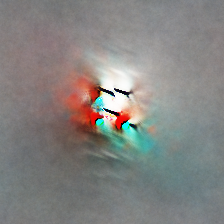

100%|██████████| 512/512 [00:21<00:00, 23.83it/s]


In [20]:
all_transforms = [
    transform.pad(8),
    transform.jitter(2),
    transform.random_scale([n/100. for n in range(90, 110)]),
    #transform.random_rotate(list(range(-10,10)) + list(range(-5,5)) + 10*list(range(-2,2))),
    transform.jitter(2),
]


#model_2.to('cuda:0')
#model.to('cuda:0')
model_dis.to('cuda:0')
param_f = lambda: param.image(224,batch=1,fft=True,sd=.5)
obj =  objectives.neuron('features_3', 108-64, batch=0) 
_ = render.render_vis(model_dis, obj, param_f, transforms=all_transforms, verbose=True, show_inline=True,show_image=True, save_image=False)

### For size model

  2%|▏         | 11/512 [00:00<00:04, 108.28it/s]

Initial loss: 0.011


 98%|█████████▊| 503/512 [00:05<00:00, 92.80it/s]

Loss at step 512: -8.832



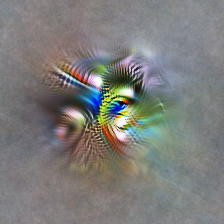

100%|██████████| 512/512 [00:05<00:00, 94.05it/s]



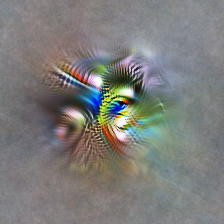

5.6058149337768555


In [43]:
#visualize  'size' equivalent subgraphs 
model_dis.to('cuda:2')

start = time.time()

version = 'random'
node = 503
size_model_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/%s_models/%s_.9.9.pt'%(version,str(node)))
size_model = size_model_dict['model']
size_model.to('cuda:0')
name = None
for name, module in size_model.named_modules():
    pass
param_f = lambda: param.image(224,batch=1,sd=.7)
obj =  objectives.neuron(name, 0, batch=0) 
_ = render.render_vis(size_model, obj, param_f, verbose=True, show_inline=True,show_image=True, save_image=False,image_name = 'prepped_models/alexnet_sparse/subgraphs/visualizations/%s_.9.9_target.jpg'%str(node))

print(time.time() - start)

In [55]:
nodeid_2_perlayerid(996,params)

(4, 100, 'features_10')

  2%|▏         | 12/512 [00:00<00:04, 114.21it/s]

Initial loss: -0.145


 99%|█████████▉| 508/512 [00:04<00:00, 99.07it/s] 

Loss at step 512: -93.044



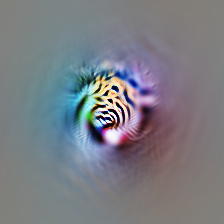

100%|██████████| 512/512 [00:05<00:00, 102.30it/s]



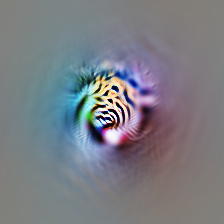

  2%|▏         | 11/512 [00:00<00:04, 101.37it/s]

Initial loss: -0.186


 99%|█████████▊| 505/512 [00:04<00:00, 102.75it/s]

Loss at step 512: -58.637



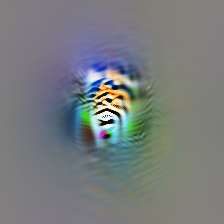

100%|██████████| 512/512 [00:05<00:00, 101.71it/s]



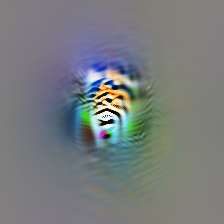

  2%|▏         | 11/512 [00:00<00:04, 108.88it/s]

Initial loss: -0.069


 99%|█████████▊| 505/512 [00:04<00:00, 101.99it/s]

Loss at step 512: -20.760



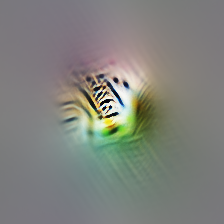

100%|██████████| 512/512 [00:05<00:00, 101.85it/s]



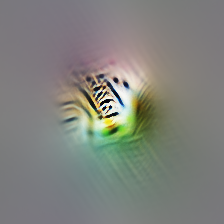

  2%|▏         | 11/512 [00:00<00:04, 107.31it/s]

Initial loss: -0.018


 99%|█████████▉| 506/512 [00:04<00:00, 102.61it/s]

Loss at step 512: -0.018



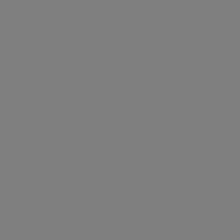

100%|██████████| 512/512 [00:04<00:00, 102.49it/s]



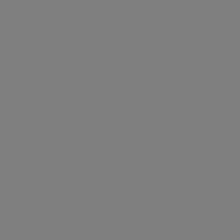

20.303388833999634


In [52]:
#### visualize subgraphs of different sizes
model_dis.to('cuda:2')

start = time.time()
sizes = ['0.80.9','0.60.8','0.40.7','0.20.6']
node = 472
for size in sizes:
    size_model_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/%s_%s.pt'%(str(node),size))
    size_model = size_model_dict['model']
    size_model.to('cuda:0')
    name = None
    for name, module in size_model.named_modules():
        pass
    param_f = lambda: param.image(224,batch=1)
    obj =  objectives.neuron(name, 0, batch=0) 
    _ = render.render_vis(size_model, obj, param_f, verbose=True, show_inline=True,show_image=True, save_image=False,image_name = 'prepped_models/alexnet_sparse/subgraphs/visualizations/%s_.9.9_target.jpg'%str(node))

print(time.time() - start)

  2%|▏         | 12/512 [00:00<00:04, 114.21it/s]

Initial loss: -0.145


 99%|█████████▉| 508/512 [00:04<00:00, 99.07it/s] 

Loss at step 512: -93.044



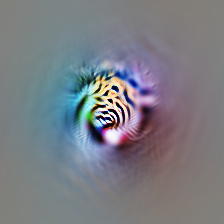

100%|██████████| 512/512 [00:05<00:00, 102.30it/s]



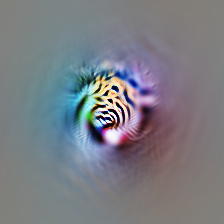

  2%|▏         | 11/512 [00:00<00:04, 101.37it/s]

Initial loss: -0.186


 99%|█████████▊| 505/512 [00:04<00:00, 102.75it/s]

Loss at step 512: -58.637



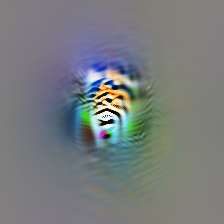

100%|██████████| 512/512 [00:05<00:00, 101.71it/s]



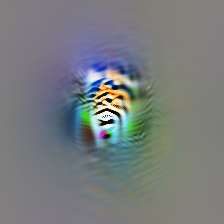

  2%|▏         | 11/512 [00:00<00:04, 108.88it/s]

Initial loss: -0.069


 99%|█████████▊| 505/512 [00:04<00:00, 101.99it/s]

Loss at step 512: -20.760



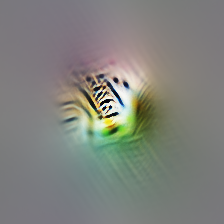

100%|██████████| 512/512 [00:05<00:00, 101.85it/s]



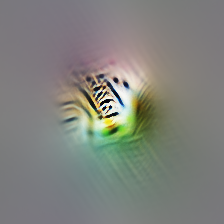

  2%|▏         | 11/512 [00:00<00:04, 107.31it/s]

Initial loss: -0.018


 99%|█████████▉| 506/512 [00:04<00:00, 102.61it/s]

Loss at step 512: -0.018



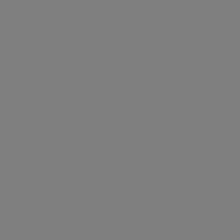

100%|██████████| 512/512 [00:04<00:00, 102.49it/s]



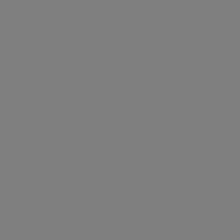

20.303388833999634


In [52]:
#### visualize subgraphs of different sizes
model_dis.to('cuda:2')

start = time.time()
sizes = ['0.80.9','0.60.8','0.40.7','0.20.6']
node = 472
for size in sizes:
    size_model_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/%s_%s.pt'%(str(node),size))
    size_model = size_model_dict['model']
    size_model.to('cuda:0')
    name = None
    for name, module in size_model.named_modules():
        pass
    param_f = lambda: param.image(224,batch=1)
    obj =  objectives.neuron(name, 0, batch=0) 
    _ = render.render_vis(size_model, obj, param_f, verbose=True, show_inline=True,show_image=True, save_image=False,image_name = 'prepped_models/alexnet_sparse/subgraphs/visualizations/%s_.9.9_target.jpg'%str(node))

print(time.time() - start)

In [53]:
#get subgraph sizes

#visualize subgraphs of different sizes
model_dis.to('cuda:2')


sizes = ['.9.9','0.80.9','0.60.8','0.40.7','0.20.6']
node = 472
for size in sizes:
    size_model_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/%s_%s.pt'%(str(node),size))
    print(len(size_model_dict['edge_df']))

2113
1282
450
142
37


## Generate graphs of different sizes and types


In [37]:
#extract subgraphs and same size subgraphs of multiple sizes

#run through all subgraphs generating same size subgraphs

import time
start = time.time()



node_thresholds = [.8,.6,.4,.2]

edge_thresholds = [.9,.8,.7,.6]



model_dis.to('cuda:1')

start = time.time()

for node in range(1,313,2):
    
    n_df,e_df=ranksdf_store('small_SPAN', str(node), [],model_dis=model_dis)
    n_df = minmax_normalize_ranks_df(n_df,params)
    for s in range(len(node_thresholds)):
        threshed_n_df,threshed_e_df = hierarchical_accum_threshold(node_thresholds[s],edge_thresholds[s],rank_type,e_df,n_df)
        sub_model = extract_subgraph(model,threshed_n_df,threshed_e_df,params)
        sub_model.to('cuda:1')

        sub_dict = {
                   'model':sub_model,
                   'gen_params':
                        {'node_thresh':node_thresholds[s],
                         'edge_thresh':edge_thresholds[s],
                         'input':'small_SPAN',
                         'output':str(node)
                        },
                    'node_df':threshed_n_df,
                    'edge_df':threshed_e_df
                  }
        sub_dict_path = 'prepped_models/alexnet_sparse/subgraphs/models/%s_%s%s.pt'%(str(node),str(node_thresholds[s]),edge_thresholds[s])
        torch.save(sub_dict,sub_dict_path)
        #make subgraphs
        for version in ['random','worst']:
            for version in ['random','worst']:
                save_path = 'prepped_models/alexnet_sparse/subgraphs/models/%s_models/%s_%s%s.pt'%(version,str(node),str(node_thresholds[s]),edge_thresholds[s])
                n_sizes = get_layer_sizes_from_df(sub_dict['node_df'])
                e_sizes = get_layer_sizes_from_df(sub_dict['edge_df'])
                size_n_df,size_e_df = hierarchical_size_threshold(n_sizes,e_sizes,rank_type,n_df,e_df,selection=version)
                size_model = extract_subgraph(model,size_n_df,size_e_df,params)
                size_dict = {
                   'model':size_model,
                   'gen_params':
                        {'node_sizes':n_sizes,
                         'edge_sizes':e_sizes,
                         'input':'small_SPAN',
                         'output':node,
                         'selection':version,
                         'from_model':sub_dict_path
                        },
                    'node_df':size_n_df,
                    'edge_df':size_e_df
                  }
                torch.save(size_dict,save_path)
                
print(time.time()-start)



Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "1"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
1
tensor(-2.0327, device='cuda:2', grad_fn=<SelectBackward>)
target node 1 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
1
tensor(-2.6406, device='cuda:2', grad_fn=<SelectBackward>)
target node 1 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
1
tensor(-2.7777, device='cuda:2', grad_fn=<SelectBackward>)
target node 1 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
1
tensor(-2.4577, device='cuda:2', grad_fn=<SelectBackward>)
target node 1 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_0
1
tensor(-3.8017, device='cuda:2', grad_fn=<SelectBackward>)
target node 1 reached, halted forward pass
batch 5
target reached, breakin

target reached, breaking model forward pass in features_0
5
tensor(-0.0827, device='cuda:2', grad_fn=<SelectBackward>)
target node 5 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_0
5
tensor(0.0050, device='cuda:2', grad_fn=<SelectBackward>)
target node 5 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.0000

layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "11"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
11
tensor(-0.0929, device='cuda:2', grad_fn=<SelectBackward>)
target node 11 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
11
tensor(-0.0944, device='cuda:2', grad_fn=<SelectBackward>)
target node 11 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
11
tensor(-0.0931, device='cuda:2', grad_fn=<SelectBackward>)
target node 11 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
11
tensor(-0.0790, device='cuda:2', grad_fn=<SelectBackward>)
target node 11 reached, halted forward pass
batch 4
targ

target reached, breaking model forward pass in features_0
15
tensor(-1.2326, device='cuda:2', grad_fn=<SelectBackward>)
target node 15 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_0
15
tensor(-1.1745, device='cuda:2', grad_fn=<SelectBackward>)
target node 15 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0

layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "21"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
21
tensor(0.2591, device='cuda:2', grad_fn=<SelectBackward>)
target node 21 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
21
tensor(-0.1375, device='cuda:2', grad_fn=<SelectBackward>)
target node 21 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
21
tensor(-0.7694, device='cuda:2', grad_fn=<SelectBackward>)
target node 21 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
21
tensor(1.2105, device='cuda:2', grad_fn=<SelectBackward>)
target node 21 reached, halted forward pass
batch 4
target

target reached, breaking model forward pass in features_0
25
tensor(-0.0484, device='cuda:2', grad_fn=<SelectBackward>)
target node 25 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_0
25
tensor(-0.0715, device='cuda:2', grad_fn=<SelectBackward>)
target node 25 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0

layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "31"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
31
tensor(-1.8671, device='cuda:2', grad_fn=<SelectBackward>)
target node 31 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
31
tensor(-1.7959, device='cuda:2', grad_fn=<SelectBackward>)
target node 31 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
31
tensor(-1.7164, device='cuda:2', grad_fn=<SelectBackward>)
target node 31 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
31
tensor(-1.9110, device='cuda:2', grad_fn=<SelectBackward>)
target node 31 reached, halted forward pass
batch 4
targ

target reached, breaking model forward pass in features_0
35
tensor(0.3856, device='cuda:2', grad_fn=<SelectBackward>)
target node 35 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_0
35
tensor(1.4774, device='cuda:2', grad_fn=<SelectBackward>)
target node 35 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.0

layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "41"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
41
tensor(-0.0390, device='cuda:2', grad_fn=<SelectBackward>)
target node 41 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
41
tensor(-0.0271, device='cuda:2', grad_fn=<SelectBackward>)
target node 41 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
41
tensor(-0.0279, device='cuda:2', grad_fn=<SelectBackward>)
target node 41 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
41
tensor(-0.0232, device='cuda:2', grad_fn=<SelectBackward>)
target node 41 reached, halted forward pass
batch 4
targ

target reached, breaking model forward pass in features_0
45
tensor(-1.7746, device='cuda:2', grad_fn=<SelectBackward>)
target node 45 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_0
45
tensor(-1.7929, device='cuda:2', grad_fn=<SelectBackward>)
target node 45 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0

layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "51"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
51
tensor(-2.1336, device='cuda:2', grad_fn=<SelectBackward>)
target node 51 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
51
tensor(-2.4494, device='cuda:2', grad_fn=<SelectBackward>)
target node 51 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
51
tensor(-0.7805, device='cuda:2', grad_fn=<SelectBackward>)
target node 51 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
51
tensor(-0.7252, device='cuda:2', grad_fn=<SelectBackward>)
target node 51 reached, halted forward pass
batch 4
targ

target node 55 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_0
55
tensor(-0.0492, device='cuda:2', grad_fn=<SelectBackward>)
target node 55 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_0
55
tensor(-0.0405, device='cuda:2', grad_fn=<SelectBackward>)
target node 55 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933792   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    25

layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
[0 1 2 3 4]
layer: 0
layer: 0
layer: 0
layer: 0
layer: 0
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "61"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_0
61
tensor(-0.1979, device='cuda:2', grad_fn=<SelectBackward>)
target node 61 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_0
61
tensor(-0.1970, device='cuda:2', grad_fn=<SelectBackward>)
target node 61 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_0
61
tensor(-0.1930, device='cuda:2', grad_fn=<SelectBackward>)
target node 61 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_0
61
tensor(-0.1981, device='cuda:2', grad_fn=<SelectBackward>)
target node 61 reached, halted forward pass
batch 4
targ

target reached, breaking model forward pass in features_3
1
tensor(-2.6246, device='cuda:2', grad_fn=<SelectBackward>)
target node 65 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
1
tensor(-2.3591, device='cuda:2', grad_fn=<SelectBackward>)
target node 65 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
1
tensor(-3.8040, device='cuda:2', grad_fn=<SelectBackward>)
target node 65 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
1
tensor(-4.9882, device='cuda:2', grad_fn=<SelectBackward>)
target node 65 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   featu

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "71"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
7
tensor(-4.0582, device='cuda:2', grad_fn=<SelectBackward>)
target node 71 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
7
tensor(-4.1794, device='cuda:2', grad_fn=<SelectBackward>)
target node 71 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
7
tensor(-5.6500, device='cuda:2', grad_fn=<SelectBackward>)
target node 71 reached, 

target node 75 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
11
tensor(-0.9529, device='cuda:2', grad_fn=<SelectBackward>)
target node 75 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
11
tensor(-0.7594, device='cuda:2', grad_fn=<SelectBackward>)
target node 75 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
11
tensor(-0.0847, device='cuda:2', grad_fn=<SelectBackward>)
target node 75 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
11
tensor(-1.3797, device='cuda:2', grad_fn=<SelectBackward>)
target node 75 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
11
tensor(-0.7359, device='cuda:2', grad_fn=<SelectBackward>)
target node 75 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   fe

target node 79 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       2.067550e

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "85"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
21
tensor(-2.1246, device='cuda:2', grad_fn=<SelectBackward>)
target node 85 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
21
tensor(-1.7599, device='cuda:2', grad_fn=<SelectBackward>)
target node 85 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
21
tensor(-1.6602, device='cuda:2', grad_fn=<SelectBackward>)
target node 85 reache

target node 89 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
25
tensor(-2.5494, device='cuda:2', grad_fn=<SelectBackward>)
target node 89 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
25
tensor(-0.6484, device='cuda:2', grad_fn=<SelectBackward>)
target node 89 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
25
tensor(-4.4862, device='cuda:2', grad_fn=<SelectBackward>)
target node 89 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
25
tensor(-1.3052, device='cuda:2', grad_fn=<SelectBackward>)
target node 89 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
25
tensor(0.8430, device='cuda:2', grad_fn=<SelectBackward>)
target node 89 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   fea

target node 93 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000004   

layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "99"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
35
tensor(-3.1098, device='cuda:2', grad_fn=<SelectBackward>)
target node 99 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
35
tensor(-4.2551, device='cuda:2', grad_fn=<SelectBackward>)
target node 99 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
35
tensor(-2.5687, device='cuda:2', grad_fn=<SelectBackward>)
target node 

target node 103 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
39
tensor(-0.6970, device='cuda:2', grad_fn=<SelectBackward>)
target node 103 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
39
tensor(-0.1851, device='cuda:2', grad_fn=<SelectBackward>)
target node 103 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
39
tensor(-1.2173, device='cuda:2', grad_fn=<SelectBackward>)
target node 103 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
39
tensor(-0.6592, device='cuda:2', grad_fn=<SelectBackward>)
target node 103 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
39
tensor(1.7806, device='cuda:2', grad_fn=<SelectBackward>)
target node 103 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       9.792469e-07       0.000002  
1       9.792469e-07   

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "113"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
49
tensor(-3.2112, device='cuda:2', grad_fn=<SelectBackward>)
target node 113 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
49
tensor(-3.0583, device='cuda:2', grad_fn=<SelectBackward>)
target node 113 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
49
tensor(-2.0782, device='cuda:2', grad_fn=<SelectBackward>)
target node 113 re

target node 117 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
53
tensor(-2.7180, device='cuda:2', grad_fn=<SelectBackward>)
target node 117 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
53
tensor(-1.9807, device='cuda:2', grad_fn=<SelectBackward>)
target node 117 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
53
tensor(-2.7343, device='cuda:2', grad_fn=<SelectBackward>)
target node 117 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
53
tensor(-2.7457, device='cuda:2', grad_fn=<SelectBackward>)
target node 117 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
53
tensor(-6.6769, device='cuda:2', grad_fn=<SelectBackward>)
target node 117 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              

target node 121 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       2.128050

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "127"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
63
tensor(-18.3089, device='cuda:2', grad_fn=<SelectBackward>)
target node 127 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
63
tensor(-12.6154, device='cuda:2', grad_fn=<SelectBackward>)
target node 127 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
63
tensor(-11.8717, device='cuda:2', grad_fn=<SelectBackward>)
target node 127

target node 131 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
67
tensor(-3.6685, device='cuda:2', grad_fn=<SelectBackward>)
target node 131 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
67
tensor(-2.4912, device='cuda:2', grad_fn=<SelectBackward>)
target node 131 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
67
tensor(-4.3928, device='cuda:2', grad_fn=<SelectBackward>)
target node 131 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
67
tensor(-3.1775, device='cuda:2', grad_fn=<SelectBackward>)
target node 131 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
67
tensor(-0.3489, device='cuda:2', grad_fn=<SelectBackward>)
target node 131 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       5.785030e-07   1.312288e-06  
1       5.785030e-07   

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "141"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
77
tensor(-2.1050, device='cuda:2', grad_fn=<SelectBackward>)
target node 141 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
77
tensor(-1.5099, device='cuda:2', grad_fn=<SelectBackward>)
target node 141 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
77
tensor(-1.6111, device='cuda:2', grad_fn=<SelectBackward>)
target node 141 re

target node 145 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
81
tensor(-3.2583, device='cuda:2', grad_fn=<SelectBackward>)
target node 145 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
81
tensor(-3.1059, device='cuda:2', grad_fn=<SelectBackward>)
target node 145 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
81
tensor(-2.1537, device='cuda:2', grad_fn=<SelectBackward>)
target node 145 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
81
tensor(-3.6355, device='cuda:2', grad_fn=<SelectBackward>)
target node 145 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
81
tensor(-4.0918, device='cuda:2', grad_fn=<SelectBackward>)
target node 145 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              

target node 149 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000006  

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "155"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
91
tensor(-2.8452, device='cuda:2', grad_fn=<SelectBackward>)
target node 155 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
91
tensor(-3.8683, device='cuda:2', grad_fn=<SelectBackward>)
target node 155 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
91
tensor(-2.9899, device='cuda:2', grad_fn=<SelectBackward>)
target node 155 re

target node 159 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
95
tensor(-4.3923, device='cuda:2', grad_fn=<SelectBackward>)
target node 159 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
95
tensor(-2.9874, device='cuda:2', grad_fn=<SelectBackward>)
target node 159 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
95
tensor(-3.6758, device='cuda:2', grad_fn=<SelectBackward>)
target node 159 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
95
tensor(-5.7118, device='cuda:2', grad_fn=<SelectBackward>)
target node 159 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
95
tensor(-4.1666, device='cuda:2', grad_fn=<SelectBackward>)
target node 159 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        0.000002       0.000

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "169"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
105
tensor(-0.9198, device='cuda:2', grad_fn=<SelectBackward>)
target node 169 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
105
tensor(-1.2139, device='cuda:2', grad_fn=<SelectBackward>)
target node 169 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
105
tensor(-0.9283, device='cuda:2', grad_fn=<SelectBackward>)
target node 169

target node 173 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
109
tensor(-1.9633, device='cuda:2', grad_fn=<SelectBackward>)
target node 173 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
109
tensor(-0.4305, device='cuda:2', grad_fn=<SelectBackward>)
target node 173 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
109
tensor(0.2695, device='cuda:2', grad_fn=<SelectBackward>)
target node 173 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
109
tensor(-0.7822, device='cuda:2', grad_fn=<SelectBackward>)
target node 173 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
109
tensor(-1.8705, device='cuda:2', grad_fn=<SelectBackward>)
target node 173 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0          

target node 177 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       3.407216

layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "183"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
119
tensor(-2.0242, device='cuda:2', grad_fn=<SelectBackward>)
target node 183 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
119
tensor(-2.8037, device='cuda:2', grad_fn=<SelectBackward>)
target node 183 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
119
tensor(-2.6438, device='cuda:2', grad_fn=<SelectBackward>)
target

target node 187 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
123
tensor(-12.2901, device='cuda:2', grad_fn=<SelectBackward>)
target node 187 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
123
tensor(-9.3383, device='cuda:2', grad_fn=<SelectBackward>)
target node 187 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
123
tensor(-8.0733, device='cuda:2', grad_fn=<SelectBackward>)
target node 187 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
123
tensor(-9.0046, device='cuda:2', grad_fn=<SelectBackward>)
target node 187 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
123
tensor(-5.5452, device='cuda:2', grad_fn=<SelectBackward>)
target node 187 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0        

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       1.922249e-05   4.129149e-05  
1       1.922249e-05   

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "197"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
133
tensor(-8.6222, device='cuda:2', grad_fn=<SelectBackward>)
target node 197 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
133
tensor(-10.8927, device='cuda:2', grad_fn=<SelectBackward>)
target node 197 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
133
tensor(-11.0117, device='cuda:2', grad_fn=<SelectBackward>)
target node 1

target node 201 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
137
tensor(-3.5015, device='cuda:2', grad_fn=<SelectBackward>)
target node 201 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
137
tensor(-3.9634, device='cuda:2', grad_fn=<SelectBackward>)
target node 201 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
137
tensor(-2.8403, device='cuda:2', grad_fn=<SelectBackward>)
target node 201 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
137
tensor(-3.2545, device='cuda:2', grad_fn=<SelectBackward>)
target node 201 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
137
tensor(-1.9710, device='cuda:2', grad_fn=<SelectBackward>)
target node 201 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0         

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000003   6.770032e-06  
1        0.000003   1.166477e

layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "211"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
147
tensor(-2.8061, device='cuda:2', grad_fn=<SelectBackward>)
target node 211 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
147
tensor(-2.9595, device='cuda:2', grad_fn=<SelectBackward>)
target node 211 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
147
tensor(-3.2107, device='cuda:2', grad_fn=<SelectBackward>)
target node 211 reached,

target node 215 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
151
tensor(-5.0540, device='cuda:2', grad_fn=<SelectBackward>)
target node 215 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
151
tensor(-3.3945, device='cuda:2', grad_fn=<SelectBackward>)
target node 215 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
151
tensor(-4.2725, device='cuda:2', grad_fn=<SelectBackward>)
target node 215 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
151
tensor(-4.5645, device='cuda:2', grad_fn=<SelectBackward>)
target node 215 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
151
tensor(-4.3679, device='cuda:2', grad_fn=<SelectBackward>)
target node 215 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0         

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       8.830029e-07   1.950046e-06  
1       8.830029e-07   

layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "225"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
161
tensor(-9.6547, device='cuda:2', grad_fn=<SelectBackward>)
target node 225 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
161
tensor(-0.2209, device='cuda:2', grad_fn=<SelectBackward>)
target node 225 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
161
tensor(-2.0240, device='cuda:2', grad_fn=<SelectBackward>)
target

target node 229 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
165
tensor(-3.6942, device='cuda:2', grad_fn=<SelectBackward>)
target node 229 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
165
tensor(-3.2881, device='cuda:2', grad_fn=<SelectBackward>)
target node 229 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
165
tensor(-5.8973, device='cuda:2', grad_fn=<SelectBackward>)
target node 229 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
165
tensor(-4.3241, device='cuda:2', grad_fn=<SelectBackward>)
target node 229 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
165
tensor(-7.1243, device='cuda:2', grad_fn=<SelectBackward>)
target node 229 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0         

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000005   1.228391e-05  
1        0.000005   2.114418e

layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "239"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
175
tensor(-6.8297, device='cuda:2', grad_fn=<SelectBackward>)
target node 239 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
175
tensor(-8.7861, device='cuda:2', grad_fn=<SelectBackward>)
target node 239 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
175
tensor(-7.6621, device='cuda:2', grad_fn=<SelectBackward>)
target node 239 reached,

target node 243 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_3
179
tensor(-11.0866, device='cuda:2', grad_fn=<SelectBackward>)
target node 243 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_3
179
tensor(-11.9070, device='cuda:2', grad_fn=<SelectBackward>)
target node 243 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_3
179
tensor(-13.0995, device='cuda:2', grad_fn=<SelectBackward>)
target node 243 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_3
179
tensor(-12.3017, device='cuda:2', grad_fn=<SelectBackward>)
target node 243 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_3
179
tensor(-19.1178, device='cuda:2', grad_fn=<SelectBackward>)
target node 243 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0    

        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

           grad_rank  actxgrad_rank  
0       1.116108e-06   2.467374e-06  
1       1.116108e-06   

layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
[0 1 2 3 4]
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
layer: 0
layer: 1
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "253"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_3
189
tensor(-3.0441, device='cuda:2', grad_fn=<SelectBackward>)
target node 253 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_3
189
tensor(-2.9503, device='cuda:2', grad_fn=<SelectBackward>)
target node 253 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_3
189
tensor(-2.9679, device='cuda:2', grad_fn=<SelectBackward>)
target node 253

target node 257 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_6
1
tensor(-2.1078, device='cuda:2', grad_fn=<SelectBackward>)
target node 257 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_6
1
tensor(-1.6533, device='cuda:2', grad_fn=<SelectBackward>)
target node 257 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_6
1
tensor(-2.4022, device='cuda:2', grad_fn=<SelectBackward>)
target node 257 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_6
1
tensor(-1.9610, device='cuda:2', grad_fn=<SelectBackward>)
target node 257 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
1
tensor(-2.3209, device='cuda:2', grad_fn=<SelectBackward>)
target node 257 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_6
1
tensor(-2.4070, device='cud

target node 261 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_6
5
tensor(-1.4212, device='cuda:2', grad_fn=<SelectBackward>)
target node 261 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10    

layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "267"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_6
11
tensor(-0.7261, device='cuda:2', grad_fn=<SelectBackward>)
target node 267 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
11
tensor(-2.3321, device='cuda:2', grad_fn=<SelectBackward>)
ta

target node 271 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
15
tensor(-3.8737, device='cuda:2', grad_fn=<SelectBackward>)
target node 271 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_6
15
tensor(-2.6007, device='cuda:2', grad_fn=<SelectBackward>)
target node 271 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_6
15
tensor(-3.7954, device='cuda:2', grad_fn=<SelectBackward>)
target node 271 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_6
15
tensor(-2.7997, device='cuda:2', grad_fn=<SelectBackward>)
target node 271 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_6
15
tensor(-3.3979, device='cuda:2', grad_fn=<SelectBackward>)
target node 271 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
15
tensor(-3.6904, devic

target node 275 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
19
tensor(-0.8390, device='cuda:2', grad_fn=<SelectBackward>)
target node 275 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_6
19
tensor(0.0849, device='cuda:2', grad_fn=<SelectBackward>)
target node 275 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    

layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "281"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_6
25
tensor(-3.7190, device='cuda:2', grad_fn=<SelectBackward>)
target node 281 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
25
tensor(-6.6206, device='cuda:2', grad_fn=<SelectBackward>)
ta

target node 285 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
29
tensor(-0.6997, device='cuda:2', grad_fn=<SelectBackward>)
target node 285 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_6
29
tensor(0.4685, device='cuda:2', grad_fn=<SelectBackward>)
target node 285 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_6
29
tensor(0.1636, device='cuda:2', grad_fn=<SelectBackward>)
target node 285 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_6
29
tensor(-0.5385, device='cuda:2', grad_fn=<SelectBackward>)
target node 285 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_6
29
tensor(-0.3941, device='cuda:2', grad_fn=<SelectBackward>)
target node 285 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
29
tensor(-0.8849, device=

target node 289 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
33
tensor(-1.8980, device='cuda:2', grad_fn=<SelectBackward>)
target node 289 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_6
33
tensor(-1.7302, device='cuda:2', grad_fn=<SelectBackward>)
target node 289 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044   

layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "295"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_6
39
tensor(-1.4682, device='cuda:2', grad_fn=<SelectBackward>)
target node 295 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
39
tensor(-1.3462, device='cuda:2', grad_fn=<SelectBackward>)
ta

target node 299 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
43
tensor(-2.7014, device='cuda:2', grad_fn=<SelectBackward>)
target node 299 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_6
43
tensor(-2.1083, device='cuda:2', grad_fn=<SelectBackward>)
target node 299 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_6
43
tensor(-2.2015, device='cuda:2', grad_fn=<SelectBackward>)
target node 299 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_6
43
tensor(-3.6569, device='cuda:2', grad_fn=<SelectBackward>)
target node 299 reached, halted forward pass
batch 5
target reached, breaking model forward pass in features_6
43
tensor(-3.5677, device='cuda:2', grad_fn=<SelectBackward>)
target node 299 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
43
tensor(-3.5649, devic

target node 303 reached, halted forward pass
batch 6
target reached, breaking model forward pass in features_6
47
tensor(-3.0609, device='cuda:2', grad_fn=<SelectBackward>)
target node 303 reached, halted forward pass
batch 7
target reached, breaking model forward pass in features_6
47
tensor(-2.2140, device='cuda:2', grad_fn=<SelectBackward>)
target node 303 reached, halted forward pass
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044   

layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
[0 1 2 3 4]
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
layer: 0
layer: 1
layer: 2
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "309"
using device cuda:2
batch 0
target reached, breaking model forward pass in features_6
53
tensor(-0.2609, device='cuda:2', grad_fn=<SelectBackward>)
target node 309 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_6
53
tensor(0.3588, device='cuda:2', grad_fn=<SelectBackward>)
tar

In [ ]:
random_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/random_models/1000_0.20.6.pt')
worst_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/worst_models/1000_0.20.6.pt')
best_dict = torch.load('prepped_models/alexnet_sparse/subgraphs/models/1000_0.20.6.pt')

In [ ]:
best_dict['model']

In [ ]:
worst_dict['model']


In [ ]:
print(len(random_dict['node_df'].loc[random_dict['node_df']['layer']==2]))
print(len(best_dict['node_df'].loc[best_dict['node_df']['layer']==2]))
print(len(worst_dict['node_df'].loc[worst_dict['node_df']['layer']==2]))

In [ ]:
best_dict['node_df'].loc[best_dict['node_df']['layer']==2].sort_values('node_num_by_layer')

In [ ]:
worst_dict['node_df'].loc[worst_dict['node_df']['layer']==2].sort_values('node_num_by_layer')

In [ ]:
nodeid_2_perlayerid(200,params)